# Initialization (FastKAN)

In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from typing import *

class SplineLinear(nn.Linear):
    def __init__(self, in_features: int, out_features: int, init_scale: float = 0.1, **kw) -> None:
        self.init_scale = init_scale
        super().__init__(in_features, out_features, bias=False, **kw)

    def reset_parameters(self) -> None:
        nn.init.trunc_normal_(self.weight, mean=0, std=self.init_scale)

class RadialBasisFunction(nn.Module):
    def __init__(
        self,
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        denominator: float = None,  # larger denominators lead to smoother basis
    ):
        super().__init__()
        self.grid_min = grid_min
        self.grid_max = grid_max
        self.num_grids = num_grids
        grid = torch.linspace(grid_min, grid_max, num_grids)
        self.grid = torch.nn.Parameter(grid, requires_grad=False)
        self.denominator = denominator or (grid_max - grid_min) / (num_grids - 1)

    def forward(self, x):
        return torch.exp(-((x[..., None] - self.grid) / self.denominator) ** 2)

class FastKANLayer(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        use_base_update: bool = True,
        use_layernorm: bool = True,
        base_activation = F.silu,
        spline_weight_init_scale: float = 0.1,
    ) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layernorm = None
        if use_layernorm:
            assert input_dim > 1, "Do not use layernorms on 1D inputs. Set `use_layernorm=False`."
            self.layernorm = nn.LayerNorm(input_dim)
        self.rbf = RadialBasisFunction(grid_min, grid_max, num_grids)
        self.spline_linear = SplineLinear(input_dim * num_grids, output_dim, spline_weight_init_scale)
        self.use_base_update = use_base_update
        if use_base_update:
            self.base_activation = base_activation
            self.base_linear = nn.Linear(input_dim, output_dim)

    def forward(self, x, use_layernorm=True):
        if self.layernorm is not None and use_layernorm:
            spline_basis = self.rbf(self.layernorm(x))
        else:
            spline_basis = self.rbf(x)
        ret = self.spline_linear(spline_basis.view(*spline_basis.shape[:-2], -1))
        if self.use_base_update:
            base = self.base_linear(self.base_activation(x))
            ret = ret + base
        return ret

    def plot_curve(
        self,
        input_index: int,
        output_index: int,
        num_pts: int = 1000,
        num_extrapolate_bins: int = 2
    ):
        '''this function returns the learned curves in a FastKANLayer.
        input_index: the selected index of the input, in [0, input_dim) .
        output_index: the selected index of the output, in [0, output_dim) .
        num_pts: num of points sampled for the curve.
        num_extrapolate_bins (N_e): num of bins extrapolating from the given grids. The curve 
            will be calculate in the range of [grid_min - h * N_e, grid_max + h * N_e].
        '''
        ng = self.rbf.num_grids
        h = self.rbf.denominator
        assert input_index < self.input_dim
        assert output_index < self.output_dim
        w = self.spline_linear.weight[
            output_index, input_index * ng : (input_index + 1) * ng
        ]   # num_grids,
        x = torch.linspace(
            self.rbf.grid_min - num_extrapolate_bins * h,
            self.rbf.grid_max + num_extrapolate_bins * h,
            num_pts
        )   # num_pts, num_grids
        with torch.no_grad():
            y = (w * self.rbf(x.to(w.dtype))).sum(-1)
        return x, y


class FastKAN(nn.Module):
    def __init__(
        self,
        layers_hidden: List[int],
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        use_base_update: bool = True,
        base_activation = F.silu,
        spline_weight_init_scale: float = 0.1,
    ) -> None:
        super().__init__()
        self.layers = nn.ModuleList([
            FastKANLayer(
                in_dim, out_dim,
                grid_min=grid_min,
                grid_max=grid_max,
                num_grids=num_grids,
                use_base_update=use_base_update,
                base_activation=base_activation,
                spline_weight_init_scale=spline_weight_init_scale,
            ) for in_dim, out_dim in zip(layers_hidden[:-1], layers_hidden[1:])
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class AttentionWithFastKANTransform(nn.Module):
    
    def __init__(
        self,
        q_dim: int,
        k_dim: int,
        v_dim: int,
        head_dim: int,
        num_heads: int,
        gating: bool = True,
    ):
        super(AttentionWithFastKANTransform, self).__init__()

        self.num_heads = num_heads
        total_dim = head_dim * self.num_heads
        self.gating = gating
        self.linear_q = FastKANLayer(q_dim, total_dim)
        self.linear_k = FastKANLayer(k_dim, total_dim)
        self.linear_v = FastKANLayer(v_dim, total_dim)
        self.linear_o = FastKANLayer(total_dim, q_dim)
        self.linear_g = None
        if self.gating:
            self.linear_g = FastKANLayer(q_dim, total_dim)
        # precompute the 1/sqrt(head_dim)
        self.norm = head_dim**-0.5

    def forward(
        self,
        q: torch.Tensor,
        k: torch.Tensor,
        v: torch.Tensor,
        bias: torch.Tensor = None,      # additive attention bias
    ) -> torch.Tensor:         

        wq = self.linear_q(q).view(*q.shape[:-1], 1, self.num_heads, -1) * self.norm     # *q1hc
        wk = self.linear_k(k).view(*k.shape[:-2], 1, k.shape[-2], self.num_heads, -1)    # *1khc
        att = (wq * wk).sum(-1).softmax(-2)     # *qkh
        del wq, wk
        if bias is not None:
            att = att + bias[..., None]

        wv = self.linear_v(v).view(*v.shape[:-2],1, v.shape[-2], self.num_heads, -1)     # *1khc
        o = (att[..., None] * wv).sum(-3)        # *qhc
        del att, wv

        o = o.view(*o.shape[:-2], -1)           # *q(hc)

        if self.linear_g is not None:
            # gating, use raw query input
            g = self.linear_g(q)
            o = torch.sigmoid(g) * o

        # merge heads
        o = self.linear_o(o)
        return o



# Copyright 2024 Li, Ziyao
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import math
# from typing import *
# import numpy as np
# import matplotlib.pyplot as plt
# from pulp import LpProblem, LpVariable, LpMinimize, LpMaximize, LpStatus, LpBinary, lpSum, PULP_CBC_CMD, LpAffineExpression

# class SplineLinear(nn.Linear):
#     # --- (Keep existing SplineLinear class) ---
#     def __init__(self, in_features: int, out_features: int, init_scale: float = 0.1, **kw) -> None:
#         self.init_scale = init_scale
#         # Need to store weight for reset_parameters
#         self.segments = torch.empty(out_features, in_features) # Placeholder, actual size determined later if bias=True
#         super().__init__(in_features, out_features, bias=False, **kw)
#         # Override the weight parameter name if needed, assuming default 'weight'
#         # self.segments = self.weight # Use self.weight if bias=False is guaranteed

#     def reset_parameters(self) -> None:
#         # Use self.weight directly as it's the parameter created by nn.Linear
#         nn.init.trunc_normal_(self.weight, mean=0, std=self.init_scale)


# class RadialBasisFunction(nn.Module):
#     # --- (Keep existing RadialBasisFunction class) ---
#     def __init__(
#         self,
#         grid_min: float = -2.,
#         grid_max: float = 2.,
#         num_grids: int = 8,
#         denominator: float = None,  # larger denominators lead to smoother basis
#     ):
#         super().__init__()
#         self.grid_min = grid_min
#         self.grid_max = grid_max
#         self.num_grids = num_grids
#         grid = torch.linspace(grid_min, grid_max, num_grids)
#         self.grid = torch.nn.Parameter(grid, requires_grad=False)
#         self.denominator = denominator or (grid_max - grid_min) / (num_grids - 1)

#     def forward(self, x):
#         # Ensure grid is on the same device as x
#         grid = self.grid.to(x.device)
#         # Make sure denominator is a tensor for division
#         denominator = torch.tensor(self.denominator, device=x.device, dtype=x.dtype)
#         # Calculate RBF: exp(-((x_i - grid_j) / denom)^2)
#         # x shape: [..., in_dim], grid shape: [num_grids]
#         # Output shape: [..., in_dim, num_grids]
#         return torch.exp(-((x.unsqueeze(-1) - grid) / denominator) ** 2)


# class FastKANLayer(nn.Module):
#     # --- (Keep existing FastKANLayer class, ensure plot_curve uses self.spline_linear.weight) ---
#     def __init__(
#         self,
#         input_dim: int,
#         output_dim: int,
#         grid_min: float = -2.,
#         grid_max: float = 2.,
#         num_grids: int = 8,
#         use_base_update: bool = True,
#         use_layernorm: bool = True,
#         base_activation = F.silu,
#         spline_segments_init_scale: float = 0.1,
#     ) -> None:
#         super().__init__()
#         self.input_dim = input_dim
#         self.output_dim = output_dim
#         self.num_grids = num_grids # Store num_grids
#         self.layernorm = None
#         if use_layernorm:
#             # Allow LayerNorm even for input_dim=1 for consistency, though it has no effect
#             self.layernorm = nn.LayerNorm(input_dim)
#         self.rbf = RadialBasisFunction(grid_min, grid_max, num_grids)
#         self.spline_linear = SplineLinear(input_dim * num_grids, output_dim, spline_segments_init_scale) # Bias is False here
#         self.use_base_update = use_base_update
#         if use_base_update:
#             self.base_activation = base_activation
#             self.base_linear = nn.Linear(input_dim, output_dim) # Bias is True by default here

#     def forward(self, x, use_layernorm=True):
#         # Apply layernorm if specified and exists
#         if self.layernorm is not None and use_layernorm:
#             # Note: LayerNorm on dim=1 is identity. Added check for clarity/efficiency.
#             normed_x = self.layernorm(x) if x.shape[-1] > 1 else x
#         else:
#             normed_x = x

#         # Compute RBF features
#         # Input x shape: [batch..., input_dim]
#         # RBF output shape: [batch..., input_dim, num_grids]
#         spline_basis = self.rbf(normed_x)

#         # Reshape for spline linear layer
#         # Combine input_dim and num_grids dimensions
#         # Shape becomes: [batch..., input_dim * num_grids]
#         spline_basis_reshaped = spline_basis.view(*spline_basis.shape[:-2], -1)

#         # Apply spline linear layer
#         # Input shape: [batch..., input_dim * num_grids]
#         # Output shape: [batch..., output_dim]
#         spline_output = self.spline_linear(spline_basis_reshaped)

#         # Apply base update if enabled
#         if self.use_base_update:
#             base = self.base_linear(self.base_activation(x)) # Use original x for base function
#             ret = spline_output + base
#         else:
#             ret = spline_output
#         return ret

#     def plot_curve(
#         self,
#         input_index: int,
#         output_index: int,
#         num_pts: int = 1000,
#         num_extrapolate_bins: int = 2
#     ):
#         '''this function returns the learned curves in a FastKANLayer.
#         input_index: the selected index of the input, in [0, input_dim) .
#         output_index: the selected index of the output, in [0, output_dim) .
#         num_pts: num of points sampled for the curve.
#         num_extrapolate_bins (N_e): num of bins extrapolating from the given grids. The curve
#             will be calculate in the range of [grid_min - h * N_e, grid_max + h * N_e].
#         '''
#         ng = self.rbf.num_grids
#         h = self.rbf.denominator
#         assert input_index < self.input_dim
#         assert output_index < self.output_dim
#         # Access the correct weight segment from spline_linear.weight
#         # Weight shape: [out_features, in_features * num_grids]
#         # We need the row `output_index` and columns corresponding to `input_index`
#         w = self.spline_linear.weight[
#             output_index, input_index * ng : (input_index + 1) * ng
#         ]   # shape: [num_grids,]

#         x_plot = torch.linspace(
#             self.rbf.grid_min - num_extrapolate_bins * h,
#             self.rbf.grid_max + num_extrapolate_bins * h,
#             num_pts,
#             device=w.device # Ensure x is on the same device as weights/grid
#         )   # shape: [num_pts,]

#         # Calculate RBF values for the plot points
#         # rbf_vals shape: [num_pts, num_grids]
#         rbf_vals = self.rbf(x_plot.unsqueeze(-1)) # Need to add dummy input_dim

#         with torch.no_grad():
#              # Calculate spline output: sum over grids (w * rbf(x))
#              # Shapes: w[num_grids], rbf_vals[num_pts, num_grids]
#              # Result y shape: [num_pts,]
#              y = (w * rbf_vals).sum(dim=-1)

#              # If base_update is used, add the base function contribution
#              # This requires evaluating base_linear ONLY for the specific input/output connection.
#              # This part is tricky as base_linear combines all inputs.
#              # plot_curve *only* shows the spline part, not the base function contribution.
#              # If you need the combined curve, you'd have to evaluate the base_linear
#              # with a one-hot input in the `input_index` dimension, which is non-trivial
#              # to isolate from the trained weights.
#              # Current implementation correctly plots the *spline* component.

#         return x_plot.cpu(), y.cpu() # Return CPU tensors for numpy/plotting


# class FastKAN(nn.Module):
#     # --- (Keep existing FastKAN class) ---
#     def __init__(
#         self,
#         layers_hidden: List[int],
#         grid_min: float = -2.,
#         grid_max: float = 2.,
#         num_grids: int = 8,
#         use_base_update: bool = True,
#         use_layernorm: bool = True, # Added use_layernorm here
#         base_activation = F.silu,
#         spline_segments_init_scale: float = 0.1,
#     ) -> None:
#         super().__init__()
#         self.layers = nn.ModuleList()
#         for i, (in_dim, out_dim) in enumerate(zip(layers_hidden[:-1], layers_hidden[1:])):
#              is_last_layer = (i == len(layers_hidden) - 2)
#              # Usually don't apply LayerNorm before the final output layer
#              apply_layernorm = use_layernorm and not is_last_layer

#              self.layers.append(
#                  FastKANLayer(
#                      in_dim, out_dim,
#                      grid_min=grid_min,
#                      grid_max=grid_max,
#                      num_grids=num_grids,
#                      use_base_update=use_base_update,
#                      base_activation=base_activation,
#                      spline_segments_init_scale=spline_segments_init_scale,
#                      use_layernorm=apply_layernorm, # Control layernorm application
#                  )
#              )

#     def forward(self, x):
#         # Sequentially apply layers
#         # The use_layernorm flag within each FastKANLayer controls its application
#         for i, layer in enumerate(self.layers):
#              # Pass use_layernorm=True, the layer itself decides based on its init config
#              x = layer(x, use_layernorm=True)
#         return x

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import math
# from typing import *

# class SplineLinear(nn.Linear):
#     def __init__(self, in_features: int, out_features: int, init_scale: float = 0.1, **kw) -> None:
#         self.init_scale = init_scale
#         super().__init__(in_features, out_features, bias=False, **kw)

#     def reset_parameters(self) -> None:
#         nn.init.trunc_normal_(self.weight, mean=0, std=self.init_scale)

# class RadialBasisFunction(nn.Module):
#     def __init__(
#         self,
#         grid_min: float = -2.,
#         grid_max: float = 2.,
#         num_grids: int = 8,
#         denominator: float = None,  # larger denominators lead to smoother basis
#     ):
#         super().__init__()
#         self.grid_min = grid_min
#         self.grid_max = grid_max
#         self.num_grids = num_grids
#         grid = torch.linspace(grid_min, grid_max, num_grids)
#         self.grid = torch.nn.Parameter(grid, requires_grad=False)
#         self.denominator = denominator or (grid_max - grid_min) / (num_grids - 1)

#     def forward(self, x):
#         return torch.exp(-((x[..., None] - self.grid) / self.denominator) ** 2)

# class FastKANLayer(nn.Module):
#     def __init__(
#         self,
#         input_dim: int,
#         output_dim: int,
#         grid_min: float = -2.,
#         grid_max: float = 2.,
#         num_grids: int = 8,
#         use_base_update: bool = True,
#         use_layernorm: bool = True,
#         base_activation = F.silu,
#         spline_weight_init_scale: float = 0.1,
#     ) -> None:
#         super().__init__()
#         self.input_dim = input_dim
#         self.output_dim = output_dim
#         self.layernorm = None
#         if use_layernorm:
#             assert input_dim > 1, "Do not use layernorms on 1D inputs. Set `use_layernorm=False`."
#             self.layernorm = nn.LayerNorm(input_dim)
#         self.rbf = RadialBasisFunction(grid_min, grid_max, num_grids)
#         self.spline_linear = SplineLinear(input_dim * num_grids, output_dim, spline_weight_init_scale)
#         self.use_base_update = use_base_update
#         if use_base_update:
#             self.base_activation = base_activation
#             self.base_linear = nn.Linear(input_dim, output_dim)

#     def forward(self, x, use_layernorm=True):
#         if self.layernorm is not None and use_layernorm:
#             spline_basis = self.rbf(self.layernorm(x))
#         else:
#             spline_basis = self.rbf(x)
#         ret = self.spline_linear(spline_basis.view(*spline_basis.shape[:-2], -1))
#         if self.use_base_update:
#             base = self.base_linear(self.base_activation(x))
#             ret = ret + base
#         return ret

#     def plot_curve(
#         self,
#         input_index: int,
#         output_index: int,
#         num_pts: int = 1000,
#         num_extrapolate_bins: int = 2
#     ):
#         '''this function returns the learned curves in a FastKANLayer.
#         input_index: the selected index of the input, in [0, input_dim) .
#         output_index: the selected index of the output, in [0, output_dim) .
#         num_pts: num of points sampled for the curve.
#         num_extrapolate_bins (N_e): num of bins extrapolating from the given grids. The curve 
#             will be calculate in the range of [grid_min - h * N_e, grid_max + h * N_e].
#         '''
#         ng = self.rbf.num_grids
#         h = self.rbf.denominator
#         assert input_index < self.input_dim
#         assert output_index < self.output_dim
#         w = self.spline_linear.weight[
#             output_index, input_index * ng : (input_index + 1) * ng
#         ]   # num_grids,
#         x = torch.linspace(
#             self.rbf.grid_min - num_extrapolate_bins * h,
#             self.rbf.grid_max + num_extrapolate_bins * h,
#             num_pts
#         )   # num_pts, num_grids
#         with torch.no_grad():
#             y = (w * self.rbf(x.to(w.dtype))).sum(-1)
#         return x, y


# class FastKAN(nn.Module):
#     def __init__(
#         self,
#         layers_hidden: List[int],
#         grid_min: float = -2.,
#         grid_max: float = 2.,
#         num_grids: int = 8,
#         use_base_update: bool = True,
#         use_layernorm: bool = True,  # Added this parameter
#         base_activation = F.silu,
#         spline_weight_init_scale: float = 0.1,
#     ) -> None:
#         super().__init__()
#         self.use_layernorm = use_layernorm  # Store the parameter
#         self.layers = nn.ModuleList([
#             FastKANLayer(
#                 in_dim, out_dim,
#                 grid_min=grid_min,
#                 grid_max=grid_max,
#                 num_grids=num_grids,
#                 use_base_update=use_base_update,
#                 use_layernorm=use_layernorm,  # Pass it to each layer
#                 base_activation=base_activation,
#                 spline_weight_init_scale=spline_weight_init_scale,
#             ) for in_dim, out_dim in zip(layers_hidden[:-1], layers_hidden[1:])
#         ])

#     def forward(self, x):
#         for layer in self.layers:
#             x = layer(x, use_layernorm=self.use_layernorm)  # Use the stored parameter here
#         return x


# class AttentionWithFastKANTransform(nn.Module):
    
#     def __init__(
#         self,
#         q_dim: int,
#         k_dim: int,
#         v_dim: int,
#         head_dim: int,
#         num_heads: int,
#         gating: bool = True,
#         use_layernorm: bool = True,  # Added this parameter
#     ):
#         super(AttentionWithFastKANTransform, self).__init__()

#         self.num_heads = num_heads
#         total_dim = head_dim * self.num_heads
#         self.gating = gating
#         self.use_layernorm = use_layernorm  # Store the parameter
#         self.linear_q = FastKANLayer(q_dim, total_dim, use_layernorm=use_layernorm)
#         self.linear_k = FastKANLayer(k_dim, total_dim, use_layernorm=use_layernorm)
#         self.linear_v = FastKANLayer(v_dim, total_dim, use_layernorm=use_layernorm)
#         self.linear_o = FastKANLayer(total_dim, q_dim, use_layernorm=use_layernorm)
#         self.linear_g = None
#         if self.gating:
#             self.linear_g = FastKANLayer(q_dim, total_dim, use_layernorm=use_layernorm)
#         # precompute the 1/sqrt(head_dim)
#         self.norm = head_dim**-0.5

#     def forward(
#         self,
#         q: torch.Tensor,
#         k: torch.Tensor,
#         v: torch.Tensor,
#         bias: torch.Tensor = None,      # additive attention bias
#     ) -> torch.Tensor:         

#         wq = self.linear_q(q, use_layernorm=self.use_layernorm).view(*q.shape[:-1], 1, self.num_heads, -1) * self.norm     # *q1hc
#         wk = self.linear_k(k, use_layernorm=self.use_layernorm).view(*k.shape[:-2], 1, k.shape[-2], self.num_heads, -1)    # *1khc
#         att = (wq * wk).sum(-1).softmax(-2)     # *qkh
#         del wq, wk
#         if bias is not None:
#             att = att + bias[..., None]

#         wv = self.linear_v(v, use_layernorm=self.use_layernorm).view(*v.shape[:-2],1, v.shape[-2], self.num_heads, -1)     # *1khc
#         o = (att[..., None] * wv).sum(-3)        # *qhc
#         del att, wv

#         o = o.view(*o.shape[:-2], -1)           # *q(hc)

#         if self.linear_g is not None:
#             # gating, use raw query input
#             g = self.linear_g(q, use_layernorm=self.use_layernorm)
#             o = torch.sigmoid(g) * o

#         # merge heads
#         o = self.linear_o(o, use_layernorm=self.use_layernorm)
#         return o

# Training

In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

def train_mnist():
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )
    trainset = torchvision.datasets.MNIST(
        root="./data_mnist", train=True, download=True, transform=transform
    )
    valset = torchvision.datasets.MNIST(
        root="./data_mnist", train=False, download=True, transform=transform
    )
    trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
    valloader = DataLoader(valset, batch_size=64, shuffle=False)

    # Define model
    #model = FastKAN([28 * 28, 64, 10])
    model = FastKAN([28 * 28, 8, 10], use_base_update=False, use_layernorm=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # Define optimizer
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    # Define learning rate scheduler
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

    # Define loss
    criterion = nn.CrossEntropyLoss()
    for epoch in range(20):
        # Train
        model.train()
        with tqdm(trainloader) as pbar:
            for i, (images, labels) in enumerate(pbar):
                images = images.view(-1, 28 * 28).to(device)
                optimizer.zero_grad()
                output = model(images)
                loss = criterion(output, labels.to(device))
                loss.backward()
                optimizer.step()
                accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
                pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])

        # Validation
        model.eval()
        val_loss = 0
        val_accuracy = 0
        with torch.no_grad():
            for images, labels in valloader:
                images = images.view(-1, 28 * 28).to(device)
                output = model(images)
                val_loss += criterion(output, labels.to(device)).item()
                val_accuracy += (
                    (output.argmax(dim=1) == labels.to(device)).float().mean().item()
                )
        val_loss /= len(valloader)
        val_accuracy /= len(valloader)

        # Update learning rate
        scheduler.step()

        print(
            f"Epoch {epoch + 1}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}"
        )
    return model

#model_mnist = train_mnist()

In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

def train_cifar10():
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )
    trainset = torchvision.datasets.CIFAR10(
        root="./data_cifar10", train=True, download=True, transform=transform
    )
    valset = torchvision.datasets.CIFAR10(
        root="./data_cifar10", train=False, download=True, transform=transform
    )
    trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
    valloader = DataLoader(valset, batch_size=64, shuffle=False)

    # Define model
    model = FastKAN([3072, 256, 10])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # Define optimizer
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    # Define learning rate scheduler
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

    # Define loss
    criterion = nn.CrossEntropyLoss()
    for epoch in range(1):
        # Train
        model.train()
        with tqdm(trainloader) as pbar:
            for i, (images, labels) in enumerate(pbar):
                images = images.view(-1, 3072).to(device)
                optimizer.zero_grad()
                output = model(images)
                loss = criterion(output, labels.to(device))
                loss.backward()
                optimizer.step()
                accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
                pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])

        # Validation
        model.eval()
        val_loss = 0
        val_accuracy = 0
        with torch.no_grad():
            for images, labels in valloader:
                images = images.view(-1, 3072).to(device)
                output = model(images)
                val_loss += criterion(output, labels.to(device)).item()
                val_accuracy += (
                    (output.argmax(dim=1) == labels.to(device)).float().mean().item()
                )
        val_loss /= len(valloader)
        val_accuracy /= len(valloader)

        # Update learning rate
        scheduler.step()

        print(
            f"Epoch {epoch + 1}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}"
        )
    return model

#model_cifar10 = train_cifar10()

Number of steps: 5
Dataset shape: torch.Size([150, 8])
Train dataset shape: torch.Size([125, 8]), Test dataset shape: torch.Size([25, 8])
Jacobian shape: torch.Size([125, 3, 1])
Training model...
Iteration 0, Loss: 2.45027494430542
Iteration 1, Loss: 0.9614276885986328
Iteration 2, Loss: 1.2771782875061035
Iteration 3, Loss: 1.11116623878479
Iteration 4, Loss: 0.6607196927070618
Iteration 5, Loss: 0.40294793248176575
Iteration 6, Loss: 0.4494589865207672
Iteration 7, Loss: 0.5104673504829407
Iteration 8, Loss: 0.42622557282447815
Iteration 9, Loss: 0.2997431457042694
Iteration 10, Loss: 0.2589583992958069
Iteration 11, Loss: 0.30475524067878723
Iteration 12, Loss: 0.33465906977653503
Iteration 13, Loss: 0.28906065225601196
Iteration 14, Loss: 0.2035551816225052
Iteration 15, Loss: 0.1437699794769287
Iteration 16, Loss: 0.13602019846439362
Iteration 17, Loss: 0.1547989845275879
Iteration 18, Loss: 0.1590200811624527
Iteration 19, Loss: 0.13428983092308044
Iteration 20, Loss: 0.099579669

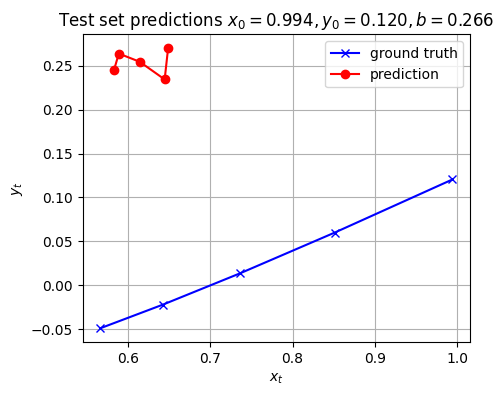

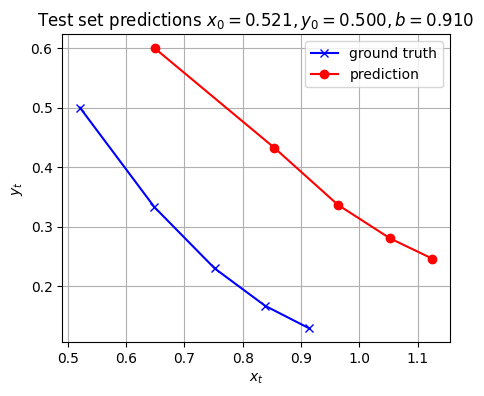

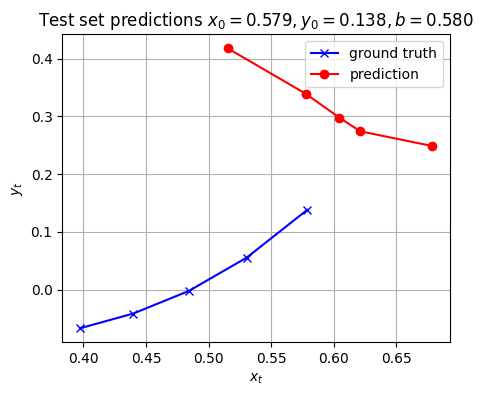

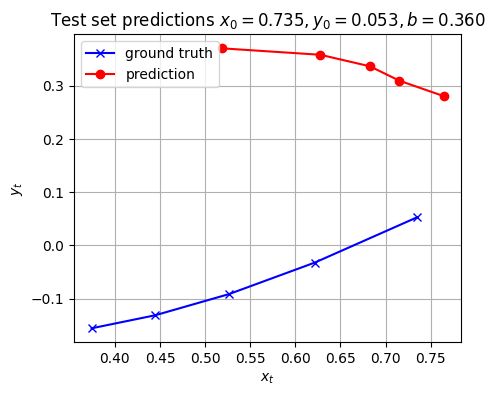

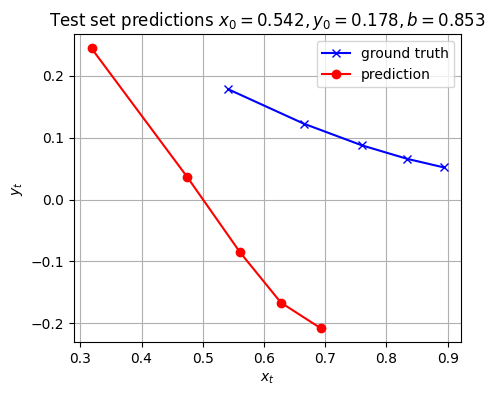


Train set predictions:


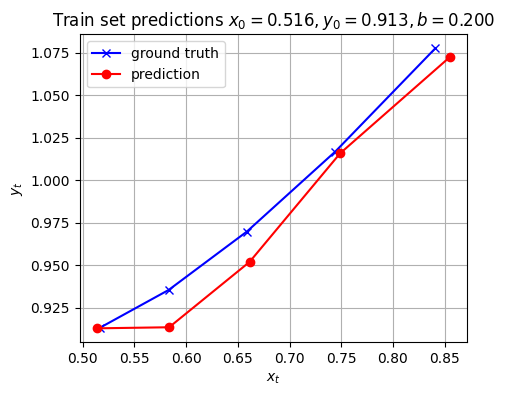

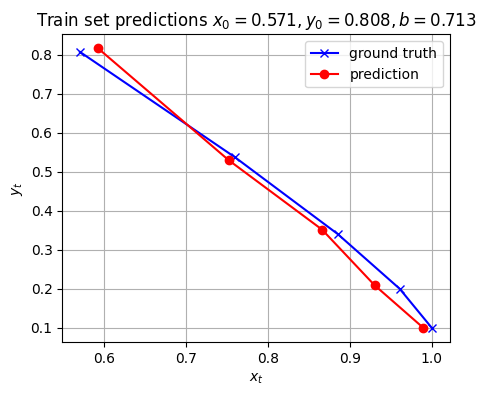

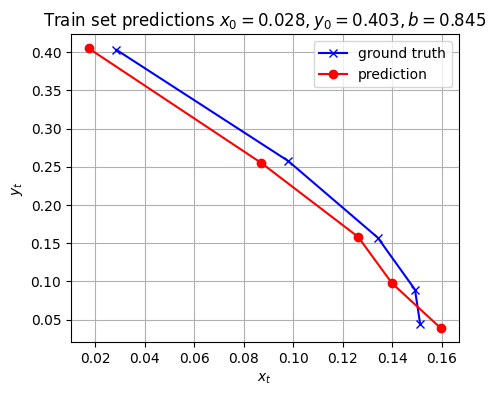

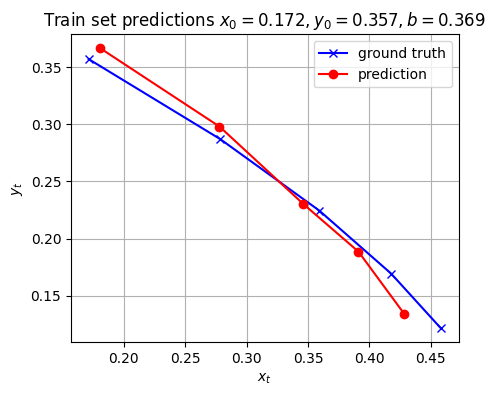

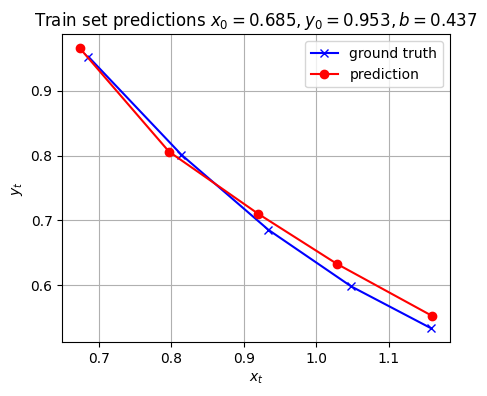


Evaluating test set performance:
Overall R2-Score (test_dataset): -0.9549047946929932

Evaluating train set performance:
Overall R2-Score (train_dataset): 0.9981940388679504


In [80]:
#Scenario 1: Dampened Pendulum
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

# Implementation of custom LBFGS optimizer to match the one used in file 2
class LBFGS(optim.LBFGS):
    def __init__(self, params, lr=1, history_size=10, **kwargs):
        super().__init__(params, lr=lr, history_size=history_size, **kwargs)

# Now let's implement the ODE learning code

# Set up device
device = "cpu"

# Define dataset parameters
s_size = 30

# Sample input data
x_sample = torch.tensor(np.random.uniform(0, 1, size=s_size), dtype=torch.float32, device=device)
y_sample = torch.tensor(np.random.uniform(0, 1, size=s_size), dtype=torch.float32, device=device)
z_sample = torch.tensor(np.random.uniform(0, 1, size=s_size), dtype=torch.float32, device=device)
a_sample = torch.tensor(np.random.uniform(0, 1, size=s_size), dtype=torch.float32, device=device)
b_sample = torch.tensor(np.random.uniform(0, 1, size=s_size), dtype=torch.float32, device=device)
c_sample = torch.tensor(np.random.uniform(0, 1, size=s_size), dtype=torch.float32, device=device)
d_sample = torch.tensor(np.random.uniform(0, 1, size=s_size), dtype=torch.float32, device=device)

# Define time steps
duration = 1
time_interval = 0.2
steps = int(duration / time_interval)
print(f"Number of steps: {steps}")
t_eval = torch.linspace(0, duration, steps=int(steps))

# Create dataset
dataset = torch.stack([x_sample, y_sample, z_sample, a_sample, b_sample, c_sample, d_sample], dim=1).to(device)
dataset = dataset.repeat_interleave(steps, dim=0)
t_eval_set = t_eval.T.repeat(s_size).view(-1, 1).to(device)

dataset = torch.cat([t_eval_set, dataset], dim=1)
dataset.requires_grad = True
print(f"Dataset shape: {dataset.shape}")

# Split into train and test
test_size = 5
test_dataset = dataset[(s_size-test_size)*steps:]
dataset = dataset[:(s_size-test_size)*steps]
print(f"Train dataset shape: {dataset.shape}, Test dataset shape: {test_dataset.shape}")

# Define the Jacobian computation function
def compute_jacobian(model, x):
    def ret_sum(x):
        return model(x)
    jacb = autograd.functional.jacobian(ret_sum, x, create_graph=True)  # Compute the jacobian
    jacb = jacb[:, :, :, 0]  # only get the d/dt for the output vars
    jacb = jacb.sum(dim=-1).unsqueeze(-1)  # sum across the final axis and reshape
    return jacb

# Define the ODE computation function
def compute_ode(y_pred, x):
    def ode(init_cond, a, b, c, d):
        return -a*init_cond[:, 0] + b*init_cond[:, 1] + c*init_cond[:, 2], \
               (d - a)*init_cond[:, 0] - 2*b*init_cond[:, 1], \
               d*init_cond[:, 0] + b*init_cond[:, 1] - c*init_cond[:, 2]

    grad = ode(y_pred, x[:, 4], x[:, 5], x[:, 6], x[:, 7])  # Compute the ddt through the ODE
    grad = torch.tensor([[dxdt, dydt, dzdt] for dxdt, dydt, dzdt in zip(grad[0], grad[1], grad[2])], 
                        device=device).unsqueeze(-1)  # reshape tensor
    return grad

# Compute forward integrals using scipy
def compute_forward_integrals(dataset, duration, t_eval):
    def system_cont(t, x, a, b, c, d):
        dxdt = [-a*x[0] + b*x[1] + c*x[2], 
                (d - a)*x[0] - 2*b*x[1], 
                d*x[0] + b*x[1] - c*x[2]]
        return dxdt 
    
    sol_set = []
    for init_cond in dataset.detach().cpu().numpy():
        t, x0, y0, z0, a, b, c, d = init_cond[0], init_cond[1], init_cond[2], init_cond[3], \
                                    init_cond[4], init_cond[5], init_cond[6], init_cond[7]
        sol = sc.integrate.solve_ivp(system_cont, [0, duration], (x0, y0, z0), 
                                     args=(a, b, c, d), t_eval=t_eval)
        sol_set.extend(np.array(sol.y.T))
    
    sol_set = torch.tensor(np.array(sol_set), dtype=torch.float32, device=device)
    return sol_set

# Define the ODE residual loss function
def ode_residuals(model, coords, steps, duration, t_eval, alpha=1.0, beta=1.0, gamma=1.0):
    coords = coords.clone().detach().requires_grad_(True)

    # Compute integral points through time
    y_pred = model(coords)  # shape: nsamplex3x1
    y_gt = compute_forward_integrals(coords[::steps], duration, t_eval)  # shape: nsamplex3x1

    # Compute gradients
    kan_autograd = compute_jacobian(model, coords)  # shape: nsamplex3x1
    kan_ode_grad = compute_ode(y_pred, coords)  # shape: nsamplex3x1

    # Compute initial points in space
    init_kan_grad = y_pred[::steps]  # shape: s_sizex3
    init_ode_grad = coords[::steps][:, 1:4]  # shape: s_sizex3

    # Compute loss components
    dyn_loss = torch.mean((kan_autograd - kan_ode_grad)**2)
    integral_loss = torch.mean((y_pred - y_gt)**2)
    init_loss = torch.mean((init_kan_grad - init_ode_grad)**2)
    
    # Combine losses
    batch_loss = alpha*dyn_loss + beta*integral_loss + gamma*init_loss
    
    return batch_loss

# Create FastKAN model 
# The width corresponds to [input_dim, hidden_dim, output_dim]
model_scenario1 = FastKAN(
    layers_hidden=[8, 24, 3],  # 8 inputs, 24 hidden units, 3 outputs
    grid_min=-2.0,
    grid_max=2.0,
    num_grids=15,  # Matching the 'grid=15' parameter
    use_base_update=False,
    use_layernorm=False
)
model_scenario1.to(device)

# Verify Jacobian shape (for debugging)
print(f"Jacobian shape: {compute_jacobian(model_scenario1, dataset).shape}")

# Training function
def train(model, iterations=2):
    # Using Adam instead of LBFGS for simplicity in this implementation
    # You could also use optim.LBFGS directly
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    for i in range(iterations):
        optimizer.zero_grad()
        loss = ode_residuals(model, dataset, steps, duration, t_eval)
        loss.backward()
        optimizer.step()
        
        if i % 1 == 0:
            print(f"Iteration {i}, Loss: {loss.item()}")
    
    return model

# Function to run ODE system for visualization
def system_eq_dis(cond_input, t_eval, time):
    def system_cont(t, x, a, b, c, d):
        dxdt = [-a*x[0] + b*x[1] + c*x[2], 
                (d - a)*x[0] - 2*b*x[1], 
                d*x[0] + b*x[1] - c*x[2]]
        return dxdt
    
    x0, y0, z0, a, b, c, d = cond_input
    sol = sc.integrate.solve_ivp(system_cont, [0, time], (x0, y0, z0), 
                                args=(a, b, c, d), t_eval=t_eval)
    return sol.y.T, sol.t.T

# Train the model
print("Training model...")
model_scenario1 = train(model_scenario1, iterations=100)  # Increased iterations for better convergence

# Visualize test set results
print("\nTest set predictions:")
for k in range(0, 5):
    plt.figure(figsize=[5,4])
    sol, t_h = system_eq_dis(test_dataset[int(steps)*k, 1:].detach().cpu(), t_eval, duration)
    plt.plot(sol[:, 0], sol[:, 1], c='b', marker='x', label='ground truth')
    
    y_pred = model_scenario1(test_dataset[int(steps)*k:int(steps)*(k+1)]).detach().cpu().numpy()
    plt.plot(y_pred[:, 0], y_pred[:, 1], c='r', marker='o', label='prediction')
    
    plt.grid()
    x0, y0, z0, a, b, c, d = test_dataset[int(steps)*k, 1:].detach().cpu().numpy()
    plt.title(f"Test set predictions $x_0={x0:.3f}, y_0={y0:.3f}, b={b:.3f}$")
    plt.xlabel(r"$x_t$")
    plt.ylabel(r"$y_t$")
    plt.legend()
    plt.show()

# Visualize train set results
print("\nTrain set predictions:")
for k in range(0, 5):
    plt.figure(figsize=[5,4])
    sol, t_h = system_eq_dis(dataset[int(steps)*k, 1:].detach().cpu(), t_eval, duration)
    plt.plot(sol[:, 0], sol[:, 1], c='b', marker='x', label='ground truth')
    
    y_pred = model_scenario1(dataset[int(steps)*k:int(steps)*(k+1)]).detach().cpu().numpy()
    plt.plot(y_pred[:, 0], y_pred[:, 1], c='r', marker='o', label='prediction')
    
    plt.grid()
    x0, y0, z0, a, b, c, d = dataset[int(steps)*k, 1:].detach().cpu().numpy()
    plt.title(f"Train set predictions $x_0={x0:.3f}, y_0={y0:.3f}, b={b:.3f}$")
    plt.xlabel(r"$x_t$")
    plt.ylabel(r"$y_t$")
    plt.legend()
    plt.show()

# Compute error metrics on test set
print("\nEvaluating test set performance:")
sol_map = []
for init_conds in test_dataset[::steps].detach().cpu().numpy():
    sol, _ = system_eq_dis(init_conds[1:], t_eval, duration)
    sol_map.extend(sol)

np.savetxt('groundtruths_test.txt', sol_map, fmt='%f')
pred = model_scenario1(test_dataset).detach().cpu().numpy()
res_score = r2_score(sol_map, pred)
print(f"Overall R2-Score (test_dataset): {res_score}")
np.savetxt('predictions_test.txt', pred, fmt='%f')

# Compute error metrics on train set
print("\nEvaluating train set performance:")
sol_map = []
for init_conds in dataset[::steps].detach().cpu().numpy():
    sol, _ = system_eq_dis(init_conds[1:], t_eval, duration)
    sol_map.extend(sol)

np.savetxt('groundtruths_train.txt', sol_map, fmt='%f')
pred = model_scenario1(dataset).detach().cpu().numpy()
res_score = r2_score(sol_map, pred)
print(f"Overall R2-Score (train_dataset): {res_score}")
np.savetxt('predictions_train.txt', pred, fmt='%f')

# Evaluating test set performance:
# Overall R2-Score (test_dataset): 0.36257079243659973

# Evaluating train set performance:
# Overall R2-Score (train_dataset): 0.9957847595214844

Steps: 5
Dataset shape: torch.Size([250, 4])
Train dataset shape: torch.Size([225, 4]), Test dataset shape: torch.Size([25, 4])
Starting training...
Iteration 0, Loss: 0.017182394862174988
Iteration 1, Loss: 0.003437652252614498
Iteration 2, Loss: 0.0012155956355854869
Iteration 3, Loss: 0.000693032459821552
Iteration 4, Loss: 0.00042707513784989715

Test set predictions:


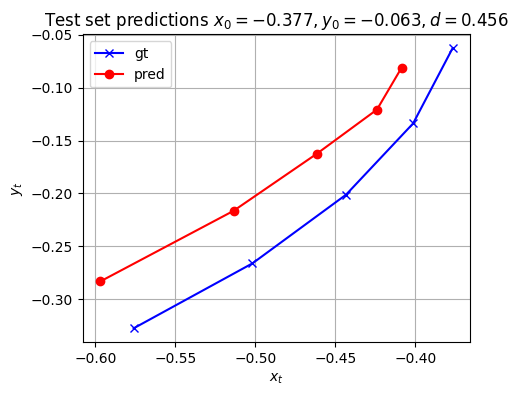

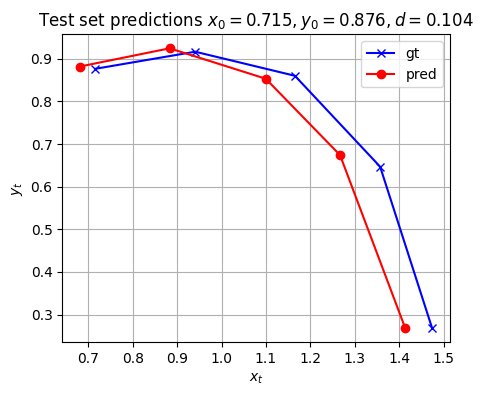


Train set predictions:


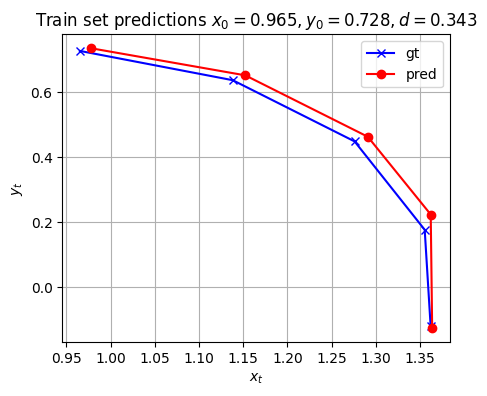

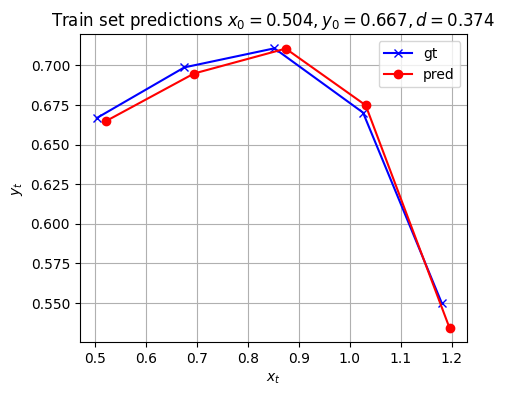


Computing error metrics on test set:
Overall R2-Score (test dataset): 0.9940569400787354

Computing error metrics on train set:
Overall R2-Score (train dataset): 0.9994692802429199


In [81]:
# Scenario 2: Duffing Oscillator 
import numpy as np
import sympy as sp
import scipy as sc
import matplotlib.pyplot as plt
import torch
import random
import warnings
from torch import autograd
from tqdm import tqdm
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import r2_score
import optuna
warnings.filterwarnings("ignore")

# Import the FastKAN implementation
from torch import nn
import torch.nn.functional as F
import math
from typing import *
    
# LBFGS optimizer similar to what was used in the original
class LBFGS(torch.optim.LBFGS):
    def __init__(self, params, lr=1, history_size=10, tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32):
        super().__init__(params, lr=lr, history_size=history_size, tolerance_grad=tolerance_grad, 
                         tolerance_change=tolerance_change)
        self.tolerance_ys = tolerance_ys

# The ODE we are trying to learn is the Van der Pol Oscillator
# Define device
device = "cpu"

# Sample size
s_size = 50

# Create random samples for initial conditions and parameters
x_sample = np.random.uniform(-1, 1, size=s_size)
y_sample = np.random.uniform(-1, 1, size=s_size)
d_sample = np.random.uniform(0.1, 0.5, size=s_size)
x_sample = torch.tensor(x_sample, dtype=torch.float32, device=device)
y_sample = torch.tensor(y_sample, dtype=torch.float32, device=device)
d_sample = torch.tensor(d_sample, dtype=torch.float32, device=device)

# Time parameters
duration = 1
time_interval = 0.2
steps = int(duration / time_interval)
print(f"Steps: {steps}")
t_eval = torch.linspace(0, duration, steps=steps)

# Create the dataset for the model
dataset = torch.stack([x_sample, y_sample, d_sample], dim=1).to(device)
dataset = dataset.repeat_interleave(steps, dim=0)
t_eval_set = t_eval.T.repeat(s_size).view(-1, 1).to(device)

dataset = torch.cat([t_eval_set, dataset], dim=1)
dataset.requires_grad = True
print(f"Dataset shape: {dataset.shape}")

# Create test and train datasets
test_size = 5
test_dataset = dataset[(s_size-test_size)*steps:]
dataset = dataset[:(s_size-test_size)*steps]
print(f"Train dataset shape: {dataset.shape}, Test dataset shape: {test_dataset.shape}")

# Function to compute the Jacobian (time derivative)
def compute_jacobian(model, x):
    def ret_sum(x):
        return model(x)
    jacb = autograd.functional.jacobian(ret_sum, x, create_graph=True)  # Compute the jacobian across all input variables and output vars
    jacb = jacb[:, :, :, 0]  # only get the d/dt for the output vars
    jacb = jacb.sum(dim=-1).unsqueeze(-1)  # sum across the final axis and reshape to 1 vector
    return jacb

# Function to compute the ODE using the output of the FastKAN
def compute_ode(y_pred, x):
    def ode(init_cond, d):
        return init_cond[:, 1], init_cond[:, 0] - init_cond[:, 0]**3 - d*init_cond[:, 1]

    grad = ode(y_pred, x[:, 3])  # Compute the ddt through the ODE for the output of the model
    grad = torch.tensor([[dxdt, dydt] for dxdt, dydt in zip(grad[0], grad[1])], device=device).unsqueeze(-1)  # reshape tensor to match the jacobian tensors
    return grad

# Function to compute the forward integrals using scipy
def compute_forward_integrals(dataset, duration, t_eval):
    def system_cont(t, x, d):
        dxdt = [x[1], x[0] - x[0]**3 - d*x[1]]
        return dxdt 
    
    sol_set = []
    for init_cond in dataset.detach().cpu().numpy():
        t, x0, y0, d = init_cond[0], init_cond[1], init_cond[2], init_cond[3]
        sol = sc.integrate.solve_ivp(system_cont, [0, duration], (x0, y0), args=(d,), t_eval=t_eval)
        sol_set.extend(np.array(sol.y.T))
    
    sol_set = torch.tensor(np.array(sol_set), dtype=torch.float32, device=device)
    return sol_set

# Define the ODE residuals function (loss function)
def ode_residuals(model, coords, steps, duration, t_eval, alpha=1.0, beta=1.0, gamma=1.0):
    coords = coords.clone().detach().requires_grad_(True)

    # Compute integral points through time
    y_pred = model(coords)  # shape: nsamplex2
    y_gt = compute_forward_integrals(coords[::steps], duration, t_eval.cpu().numpy())  # shape: nsamplex2

    # Compute gradients
    kan_autograd = compute_jacobian(model, coords)  # shape: nsamplex2x1
    kan_ode_grad = compute_ode(y_pred, coords)  # shape: nsamplex2x1

    # Compute initial points in space
    init_kan_grad = y_pred[::steps]  # shape: s_sizex2
    init_ode_grad = coords[::steps][:, 1:3]  # shape: s_sizex2

    # Compute the loss of the dynamics
    dyn_loss = torch.mean((kan_autograd - kan_ode_grad)**2)
    # Compute the loss of the integral points through time
    integral_loss = torch.mean((y_pred - y_gt)**2)
    # Compute the loss of the initial condition
    init_loss = torch.mean((init_kan_grad - init_ode_grad)**2)
    
    batch_loss = alpha*dyn_loss + beta*integral_loss + beta*init_loss

    return batch_loss

# Create the FastKAN model - using similar architecture as in the original KAN implementation
model_scenario2 = FastKAN(layers_hidden=[4, 15, 2], grid_min=-2., grid_max=2., num_grids=15, use_base_update = False, use_layernorm=False)

# Train the model
def train(model):
    optimizer = LBFGS(model.parameters(), lr=1, history_size=10, tolerance_grad=1e-32, 
                     tolerance_change=1e-32, tolerance_ys=1e-32)
    
    iter_ = 5
    for i in range(iter_):
        def closure():
            optimizer.zero_grad()
            loss = ode_residuals(model, dataset, steps, duration, t_eval, alpha=0.2, beta=0.6, gamma=0.2)
            loss.backward()
            return loss
        optimizer.step(closure)
        if i % 1 == 0:
            current_loss = closure().item()
            print(f"Iteration {i}, Loss: {current_loss}")

print("Starting training...")
train(model_scenario2)

# Function to create solution trajectories for visualization
def system_eq_dis(cond_input, t_eval, time):
    def system_cont(t, x, d):
        dxdt = [x[1], x[0] - x[0]**3 - d*x[1]]
        return dxdt
    x0, y0, d = cond_input
    sol = sc.integrate.solve_ivp(system_cont, [0, time], (x0, y0), args=(d,), t_eval=t_eval)
    return sol.y.T, sol.t.T

# Visualize the performance on test set
print("\nTest set predictions:")
for k in range(0, 2):
    plt.figure(figsize=[5, 4])
    sol, t_h = system_eq_dis(test_dataset[int(steps)*k, 1:4].detach().cpu(), t_eval.numpy(), duration)
    plt.plot(sol[:, 0], sol[:, 1], c='b', marker='x', label='gt')
    y_pred = model_scenario2(test_dataset[int(steps)*k:int(steps)*(k+1)]).detach().cpu().numpy()
    plt.plot(y_pred[:, 0], y_pred[:, 1], c='r', marker='o', label='pred')
    plt.grid()
    x0, y0, d = test_dataset[int(steps)*k, 1:4].detach().numpy()
    plt.title(f"Test set predictions $x_0={x0:.3f}, y_0={y0:.3f}, d={d:.3f}$")
    plt.xlabel(r"$x_t$")
    plt.ylabel(r"$y_t$")
    plt.legend()
    plt.show()  # Display in notebook instead of saving

# Visualize the performance on train set
print("\nTrain set predictions:")
for k in range(0, 2):
    plt.figure(figsize=[5, 4])
    sol, t_h = system_eq_dis(dataset[int(steps)*k, 1:4].detach().cpu(), t_eval.numpy(), duration)
    plt.plot(sol[:, 0], sol[:, 1], c='b', marker='x', label='gt')
    y_pred = model_scenario2(dataset[int(steps)*k:int(steps)*(k+1)]).detach().cpu().numpy()
    plt.plot(y_pred[:, 0], y_pred[:, 1], c='r', marker='o', label='pred')
    x0, y0, d = dataset[int(steps)*k, 1:4].detach().numpy()
    plt.title(f"Train set predictions $x_0={x0:.3f}, y_0={y0:.3f}, d={d:.3f}$")
    plt.xlabel(r"$x_t$")
    plt.ylabel(r"$y_t$")
    plt.grid()
    plt.legend()
    plt.show()  # Display in notebook instead of saving

# Compute error metrics on test set
print("\nComputing error metrics on test set:")
sol_map = []
for init_conds in test_dataset[::steps].detach().cpu().numpy():
    sol, _ = system_eq_dis(init_conds[1:], t_eval.numpy(), duration)
    sol_map.extend(sol)

np.savetxt('groundtruths_test_fastkan.txt', sol_map, fmt='%f')
pred = model_scenario2(test_dataset).detach().numpy()
res_score = r2_score(sol_map, pred)
print(f"Overall R2-Score (test dataset): {res_score}")
np.savetxt('predictions_test_fastkan.txt', pred, fmt='%f')

# Compute error metrics on train set
print("\nComputing error metrics on train set:")
sol_map = []
for init_conds in dataset[::steps].detach().cpu().numpy():
    sol, _ = system_eq_dis(init_conds[1:], t_eval.numpy(), duration)
    sol_map.extend(sol)

np.savetxt('groundtruths_train_fastkan.txt', sol_map, fmt='%f')
pred = model_scenario2(dataset).detach().numpy()
res_score = r2_score(sol_map, pred)
print(f"Overall R2-Score (train dataset): {res_score}")
np.savetxt('predictions_train_fastkan.txt', pred, fmt='%f')

# Good

Using device: cpu
Number of time steps: 5
Dataset shape: torch.Size([150, 7])
Train dataset shape: torch.Size([125, 7]), Test dataset shape: torch.Size([25, 7])
Starting training...
Epoch 1/10, Loss: 0.00689089
Epoch 2/10, Loss: 0.00160145
Epoch 3/10, Loss: 0.00056075
Epoch 4/10, Loss: 0.00027676
Epoch 5/10, Loss: 0.00014793
Epoch 6/10, Loss: 0.00009477
Epoch 7/10, Loss: 0.00006379
Epoch 8/10, Loss: 0.00004096
Epoch 9/10, Loss: 0.00002693
Epoch 10/10, Loss: 0.00002017

Evaluating on test set...
Test R2-Score: 0.895213

Evaluating on train set...
Train R2-Score: 0.999960

Visualizing test set predictions...


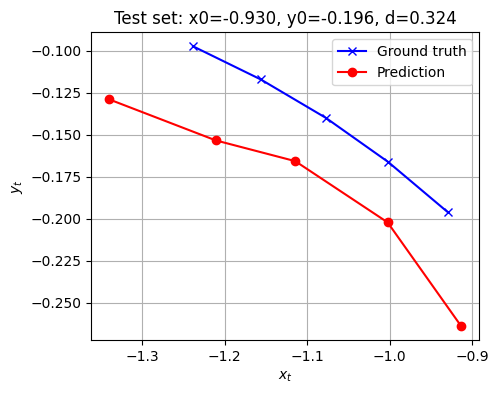

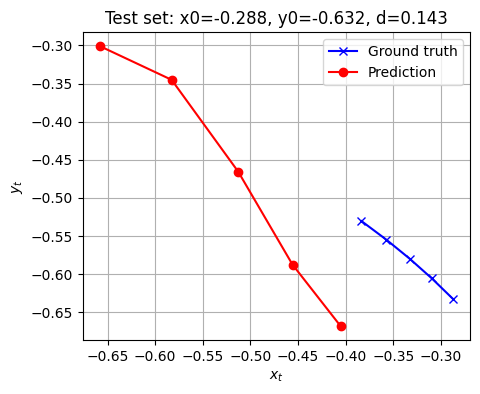

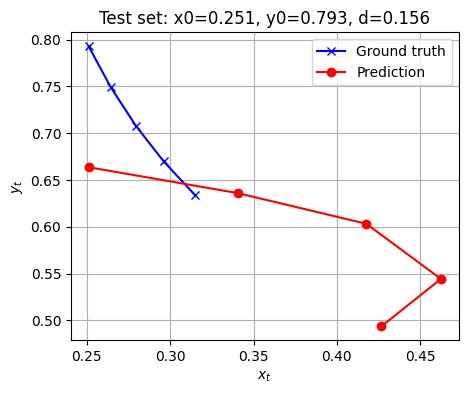

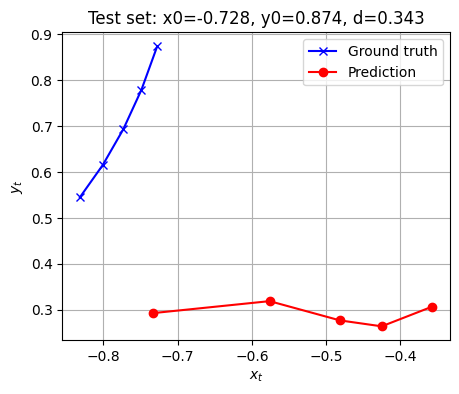

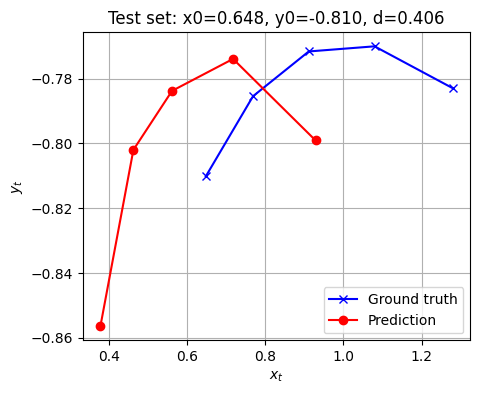


Visualizing train set predictions...


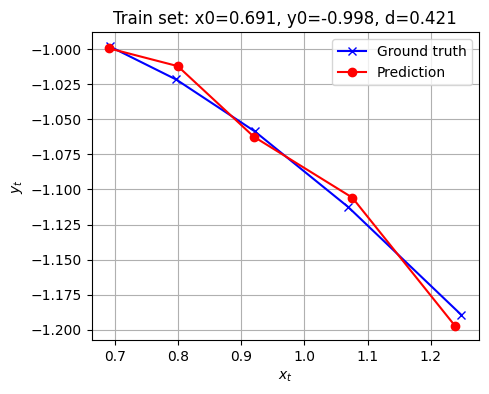

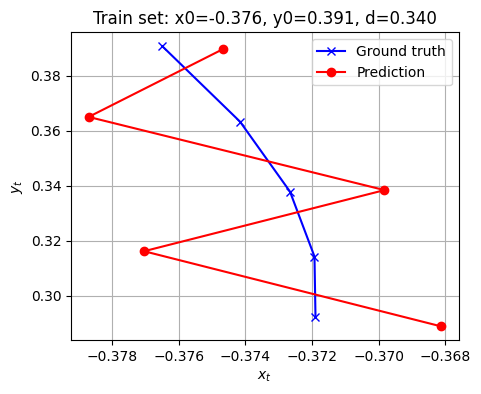

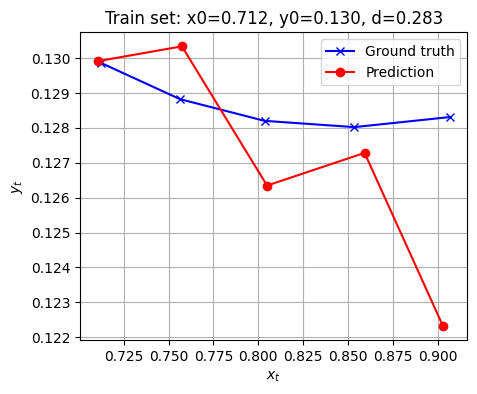

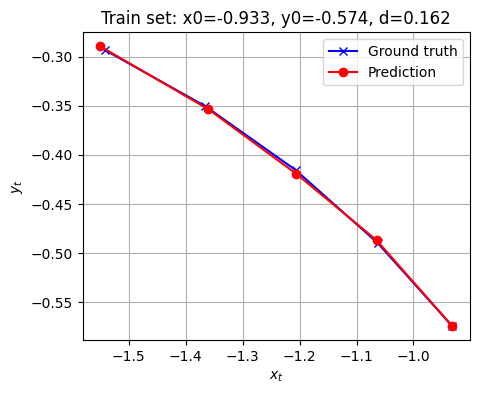

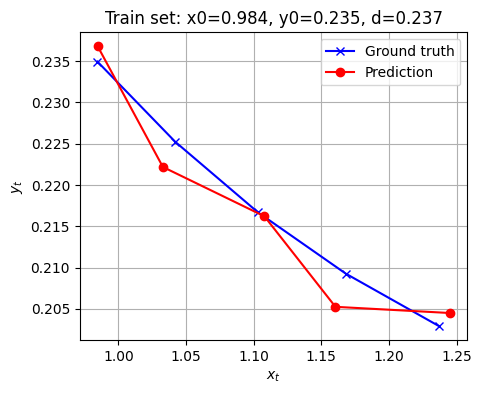

In [82]:
#Scenario 3: PiKAN-Lotka-Volterra.ipynb
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm
from sklearn.metrics import r2_score
import scipy as sc
import warnings
warnings.filterwarnings("ignore")

def compute_jacobian(model, x):
    """Returns the d/dt jacobian of the values computed by FastKAN"""
    def ret_sum(x):
        return model(x)
    
    jacb = autograd.functional.jacobian(ret_sum, x, create_graph=True)  # Compute the jacobian
    jacb = jacb[:, :, :, 0]  # only get the d/dt for the output vars
    jacb = jacb.sum(dim=-1).unsqueeze(-1)  # reshape to match dimension
    return jacb

def compute_ode(y_pred, x):
    """Computes the ODE using the output of the FastKAN"""
    def ode(init_cond, a, b, c, d):
        return (
            init_cond[:, 0]*a - init_cond[:, 0]*init_cond[:, 1]*b, 
            -init_cond[:, 1]*c + init_cond[:, 0]*init_cond[:, 1]*d
        )

    # Compute the ddt through the ODE for the output of the KAN
    grad = ode(y_pred, x[:, 3], x[:, 4], x[:, 5], x[:, 6])
    # Reshape tensor to match the jacobian tensors
    grad = torch.stack([grad[0], grad[1]], dim=1).unsqueeze(-1)
    return grad

def compute_forward_integrals(dataset, duration, t_eval):
    """Compute the forward derivative in time for each value in initial condition set"""
    def system_cont(t, x, a, b, c, d):
        dxdt = [x[0]*a - x[0]*x[1]*b, -x[1]*c + x[0]*x[1]*d]
        return dxdt 
    
    sol_set = []
    for init_cond in dataset.detach().cpu().numpy():
        t, x0, y0, a, b, c, d = init_cond[0], init_cond[1], init_cond[2], init_cond[3], init_cond[4], init_cond[5], init_cond[6]
        sol = sc.integrate.solve_ivp(system_cont, [0, duration], (x0, y0), args=(a, b, c, d), t_eval=t_eval)
        sol_set.extend(np.array(sol.y.T))
    
    sol_set = torch.tensor(np.array(sol_set), dtype=torch.float32, device=dataset.device)
    return sol_set

def ode_residuals(model, coords, steps, duration, t_eval, alpha=1.0, beta=1.0, gamma=1.0):
    """Calculate the loss for the ODE model"""
    coords = coords.clone().detach().requires_grad_(True)

    # Compute integral points through time
    y_pred = model(coords)  # shape: nsamplex2x1
    y_gt = compute_forward_integrals(coords[::steps], duration, t_eval)  # shape: nsamplex2

    # Compute gradients
    kan_autograd = compute_jacobian(model, coords)  # shape: nsamplex2x1
    kan_ode_grad = compute_ode(y_pred, coords)  # shape: nsamplex2x1

    # Compute initial points in space
    init_kan_grad = y_pred[::steps]  # shape: s_sizex2
    init_ode_grad = torch.stack([coords[::steps][:, 1], coords[::steps][:, 2]], dim=1)  # shape: s_sizex2

    # Compute the loss of the dynamics
    dyn_loss = torch.mean((kan_autograd - kan_ode_grad)**2)
    # Compute the loss of the integral points through time
    integral_loss = torch.mean((y_pred - y_gt)**2)
    # Compute the loss of the initial condition
    init_loss = torch.mean((init_kan_grad - init_ode_grad)**2)
    
    batch_loss = alpha*dyn_loss + beta*integral_loss + gamma*init_loss

    return batch_loss

def system_eq_dis(cond_input, t_eval, duration):
    """Compute ODE solution for a given initial condition"""
    def system_cont(t, x, a, b, c, d):
        dxdt = [x[0]*a - x[0]*x[1]*b, -x[1]*c + x[0]*x[1]*d]
        return dxdt
        
    x0, y0, a, b, c, d = cond_input
    sol = sc.integrate.solve_ivp(system_cont, [0, duration], (x0, y0), args=(a, b, c, d), t_eval=t_eval)
    return sol.y.T, sol.t.T

def train_fastkan_ode():
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Sample dataset
    s_size = 30
    x_sample = torch.tensor(np.random.uniform(-1, 1, size=s_size), dtype=torch.float32, device=device)
    y_sample = torch.tensor(np.random.uniform(-1, 1, size=s_size), dtype=torch.float32, device=device)
    a_sample = torch.tensor(np.random.uniform(0.1, 0.5, size=s_size), dtype=torch.float32, device=device)
    b_sample = torch.tensor(np.random.uniform(0.1, 0.5, size=s_size), dtype=torch.float32, device=device)
    c_sample = torch.tensor(np.random.uniform(0.1, 0.5, size=s_size), dtype=torch.float32, device=device)
    d_sample = torch.tensor(np.random.uniform(0.1, 0.5, size=s_size), dtype=torch.float32, device=device)

    # Time span
    duration = 1
    time_interval = 0.2
    steps = int(duration / time_interval)
    t_eval = torch.linspace(0, duration, steps=int(steps))
    print(f"Number of time steps: {steps}")

    # Create the dataset
    dataset = torch.stack([x_sample, y_sample, a_sample, b_sample, c_sample, d_sample], dim=1).to(device)
    dataset = dataset.repeat_interleave(steps, dim=0)
    t_eval_set = t_eval.T.repeat(s_size).view(-1, 1).to(device)

    dataset = torch.cat([t_eval_set, dataset], dim=1)
    dataset.requires_grad = True
    print(f"Dataset shape: {dataset.shape}")

    # Split into train/test
    test_size = 5
    test_dataset = dataset[(s_size-test_size)*steps:]
    train_dataset = dataset[:(s_size-test_size)*steps]
    print(f"Train dataset shape: {train_dataset.shape}, Test dataset shape: {test_dataset.shape}")

    # Create the FastKAN model
    model = FastKAN(
        layers_hidden=[7, 24, 2],  # 7 inputs, 24 hidden, 2 outputs (like in file 2)
        grid_min=-2.0,
        grid_max=2.0,
        num_grids=15,  # Using 15 grids like in file 2
        use_base_update=False,
        use_layernorm=False
    ).to(device)
    
    # Train the model
    optimizer = optim.LBFGS(model.parameters(), 
                           lr=1, 
                           max_iter=20,
                           max_eval=25, 
                           tolerance_grad=1e-7,
                           tolerance_change=1e-9,
                           history_size=10)

    print("Starting training...")
    iter_ = 10
    for epoch in range(iter_):
        def closure():
            optimizer.zero_grad()
            loss = ode_residuals(model, train_dataset, steps, duration, t_eval.numpy(), 
                               alpha=0.2, beta=0.6, gamma=0.2)
            loss.backward()
            return loss
        
        optimizer.step(closure)
        current_loss = closure().item()
        print(f"Epoch {epoch+1}/{iter_}, Loss: {current_loss:.8f}")

    # Evaluate on test set
    print("\nEvaluating on test set...")
    # Calculate ground truth for test set
    sol_map_test = []
    for init_conds in test_dataset[::steps].detach().cpu().numpy():
        sol, _ = system_eq_dis(init_conds[1:], t_eval.numpy(), duration)
        sol_map_test.extend(sol)

    # Get predictions
    with torch.no_grad():
        pred_test = model(test_dataset).detach().cpu().numpy()
    
    # Calculate R2 score
    res_score_test = r2_score(sol_map_test, pred_test)
    print(f"Test R2-Score: {res_score_test:.6f}")

    # Evaluate on train set
    print("\nEvaluating on train set...")
    # Calculate ground truth for train set
    sol_map_train = []
    for init_conds in train_dataset[::steps].detach().cpu().numpy():
        sol, _ = system_eq_dis(init_conds[1:], t_eval.numpy(), duration)
        sol_map_train.extend(sol)

    # Get predictions
    with torch.no_grad():
        pred_train = model(train_dataset).detach().cpu().numpy()
    
    # Calculate R2 score
    res_score_train = r2_score(sol_map_train, pred_train)
    print(f"Train R2-Score: {res_score_train:.6f}")

    # Save predictions
    np.savetxt('groundtruths_test.txt', sol_map_test, fmt='%f')
    np.savetxt('predictions_test.txt', pred_test, fmt='%f')
    np.savetxt('groundtruths_train.txt', sol_map_train, fmt='%f')
    np.savetxt('predictions_train.txt', pred_train, fmt='%f')

    # Visualize results
    print("\nVisualizing test set predictions...")
    for k in range(min(5, test_size)):
        plt.figure(figsize=[5, 4])
        sol, _ = system_eq_dis(test_dataset[int(steps)*k, 1:7].detach().cpu().numpy(), t_eval.numpy(), duration)
        plt.plot(sol[:, 0], sol[:, 1], c='b', marker='x', label='Ground truth')
        
        y_pred = model(test_dataset[int(steps)*k:int(steps)*(k+1)]).detach().cpu().numpy()
        plt.plot(y_pred[:, 0], y_pred[:, 1], c='r', marker='o', label='Prediction')
        
        x0, y0, a, b, c, d = test_dataset[int(steps)*k, 1:7].detach().cpu().numpy()
        plt.title(f"Test set: x0={x0:.3f}, y0={y0:.3f}, d={d:.3f}")
        plt.xlabel(r"$x_t$")
        plt.ylabel(r"$y_t$")
        plt.grid()
        plt.legend()
        plt.show()

    print("\nVisualizing train set predictions...")
    for k in range(min(5, s_size-test_size)):
        plt.figure(figsize=[5, 4])
        sol, _ = system_eq_dis(train_dataset[int(steps)*k, 1:7].detach().cpu().numpy(), t_eval.numpy(), duration)
        plt.plot(sol[:, 0], sol[:, 1], c='b', marker='x', label='Ground truth')
        
        y_pred = model(train_dataset[int(steps)*k:int(steps)*(k+1)]).detach().cpu().numpy()
        plt.plot(y_pred[:, 0], y_pred[:, 1], c='r', marker='o', label='Prediction')
        
        x0, y0, a, b, c, d = train_dataset[int(steps)*k, 1:7].detach().cpu().numpy()
        plt.title(f"Train set: x0={x0:.3f}, y0={y0:.3f}, d={d:.3f}")
        plt.xlabel(r"$x_t$")
        plt.ylabel(r"$y_t$")
        plt.grid()
        plt.legend()
        plt.show()

    return model

if __name__ == "__main__":
    model_scenario3 = train_fastkan_ode()

# Evaluating on test set...
# Test R2-Score: 0.942015

# Evaluating on train set...
# Train R2-Score: 0.999969

Number of steps: 5
Dataset shape: torch.Size([150, 8])
Train dataset shape: torch.Size([125, 8]), Test dataset shape: torch.Size([25, 8])
Jacobian shape: torch.Size([125, 3, 1])
Training model...
Iteration 0, Loss: 2.61112380027771
Iteration 1, Loss: 0.960966944694519
Iteration 2, Loss: 1.2271260023117065
Iteration 3, Loss: 1.1268559694290161
Iteration 4, Loss: 0.7567413449287415
Iteration 5, Loss: 0.49454933404922485
Iteration 6, Loss: 0.4235752820968628
Iteration 7, Loss: 0.4338703453540802
Iteration 8, Loss: 0.4278568625450134
Iteration 9, Loss: 0.37877464294433594
Iteration 10, Loss: 0.3103039562702179
Iteration 11, Loss: 0.24507509171962738
Iteration 12, Loss: 0.20975661277770996
Iteration 13, Loss: 0.21672239899635315
Iteration 14, Loss: 0.23427575826644897
Iteration 15, Loss: 0.21551544964313507
Iteration 16, Loss: 0.16353711485862732
Iteration 17, Loss: 0.11770074814558029
Iteration 18, Loss: 0.1002812311053276
Iteration 19, Loss: 0.10201242566108704
Iteration 20, Loss: 0.10539

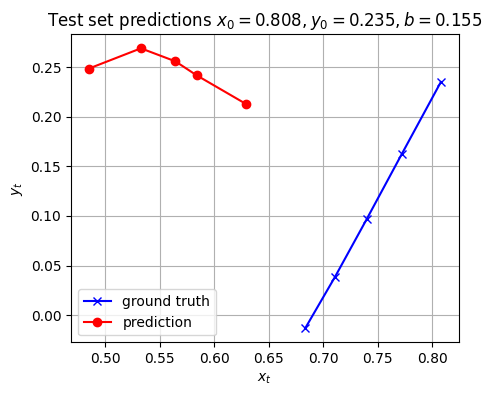

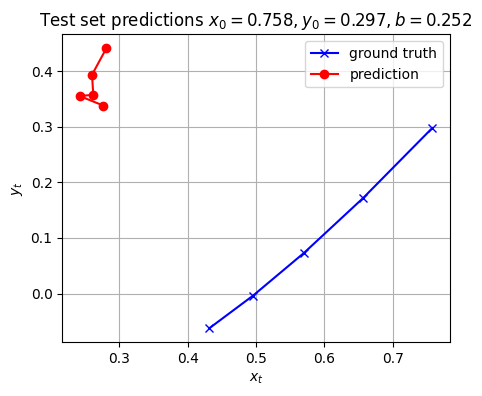

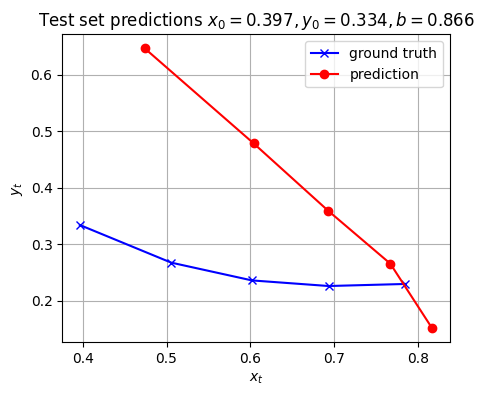

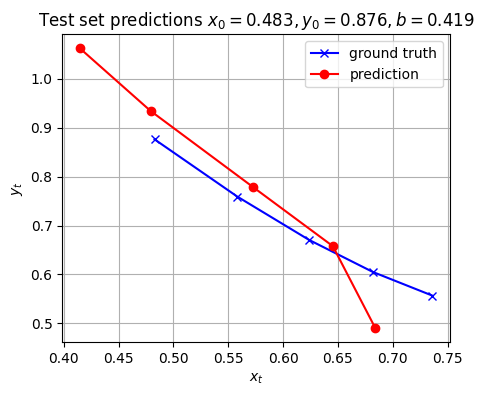

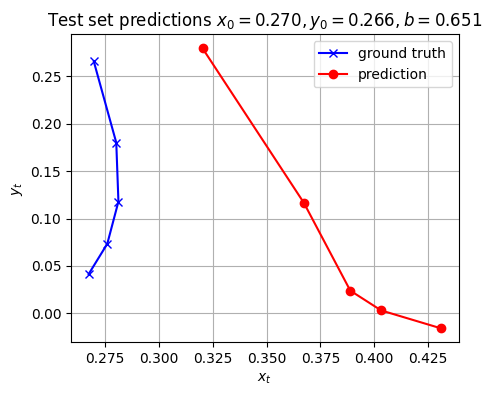


Train set predictions:


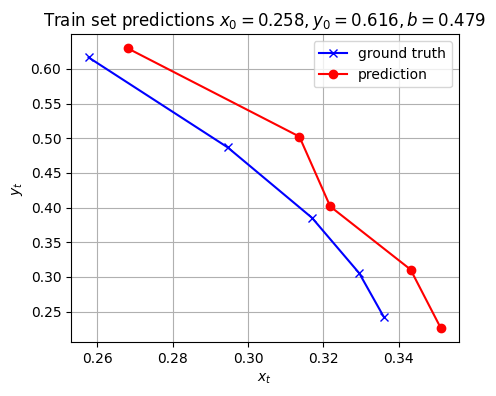

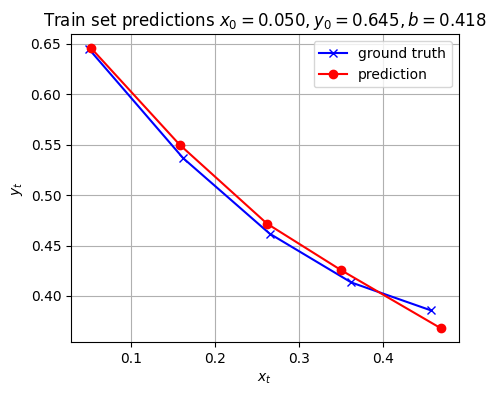

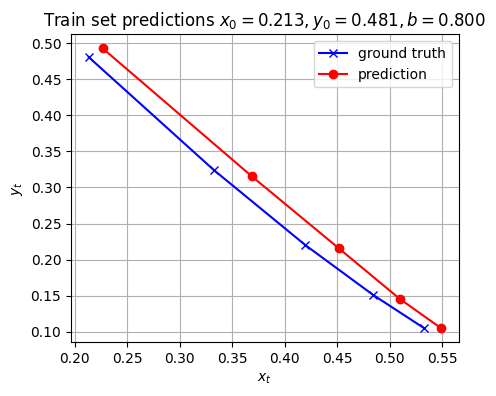

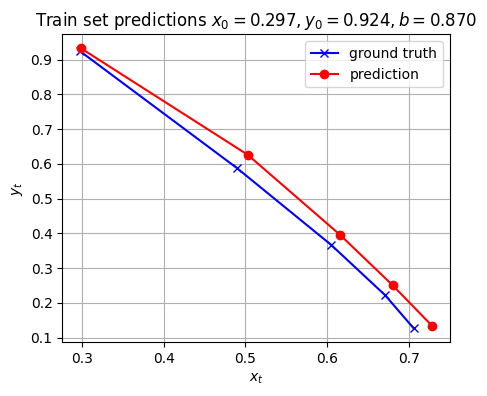

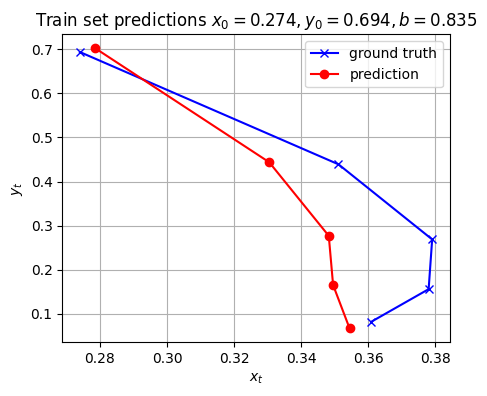


Evaluating test set performance:
Overall R2-Score (test_dataset): 0.33479252457618713

Evaluating train set performance:
Overall R2-Score (train_dataset): 0.9949167370796204


In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

# Implementation of custom LBFGS optimizer to match the one used in file 2
class LBFGS(optim.LBFGS):
    def __init__(self, params, lr=1, history_size=10, **kwargs):
        super().__init__(params, lr=lr, history_size=history_size, **kwargs)

# Now let's implement the ODE learning code

# Set up device
device = "cpu"

# Define dataset parameters
s_size = 30

# Sample input data
x_sample = torch.tensor(np.random.uniform(0, 1, size=s_size), dtype=torch.float32, device=device)
y_sample = torch.tensor(np.random.uniform(0, 1, size=s_size), dtype=torch.float32, device=device)
z_sample = torch.tensor(np.random.uniform(0, 1, size=s_size), dtype=torch.float32, device=device)
a_sample = torch.tensor(np.random.uniform(0, 1, size=s_size), dtype=torch.float32, device=device)
b_sample = torch.tensor(np.random.uniform(0, 1, size=s_size), dtype=torch.float32, device=device)
c_sample = torch.tensor(np.random.uniform(0, 1, size=s_size), dtype=torch.float32, device=device)
d_sample = torch.tensor(np.random.uniform(0, 1, size=s_size), dtype=torch.float32, device=device)

# Define time steps
duration = 1
time_interval = 0.2
steps = int(duration / time_interval)
print(f"Number of steps: {steps}")
t_eval = torch.linspace(0, duration, steps=int(steps))

# Create dataset
dataset = torch.stack([x_sample, y_sample, z_sample, a_sample, b_sample, c_sample, d_sample], dim=1).to(device)
dataset = dataset.repeat_interleave(steps, dim=0)
t_eval_set = t_eval.T.repeat(s_size).view(-1, 1).to(device)

dataset = torch.cat([t_eval_set, dataset], dim=1)
dataset.requires_grad = True
print(f"Dataset shape: {dataset.shape}")

# Split into train and test
test_size = 5
test_dataset = dataset[(s_size-test_size)*steps:]
dataset = dataset[:(s_size-test_size)*steps]
print(f"Train dataset shape: {dataset.shape}, Test dataset shape: {test_dataset.shape}")

# Define the Jacobian computation function
def compute_jacobian(model, x):
    def ret_sum(x):
        return model(x)
    jacb = autograd.functional.jacobian(ret_sum, x, create_graph=True)  # Compute the jacobian
    jacb = jacb[:, :, :, 0]  # only get the d/dt for the output vars
    jacb = jacb.sum(dim=-1).unsqueeze(-1)  # sum across the final axis and reshape
    return jacb

# Define the ODE computation function
def compute_ode(y_pred, x):
    def ode(init_cond, a, b, c, d):
        return -a*init_cond[:, 0] + b*init_cond[:, 1] + c*init_cond[:, 2], \
               (d - a)*init_cond[:, 0] - 2*b*init_cond[:, 1], \
               d*init_cond[:, 0] + b*init_cond[:, 1] - c*init_cond[:, 2]

    grad = ode(y_pred, x[:, 4], x[:, 5], x[:, 6], x[:, 7])  # Compute the ddt through the ODE
    grad = torch.tensor([[dxdt, dydt, dzdt] for dxdt, dydt, dzdt in zip(grad[0], grad[1], grad[2])], 
                        device=device).unsqueeze(-1)  # reshape tensor
    return grad

# Compute forward integrals using scipy
def compute_forward_integrals(dataset, duration, t_eval):
    def system_cont(t, x, a, b, c, d):
        dxdt = [-a*x[0] + b*x[1] + c*x[2], 
                (d - a)*x[0] - 2*b*x[1], 
                d*x[0] + b*x[1] - c*x[2]]
        return dxdt 
    
    sol_set = []
    for init_cond in dataset.detach().cpu().numpy():
        t, x0, y0, z0, a, b, c, d = init_cond[0], init_cond[1], init_cond[2], init_cond[3], \
                                    init_cond[4], init_cond[5], init_cond[6], init_cond[7]
        sol = sc.integrate.solve_ivp(system_cont, [0, duration], (x0, y0, z0), 
                                     args=(a, b, c, d), t_eval=t_eval)
        sol_set.extend(np.array(sol.y.T))
    
    sol_set = torch.tensor(np.array(sol_set), dtype=torch.float32, device=device)
    return sol_set

# Define the ODE residual loss function
def ode_residuals(model, coords, steps, duration, t_eval, alpha=1.0, beta=1.0, gamma=1.0):
    coords = coords.clone().detach().requires_grad_(True)

    # Compute integral points through time
    y_pred = model(coords)  # shape: nsamplex3x1
    y_gt = compute_forward_integrals(coords[::steps], duration, t_eval)  # shape: nsamplex3x1

    # Compute gradients
    kan_autograd = compute_jacobian(model, coords)  # shape: nsamplex3x1
    kan_ode_grad = compute_ode(y_pred, coords)  # shape: nsamplex3x1

    # Compute initial points in space
    init_kan_grad = y_pred[::steps]  # shape: s_sizex3
    init_ode_grad = coords[::steps][:, 1:4]  # shape: s_sizex3

    # Compute loss components
    dyn_loss = torch.mean((kan_autograd - kan_ode_grad)**2)
    integral_loss = torch.mean((y_pred - y_gt)**2)
    init_loss = torch.mean((init_kan_grad - init_ode_grad)**2)
    
    # Combine losses
    batch_loss = alpha*dyn_loss + beta*integral_loss + gamma*init_loss
    
    return batch_loss

# Create FastKAN model 
# The width corresponds to [input_dim, hidden_dim, output_dim]
model_scenario4  = FastKAN(
    layers_hidden=[8, 24, 3],  # 8 inputs, 24 hidden units, 3 outputs
    grid_min=-2.0,
    grid_max=2.0,
    num_grids=15,  # Matching the 'grid=15' parameter
    use_base_update=False,
    use_layernorm=False
)
model_scenario4.to(device)

# Verify Jacobian shape (for debugging)
print(f"Jacobian shape: {compute_jacobian(model_scenario4, dataset).shape}")

# Training function
def train(model, iterations=2):
    # Using Adam instead of LBFGS for simplicity in this implementation
    # You could also use optim.LBFGS directly
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    for i in range(iterations):
        optimizer.zero_grad()
        loss = ode_residuals(model, dataset, steps, duration, t_eval)
        loss.backward()
        optimizer.step()
        
        if i % 1 == 0:
            print(f"Iteration {i}, Loss: {loss.item()}")
    
    return model

# Function to run ODE system for visualization
def system_eq_dis(cond_input, t_eval, time):
    def system_cont(t, x, a, b, c, d):
        dxdt = [-a*x[0] + b*x[1] + c*x[2], 
                (d - a)*x[0] - 2*b*x[1], 
                d*x[0] + b*x[1] - c*x[2]]
        return dxdt
    
    x0, y0, z0, a, b, c, d = cond_input
    sol = sc.integrate.solve_ivp(system_cont, [0, time], (x0, y0, z0), 
                                args=(a, b, c, d), t_eval=t_eval)
    return sol.y.T, sol.t.T

# Train the model
print("Training model...")
model_scenario4 = train(model_scenario4, iterations=80)

# Visualize test set results
print("\nTest set predictions:")
for k in range(0, 5):
    plt.figure(figsize=[5,4])
    sol, t_h = system_eq_dis(test_dataset[int(steps)*k, 1:].detach().cpu(), t_eval, duration)
    plt.plot(sol[:, 0], sol[:, 1], c='b', marker='x', label='ground truth')
    
    y_pred = model_scenario4(test_dataset[int(steps)*k:int(steps)*(k+1)]).detach().cpu().numpy()
    plt.plot(y_pred[:, 0], y_pred[:, 1], c='r', marker='o', label='prediction')
    
    plt.grid()
    x0, y0, z0, a, b, c, d = test_dataset[int(steps)*k, 1:].detach().cpu().numpy()
    plt.title(f"Test set predictions $x_0={x0:.3f}, y_0={y0:.3f}, b={b:.3f}$")
    plt.xlabel(r"$x_t$")
    plt.ylabel(r"$y_t$")
    plt.legend()
    plt.show()

# Visualize train set results
print("\nTrain set predictions:")
for k in range(0, 5):
    plt.figure(figsize=[5,4])
    sol, t_h = system_eq_dis(dataset[int(steps)*k, 1:].detach().cpu(), t_eval, duration)
    plt.plot(sol[:, 0], sol[:, 1], c='b', marker='x', label='ground truth')
    
    y_pred = model_scenario4(dataset[int(steps)*k:int(steps)*(k+1)]).detach().cpu().numpy()
    plt.plot(y_pred[:, 0], y_pred[:, 1], c='r', marker='o', label='prediction')
    
    plt.grid()
    x0, y0, z0, a, b, c, d = dataset[int(steps)*k, 1:].detach().cpu().numpy()
    plt.title(f"Train set predictions $x_0={x0:.3f}, y_0={y0:.3f}, b={b:.3f}$")
    plt.xlabel(r"$x_t$")
    plt.ylabel(r"$y_t$")
    plt.legend()
    plt.show()

# Compute error metrics on test set
print("\nEvaluating test set performance:")
sol_map = []
for init_conds in test_dataset[::steps].detach().cpu().numpy():
    sol, _ = system_eq_dis(init_conds[1:], t_eval, duration)
    sol_map.extend(sol)

np.savetxt('groundtruths_test.txt', sol_map, fmt='%f')
pred = model_scenario4(test_dataset).detach().cpu().numpy()
res_score = r2_score(sol_map, pred)
print(f"Overall R2-Score (test_dataset): {res_score}")
np.savetxt('predictions_test.txt', pred, fmt='%f')

# Compute error metrics on train set
print("\nEvaluating train set performance:")
sol_map = []
for init_conds in dataset[::steps].detach().cpu().numpy():
    sol, _ = system_eq_dis(init_conds[1:], t_eval, duration)
    sol_map.extend(sol)

np.savetxt('groundtruths_train.txt', sol_map, fmt='%f')
pred = model_scenario4(dataset).detach().cpu().numpy()
res_score = r2_score(sol_map, pred)
print(f"Overall R2-Score (train_dataset): {res_score}")
np.savetxt('predictions_train.txt', pred, fmt='%f')


# Evaluating test set performance:
# Overall R2-Score (test_dataset): -0.02846693992614746

# Evaluating train set performance:
# Overall R2-Score (train_dataset): 0.9651715159416199

# Verification With Constant Segments (Vanilla)

In [84]:
import numpy as np
import torch
from typing import List, Tuple
import matplotlib.pyplot as plt

def fit_line_through_points(x1, y1, x2, y2):
    slope = (y2 - y1) / (x2 - x1)
    intercept = y1 - slope * x1
    return slope, intercept


def find_bspline_segments_given_max_segments(layer, input_index, output_index, max_segments, min_x, max_x):
    # --- (Keep existing find_bspline_segments_given_max_segments) ---
    # Sample points from the spline
    n_samples = min(max_segments * 10, 100) # More samples might improve accuracy

    # Get plot points (ensure they are on CPU)
    x_tensor, y_tensor = layer.plot_curve(input_index, output_index, num_pts=n_samples)
    x_np = x_tensor.detach().cpu().numpy()
    y_np = y_tensor.detach().cpu().numpy()

    # Filter points to the desired range [min_x, max_x]
    mask = (x_np >= min_x) & (x_np <= max_x)
    x_points = x_np[mask]
    y_points = y_np[mask]

    n = len(x_points)
    if n < 2:
        # Not enough points in the range to form a segment
        # Return empty list and 0 error (or Inf error if preferred)
        return [], 0.0 # Represents a flat line (slope 0) or trivially fits

    # Precompute errors for all possible segments using L-infinity norm (max absolute error)
    errors = np.full((n, n), np.inf)
    segment_details = {} # Store (slope, intercept) for reuse

    for start_idx in range(n):
        for end_idx in range(start_idx + 1, n):
            x_start, y_start = x_points[start_idx], y_points[start_idx]
            x_end, y_end = x_points[end_idx], y_points[end_idx]

            # Avoid degenerate segments (identical x values)
            if abs(x_end - x_start) < 1e-9:
                # If y values are also identical, error is 0, otherwise infinite error
                if abs(y_end - y_start) < 1e-9:
                    slope, intercept = 0.0, y_start
                    segment_error = 0.0
                else:
                    # Cannot fit a line properly
                    continue # Leave error as np.inf
            else:
                slope, intercept = fit_line_through_points(x_start, y_start, x_end, y_end)

                # Calculate error for points within this potential segment
                segment_x = x_points[start_idx : end_idx + 1]
                segment_y = y_points[start_idx : end_idx + 1]
                predicted_y = slope * segment_x + intercept
                segment_error = np.max(np.abs(predicted_y - segment_y))

            errors[start_idx, end_idx] = segment_error
            segment_details[(start_idx, end_idx)] = (slope, intercept)


    # Dynamic programming to find optimal segmentation minimizing max error
    # dp[k, j] = min max error using k segments ending at point j
    # back[k, j] = index i where the k-th segment starts (segment is from i to j)
    dp = np.full((max_segments + 1, n), np.inf) # Use 1-based index for segments for clarity
    back = np.zeros((max_segments + 1, n), dtype=int)

    # Base case: 1 segment from point 0 to point j
    for j in range(1, n):
        dp[1, j] = errors[0, j]
        back[1, j] = 0 # Segment starts at 0

    # Fill dp table
    for k in range(2, max_segments + 1): # Number of segments
        for j in range(k, n): # End point index (must be >= k)
            min_prev_max_error = np.inf
            best_split_point = -1
            # Find the best split point i for the last segment (i to j)
            for i in range(k - 1, j): # Potential start point of the last segment
                # Error of the last segment (from i to j)
                last_segment_error = errors[i, j]
                if last_segment_error == np.inf: continue

                # Max error using k-1 segments ending at i
                prev_max_error = dp[k - 1, i]
                if prev_max_error == np.inf: continue

                # The overall max error for this split is max(prev_max_error, last_segment_error)
                current_max_error = max(prev_max_error, last_segment_error)

                if current_max_error < min_prev_max_error:
                    min_prev_max_error = current_max_error
                    best_split_point = i

            if best_split_point != -1:
                dp[k, j] = min_prev_max_error
                back[k, j] = best_split_point


    # Find the minimum error using up to max_segments ending at the last point (n-1)
    min_total_max_error = np.inf
    optimal_num_segments = -1
    for k in range(1, max_segments + 1):
        if dp[k, n - 1] < min_total_max_error:
            min_total_max_error = dp[k, n - 1]
            optimal_num_segments = k

    # Reconstruct the segments if a solution was found
    segments = []
    if optimal_num_segments > 0 and min_total_max_error != np.inf:
        curr_end_idx = n - 1
        for k in range(optimal_num_segments, 0, -1):
            curr_start_idx = back[k, curr_end_idx]

            # Get segment details (start/end x and slope/intercept)
            x1 = x_points[curr_start_idx]
            x2 = x_points[curr_end_idx]

            # Recalculate slope/intercept based *only* on start and end points
            # This ensures segments connect exactly at the chosen points.
            y1 = y_points[curr_start_idx]
            y2 = y_points[curr_end_idx]
            slope, intercept = fit_line_through_points(x1, y1, x2, y2)

            # Store segment: (start_x, end_x, slope, intercept)
            segments.insert(0, (x1, x2, slope, intercept))

            curr_end_idx = curr_start_idx # Move to the previous segment's end point

        final_max_error = min_total_max_error
    else:
        # No valid segmentation found within max_segments constraint
        segments = []
        final_max_error = np.inf
        # Attempt a single segment fit as a fallback?
        if n >= 2:
            x1, y1 = x_points[0], y_points[0]
            x2, y2 = x_points[-1], y_points[-1]
            if abs(x2-x1) > 1e-9:
                 slope, intercept = fit_line_through_points(x1, y1, x2, y2)
                 segment_x = x_points
                 segment_y = y_points
                 predicted_y = slope * segment_x + intercept
                 single_seg_error = np.max(np.abs(predicted_y - segment_y))
                 print(f"    Warning: DP failed for {input_index}->{output_index}. Using single segment fallback (error={single_seg_error:.4f}).")
                 segments = [(x1, x2, slope, intercept)]
                 final_max_error = single_seg_error
            else: # Cannot even fit a single segment
                 final_max_error = np.inf


    # Return segments and the maximum approximation error achieved
    return segments, final_max_error

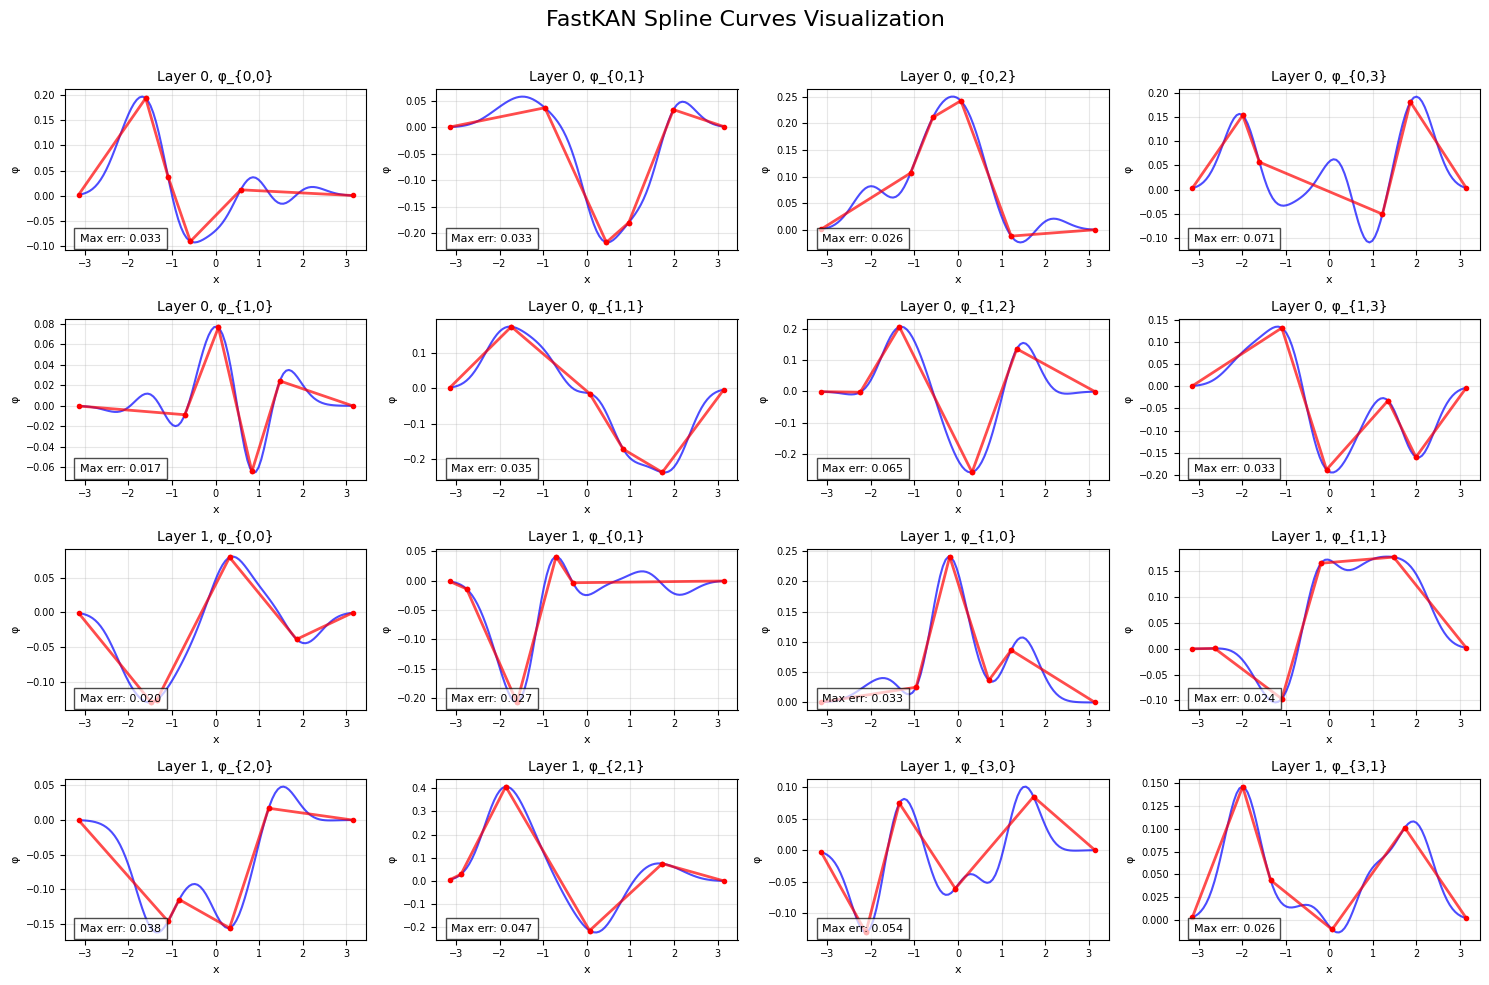

In [85]:
import matplotlib.pyplot as plt
import math
import numpy as np

def fit_kan_vanilla(kan_model, segments_per_curve, min_x=-5.0, max_x=5.0):
    all_segments = []
    for layer_idx, layer in enumerate(kan_model.layers):
        input_dim = layer.input_dim
        output_dim = layer.output_dim
        for input_index in range(input_dim):
            for output_index in range(output_dim):
                segments, max_error = find_bspline_segments_given_max_segments(
                    layer, input_index, output_index, segments_per_curve, min_x, max_x
                )
                all_segments.append((
                    layer_idx, 
                    input_index, 
                    output_index, 
                    segments, 
                    max_error
                ))
    return all_segments

def plot_kan(
    kan_model,
    all_segments,
    figsize=(15, 10),
    min_x=-5.0,
    max_x=5.0,
    num_pts=500,
):
    total_curves = len(all_segments)
    cols = math.ceil(math.sqrt(total_curves))
    rows = math.ceil(total_curves / cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize, squeeze=False)
    fig.suptitle('FastKAN Spline Curves Visualization', fontsize=16)
    axes = axes.flatten()
    for idx, (layer_idx, input_index, output_index, segments, max_error) in enumerate(all_segments):
        ax = axes[idx]
        layer = kan_model.layers[layer_idx]
        x_tensor, y_tensor = layer.plot_curve(
            input_index, output_index, 
            num_pts=num_pts
        )
        x_orig = x_tensor.detach().cpu().numpy()
        y_orig = y_tensor.detach().cpu().numpy()
        mask = (x_orig >= min_x) & (x_orig <= max_x)
        x_orig = x_orig[mask]
        y_orig = y_orig[mask]
        ax.plot(x_orig, y_orig, 'b-', linewidth=1.5, alpha=0.7, label='Original')
        for x1, x2, slope, intercept in segments:
            x_seg = np.linspace(x1, x2, 50)
            y_seg = slope * x_seg + intercept
            ax.plot(x_seg, y_seg, 'r-', linewidth=2, alpha=0.7)
            ax.plot([x1], [slope * x1 + intercept], 'ro', markersize=3)
            ax.plot([x2], [slope * x2 + intercept], 'ro', markersize=3)
        ax.text(0.05, 0.05, f'Max err: {max_error:.3f}', transform=ax.transAxes, 
                fontsize=8, bbox=dict(facecolor='white', alpha=0.7))
        ax.set_title(f'Layer {layer_idx}, φ_{{{input_index},{output_index}}}', fontsize=10)
        ax.set_xlabel('x', fontsize=8)
        ax.set_ylabel(f'φ', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=7)
        ax.grid(True, alpha=0.3)
    for i in range(total_curves, len(axes)):
        axes[i].axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    return fig

model_scenario1 = FastKAN([2, 4, 2], use_layernorm=False, use_base_update=False)
kan_model = model_scenario1
all_segments = fit_kan_vanilla(
    kan_model,
    min_x=-5.0,
    max_x=5.0,
    segments_per_curve=5
)
fig = plot_kan(
    kan_model,
    all_segments,
    figsize=(15, 10),
    min_x=-5.0,
    max_x=5.0,
    num_pts=100,
)
plt.show()

In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from typing import *
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpProblem, LpVariable, LpMinimize, LpMaximize, LpStatus, LpBinary, lpSum, PULP_CBC_CMD, LpAffineExpression

# --- Fitting Utilities ---

def fit_line_through_points(x1, y1, x2, y2):
    # --- (Keep existing fit_line_through_points) ---
    # Avoid division by zero if points are identical
    if abs(x2 - x1) < 1e-9:
        # Vertical line - return infinite slope and x-intercept (or handle as error)
        # For MIP, maybe return a very large slope? Or handle this case upstream.
        # Let's assume upstream ensures x1 != x2 for segments.
        if abs(y2 - y1) < 1e-9: # Points are identical
             return 0.0, y1 # Slope 0, intercept is the y-value
        else: # Vertical line
             # This case is problematic for MIP function y = slope*x + intercept
             # Returning a large slope might work if the x range is tiny.
             # A better approach might be to slightly perturb x2 in find_bspline_segments.
             print(f"Warning: Vertical segment detected ({x1},{y1}) to ({x2},{y2}). Using large slope.")
             return 1e9 * np.sign(y2 - y1), -1e9 * x1 * np.sign(y2-y1) + y1


    slope = (y2 - y1) / (x2 - x1)
    intercept = y1 - slope * x1
    return slope, intercept

def find_bspline_segments_given_max_segments(layer, input_index, output_index, max_segments, min_x, max_x):
    # --- (Keep existing find_bspline_segments_given_max_segments) ---
    # Sample points from the spline
    n_samples = min(max_segments * 10, 100) # More samples might improve accuracy

    # Get plot points (ensure they are on CPU)
    x_tensor, y_tensor = layer.plot_curve(input_index, output_index, num_pts=n_samples)
    x_np = x_tensor.detach().cpu().numpy()
    y_np = y_tensor.detach().cpu().numpy()

    # Filter points to the desired range [min_x, max_x]
    mask = (x_np >= min_x) & (x_np <= max_x)
    x_points = x_np[mask]
    y_points = y_np[mask]

    n = len(x_points)
    if n < 2:
        # Not enough points in the range to form a segment
        # Return empty list and 0 error (or Inf error if preferred)
        return [], 0.0 # Represents a flat line (slope 0) or trivially fits

    # Precompute errors for all possible segments using L-infinity norm (max absolute error)
    errors = np.full((n, n), np.inf)
    segment_details = {} # Store (slope, intercept) for reuse

    for start_idx in range(n):
        for end_idx in range(start_idx + 1, n):
            x_start, y_start = x_points[start_idx], y_points[start_idx]
            x_end, y_end = x_points[end_idx], y_points[end_idx]

            # Avoid degenerate segments (identical x values)
            if abs(x_end - x_start) < 1e-9:
                # If y values are also identical, error is 0, otherwise infinite error
                if abs(y_end - y_start) < 1e-9:
                    slope, intercept = 0.0, y_start
                    segment_error = 0.0
                else:
                    # Cannot fit a line properly
                    continue # Leave error as np.inf
            else:
                slope, intercept = fit_line_through_points(x_start, y_start, x_end, y_end)

                # Calculate error for points within this potential segment
                segment_x = x_points[start_idx : end_idx + 1]
                segment_y = y_points[start_idx : end_idx + 1]
                predicted_y = slope * segment_x + intercept
                segment_error = np.max(np.abs(predicted_y - segment_y))

            errors[start_idx, end_idx] = segment_error
            segment_details[(start_idx, end_idx)] = (slope, intercept)


    # Dynamic programming to find optimal segmentation minimizing max error
    # dp[k, j] = min max error using k segments ending at point j
    # back[k, j] = index i where the k-th segment starts (segment is from i to j)
    dp = np.full((max_segments + 1, n), np.inf) # Use 1-based index for segments for clarity
    back = np.zeros((max_segments + 1, n), dtype=int)

    # Base case: 1 segment from point 0 to point j
    for j in range(1, n):
        dp[1, j] = errors[0, j]
        back[1, j] = 0 # Segment starts at 0

    # Fill dp table
    for k in range(2, max_segments + 1): # Number of segments
        for j in range(k, n): # End point index (must be >= k)
            min_prev_max_error = np.inf
            best_split_point = -1
            # Find the best split point i for the last segment (i to j)
            for i in range(k - 1, j): # Potential start point of the last segment
                # Error of the last segment (from i to j)
                last_segment_error = errors[i, j]
                if last_segment_error == np.inf: continue

                # Max error using k-1 segments ending at i
                prev_max_error = dp[k - 1, i]
                if prev_max_error == np.inf: continue

                # The overall max error for this split is max(prev_max_error, last_segment_error)
                current_max_error = max(prev_max_error, last_segment_error)

                if current_max_error < min_prev_max_error:
                    min_prev_max_error = current_max_error
                    best_split_point = i

            if best_split_point != -1:
                dp[k, j] = min_prev_max_error
                back[k, j] = best_split_point


    # Find the minimum error using up to max_segments ending at the last point (n-1)
    min_total_max_error = np.inf
    optimal_num_segments = -1
    for k in range(1, max_segments + 1):
        if dp[k, n - 1] < min_total_max_error:
            min_total_max_error = dp[k, n - 1]
            optimal_num_segments = k

    # Reconstruct the segments if a solution was found
    segments = []
    if optimal_num_segments > 0 and min_total_max_error != np.inf:
        curr_end_idx = n - 1
        for k in range(optimal_num_segments, 0, -1):
            curr_start_idx = back[k, curr_end_idx]

            # Get segment details (start/end x and slope/intercept)
            x1 = x_points[curr_start_idx]
            x2 = x_points[curr_end_idx]

            # Recalculate slope/intercept based *only* on start and end points
            # This ensures segments connect exactly at the chosen points.
            y1 = y_points[curr_start_idx]
            y2 = y_points[curr_end_idx]
            slope, intercept = fit_line_through_points(x1, y1, x2, y2)

            # Store segment: (start_x, end_x, slope, intercept)
            segments.insert(0, (x1, x2, slope, intercept))

            curr_end_idx = curr_start_idx # Move to the previous segment's end point

        final_max_error = min_total_max_error
    else:
        # No valid segmentation found within max_segments constraint
        segments = []
        final_max_error = np.inf
        # Attempt a single segment fit as a fallback?
        if n >= 2:
            x1, y1 = x_points[0], y_points[0]
            x2, y2 = x_points[-1], y_points[-1]
            if abs(x2-x1) > 1e-9:
                 slope, intercept = fit_line_through_points(x1, y1, x2, y2)
                 segment_x = x_points
                 segment_y = y_points
                 predicted_y = slope * segment_x + intercept
                 single_seg_error = np.max(np.abs(predicted_y - segment_y))
                 print(f"    Warning: DP failed for {input_index}->{output_index}. Using single segment fallback (error={single_seg_error:.4f}).")
                 segments = [(x1, x2, slope, intercept)]
                 final_max_error = single_seg_error
            else: # Cannot even fit a single segment
                 final_max_error = np.inf


    # Return segments and the maximum approximation error achieved
    return segments, final_max_error


def fit_kan_vanilla(kan_model, segments_per_curve, min_x, max_x):
    # --- (Keep existing fit_kan_vanilla, minor logging improvements) ---
    all_segments = []
    if not hasattr(kan_model, 'layers') or not isinstance(kan_model.layers, nn.ModuleList):
         raise ValueError("Provided model does not have a 'layers' attribute of type nn.ModuleList.")

    num_layers = len(kan_model.layers)
    print(f"Fitting KAN model with {num_layers} FastKANLayer(s)...")

    for layer_idx, layer in enumerate(kan_model.layers):
        if not isinstance(layer, FastKANLayer):
             print(f"Warning: Layer {layer_idx} is not a FastKANLayer, skipping.")
             continue

        # Ensure layer is on CPU for numpy compatibility in find_bspline_segments
        layer.cpu()
        input_dim = layer.input_dim
        output_dim = layer.output_dim
        print(f"Fitting Layer {layer_idx} ({input_dim} -> {output_dim})")

        for input_index in range(input_dim):
            for output_index in range(output_dim):
                # print(f"  Fitting curve: Input {input_index}, Output {output_index}")
                segments, max_error = find_bspline_segments_given_max_segments(
                    layer, input_index, output_index, segments_per_curve, min_x, max_x
                )

                # Handle fitting results
                if not segments and max_error == np.inf:
                     print(f"    ERROR: Failed to fit segments for Layer {layer_idx}, Input {input_index}, Output {output_index}. Max error is Inf.")
                elif not segments:
                     # This case means n < 2 points were in range, or DP failed but fallback didn't run/succeed
                     # If max_error is 0, it implies flat line within range or trivially fits
                     if max_error == 0.0:
                          print(f"    Note: No segments needed (likely flat/trivial fit) for Layer {layer_idx}, Input {input_index}, Output {output_index} within [{min_x:.2f}, {max_x:.2f}]. Max error={max_error:.4f}")
                     else: # DP failed, no fallback, or fallback failed
                          print(f"    WARNING: Failed to fit segments (no segments returned) for Layer {layer_idx}, Input {input_index}, Output {output_index}. Max error={max_error:.4f}")
                          # Treat as high error but store the info
                          max_error = np.inf # Ensure it's treated as high error later

                all_segments.append({ # Use dict for clarity
                    'layer_idx': layer_idx,
                    'input_idx': input_index,
                    'output_idx': output_index,
                    'segments': segments,
                    'max_error': max_error # Store actual error (incl np.inf)
                })
    print(f"Fitting process completed. Generated data for {len(all_segments)} connections.")
    return all_segments


class DynamicSplineApproximation:
     # --- (Keep existing DynamicSplineApproximation class, improved get_bounding_box) ---
    def __init__(self, segments: List[Tuple[float, float, float, float]], max_error: float):
        """
        Initialize a dynamic spline approximation.

        Args:
            segments: List of tuples (start_x, end_x, slope, intercept)
                      Expected to be sorted by start_x and non-overlapping.
            max_error: Maximum approximation error for any point within these segments.
                       Can be np.inf if fitting failed.
        """
        # Ensure segments are sorted by start_x for easier processing
        self.segments = sorted(segments, key=lambda s: s[0]) if segments else []
        # Store max_error, replace inf with large number for MIP, but keep track if it was infinite
        self.original_max_error = max_error
        self.max_error_mip = max_error if np.isfinite(max_error) else 1e7 # For MIP solver stability

        # Validate segments are mostly non-overlapping (allow touching at endpoints)
        for i in range(len(self.segments) - 1):
            if self.segments[i][1] > self.segments[i+1][0] + 1e-6: # Allow slight overlap due to float precision
                print(f"Warning: Segments may overlap: {self.segments[i]} and {self.segments[i+1]}")


    def get_bounding_box(self):
        if not self.segments:
            # Return a default invalid range or raise error?
            # Returning invalid range allows MIP to potentially still run if other parts are bounded.
            return np.inf, -np.inf # Min > Max indicates invalid/empty range

        min_x = self.segments[0][0]
        max_x = self.segments[-1][1]
        return min_x, max_x

    def is_valid(self):
        """Checks if the approximation is usable (has segments and finite error)."""
        return bool(self.segments) and np.isfinite(self.original_max_error)


# --- MODIFIED Conversion Function ---

def fit_kan_to_spline_approximation_3layer(
    kan_segments_data: List[dict],
    input_dim: int,
    hidden_dim: int,
    output_dim: int
) -> Tuple[List[List[Optional[DynamicSplineApproximation]]], List[List[Optional[DynamicSplineApproximation]]]]:
    """
    Convert segment data from fit_kan_vanilla() into nested lists of
    DynamicSplineApproximation objects for a 3-layer KAN ([input, hidden, output]).

    Args:
        kan_segments_data: List of dictionaries from fit_kan_vanilla().
        input_dim: Number of input nodes.
        hidden_dim: Number of hidden nodes.
        output_dim: Number of output nodes.

    Returns:
        tuple: (layer0_approximations, layer1_approximations)
               layer0_approximations: List[List[Optional[DynamicSplineApproximation]]],
                                      size [input_dim][hidden_dim]. Represents Input -> Hidden connections.
               layer1_approximations: List[List[Optional[DynamicSplineApproximation]]],
                                      size [hidden_dim][output_dim]. Represents Hidden -> Output connections.
               Returns None in a slot if segments were not found or fitting failed for that specific connection.
    Raises:
        ValueError: If dimensions seem inconsistent with segment data.
    """
    # Initialize nested lists with None placeholders
    layer0_approximations: List[List[Optional[DynamicSplineApproximation]]] = \
        [[None for _ in range(hidden_dim)] for _ in range(input_dim)]
    layer1_approximations: List[List[Optional[DynamicSplineApproximation]]] = \
        [[None for _ in range(output_dim)] for _ in range(hidden_dim)]

    processed_indices_l0 = set()
    processed_indices_l1 = set()

    # Separate data by layer
    segments_layer0 = [s for s in kan_segments_data if s['layer_idx'] == 0]
    segments_layer1 = [s for s in kan_segments_data if s['layer_idx'] == 1]

    # --- Process Layer 0 (Input -> Hidden) ---
    print(f"Processing Layer 0 segments ({len(segments_layer0)} entries)...")
    for seg_data in segments_layer0:
        i = seg_data['input_idx']  # Input node index
        h = seg_data['output_idx'] # Hidden node index (output of layer 0)

        if i >= input_dim or h >= hidden_dim:
            print(f"Warning: Segment data index out of bounds for Layer 0 (Input {i}, Hidden {h}). Expected dims ({input_dim}, {hidden_dim}). Skipping.")
            continue
        if (i, h) in processed_indices_l0:
             print(f"Warning: Duplicate segment data found for Layer 0 connection: Input {i} -> Hidden {h}. Using the first encountered.")
             continue

        # Create approximation object, even if fitting failed (max_error=inf) or no segments needed (segments=[])
        approx = DynamicSplineApproximation(seg_data['segments'], seg_data['max_error'])
        layer0_approximations[i][h] = approx
        processed_indices_l0.add((i, h))

    # Check for missing connections in Layer 0
    for i in range(input_dim):
        for h in range(hidden_dim):
            if layer0_approximations[i][h] is None:
                print(f"Warning: No segment data found for Layer 0 connection: Input {i} -> Hidden {h}.")
                # Optionally create a default (e.g., zero spline) or leave as None
                # layer0_approximations[i][h] = DynamicSplineApproximation([], 0.0) # Example: default to zero

    # --- Process Layer 1 (Hidden -> Output) ---
    print(f"Processing Layer 1 segments ({len(segments_layer1)} entries)...")
    for seg_data in segments_layer1:
        h = seg_data['input_idx']  # Hidden node index (input of layer 1)
        o = seg_data['output_idx'] # Output node index

        if h >= hidden_dim or o >= output_dim:
            print(f"Warning: Segment data index out of bounds for Layer 1 (Hidden {h}, Output {o}). Expected dims ({hidden_dim}, {output_dim}). Skipping.")
            continue
        if (h, o) in processed_indices_l1:
             print(f"Warning: Duplicate segment data found for Layer 1 connection: Hidden {h} -> Output {o}. Using the first encountered.")
             continue

        approx = DynamicSplineApproximation(seg_data['segments'], seg_data['max_error'])
        layer1_approximations[h][o] = approx
        processed_indices_l1.add((h, o))

    # Check for missing connections in Layer 1
    for h in range(hidden_dim):
        for o in range(output_dim):
            if layer1_approximations[h][o] is None:
                print(f"Warning: No segment data found for Layer 1 connection: Hidden {h} -> Output {o}.")
                # layer1_approximations[h][o] = DynamicSplineApproximation([], 0.0) # Example: default to zero


    print("Segment conversion complete.")
    return layer0_approximations, layer1_approximations


# --- MODIFIED MIP Function ---

def kan_interval_analysis_MIP_3layer(
    layer0_approximations: List[List[Optional[DynamicSplineApproximation]]],
    layer1_approximations: List[List[Optional[DynamicSplineApproximation]]],
    x_min_vec: Union[List[float], np.ndarray],
    x_max_vec: Union[List[float], np.ndarray],
    M: float = 1e4, # Big M value - adjust based on expected ranges
    time_limit: int = 300 # Time limit in seconds for Gurobi
) -> List[Optional[Tuple[Optional[float], Optional[float]]]]:
    """
    Computes the output range (min, max) for each output of a 3-layer KAN
    ([input, hidden, output]) using MIP with piecewise linear approximations.
    Uses Gurobi as the solver.

    Args:
        layer0_approximations: Nested list [input_dim][hidden_dim] of DynamicSplineApproximation
                               objects for the Input -> Hidden connections. None if missing.
        layer1_approximations: Nested list [hidden_dim][output_dim] of DynamicSplineApproximation
                               objects for the Hidden -> Output connections. None if missing.
        x_min_vec: List or array of minimum values for each input dimension.
        x_max_vec: List or array of maximum values for each input dimension.
        M: Big-M value. Choose carefully based on expected variable ranges.
        time_limit: Time limit in seconds for Gurobi solver.

    Returns:
        List of tuples [(min_0, max_0), (min_1, max_1), ...], one per output dimension.
        Contains (None, None) for an output if optimization failed.
        Returns an empty list if dimensions are zero or setup fails early.
    """
    # Import Gurobi solver from PuLP
    from pulp import GUROBI_CMD

    if not layer0_approximations or not layer0_approximations[0]:
        print("Error: layer0_approximations is empty or invalid.")
        return []
    if not layer1_approximations or not layer1_approximations[0]:
         print("Error: layer1_approximations is empty or invalid.")
         return []

    input_dim = len(layer0_approximations)
    hidden_dim = len(layer0_approximations[0])
    # Check consistency with layer 1 input dimension
    if len(layer1_approximations) != hidden_dim:
         raise ValueError(f"Inconsistent hidden dimensions: Layer 0 output ({hidden_dim}), Layer 1 input ({len(layer1_approximations)})")
    output_dim = len(layer1_approximations[0]) if hidden_dim > 0 else 0

    if input_dim == 0 or hidden_dim == 0 or output_dim == 0:
        print("Warning: One or more dimensions (input, hidden, output) are zero. Cannot perform analysis.")
        return [(None, None)] * output_dim # Return list of Nones matching expected output shape

    if len(x_min_vec) != input_dim or len(x_max_vec) != input_dim:
        raise ValueError(f"Input bounds vector length mismatch. Expected {input_dim}, got min:{len(x_min_vec)}, max:{len(x_max_vec)}")

    print(f"Setting up MIP for KAN [{input_dim}, {hidden_dim}, {output_dim}]...")
    print(f"Input bounds: {list(zip(x_min_vec, x_max_vec))}")


    # --- Define Common Variables (used in all min/max problems) ---
    # Input variables
    x_vars = [LpVariable(f"x_{i}", lowBound=x_min_vec[i], upBound=x_max_vec[i]) for i in range(input_dim)]

    # Intermediate outputs of Layer 0 splines (one per connection)
    layer0_spline_outputs = [[LpVariable(f"l0_spline_{i}_{h}") for h in range(hidden_dim)] for i in range(input_dim)]

    # Activations of Hidden Layer nodes (sum of incoming spline outputs)
    hidden_activations = [LpVariable(f"hidden_act_{h}") for h in range(hidden_dim)] # Bounds estimated later if needed

    # Intermediate outputs of Layer 1 splines (one per connection)
    layer1_spline_outputs = [[LpVariable(f"l1_spline_{h}_{o}") for o in range(output_dim)] for h in range(hidden_dim)]

    # Final Output variables (sum of incoming spline outputs)
    output_vars = [LpVariable(f"output_{o}") for o in range(output_dim)] # Bounds are the goal

    # Binary indicators for segment selection
    layer0_indicators = [] # List[List[List[LpVariable]]] -> [input_idx][hidden_idx][segment_idx]
    for i in range(input_dim):
        indicators_i = []
        for h in range(hidden_dim):
            approx = layer0_approximations[i][h]
            if approx and approx.segments:
                indicators_i.append([LpVariable(f"l0_ind_{i}_{h}_seg_{j}", cat=LpBinary) for j in range(len(approx.segments))])
            else:
                indicators_i.append([]) # No indicators if no segments
        layer0_indicators.append(indicators_i)

    layer1_indicators = [] # List[List[List[LpVariable]]] -> [hidden_idx][output_idx][segment_idx]
    for h in range(hidden_dim):
        indicators_h = []
        for o in range(output_dim):
            approx = layer1_approximations[h][o]
            if approx and approx.segments:
                indicators_h.append([LpVariable(f"l1_ind_{h}_{o}_seg_{j}", cat=LpBinary) for j in range(len(approx.segments))])
            else:
                indicators_h.append([]) # No indicators if no segments
        layer1_indicators.append(indicators_h)

    # --- Define Common Constraints (added to every min/max problem) ---
    base_constraints = []

    # == Layer 0 Spline Constraints (Input -> Hidden) ==
    for i in range(input_dim):
        for h in range(hidden_dim):
            approx = layer0_approximations[i][h]
            x_input = x_vars[i] # Input for this spline connection
            spline_output_var = layer0_spline_outputs[i][h]
            indicators = layer0_indicators[i][h]

            if not approx or not approx.is_valid(): # Handle missing or invalid (inf error) splines
                 # If spline doesn't exist or fitting failed, assume its contribution is zero
                 base_constraints.append(spline_output_var == 0)
                 # print(f"  Constraint: l0_spline_{i}_{h} = 0 (No valid spline)")
                 continue # Skip segment constraints for this connection

            # 1. One segment must be active (if segments exist)
            if indicators:
                base_constraints.append(lpSum(indicators) == 1) #, f"l0_{i}_{h}_one_segment"

            # 2. Conditional constraints for x bounds and output value
            for j, (start_x, end_x, slope, intercept) in enumerate(approx.segments):
                indicator = indicators[j]
                y_approx = slope * x_input + intercept # LpAffineExpression

                # Indicator constraint: indicator = 1 => start_x <= x_input <= end_x (using Big-M)
                base_constraints.append(x_input >= start_x - M * (1 - indicator)) #, f"l0_{i}_{h}_seg_{j}_xmin"
                base_constraints.append(x_input <= end_x + M * (1 - indicator)) #, f"l0_{i}_{h}_seg_{j}_xmax"

                # Indicator constraint: indicator = 1 => y_approx - err <= spline_output_var <= y_approx + err (using Big-M)
                error = approx.max_error_mip # Use MIP-safe error
                base_constraints.append(spline_output_var <= y_approx + error + M * (1 - indicator)) #, f"l0_{i}_{h}_seg_{j}_ymax"
                base_constraints.append(spline_output_var >= y_approx - error - M * (1 - indicator)) #, f"l0_{i}_{h}_seg_{j}_ymin"


    # == Hidden Layer Activation Constraints ==
    for h in range(hidden_dim):
        # hidden_activations[h] = sum over i (layer0_spline_outputs[i][h])
        incoming_splines = [layer0_spline_outputs[i][h] for i in range(input_dim)]
        base_constraints.append(hidden_activations[h] == lpSum(incoming_splines)) #, f"hidden_act_{h}_sum"


    # == Layer 1 Spline Constraints (Hidden -> Output) ==
    for h in range(hidden_dim):
        for o in range(output_dim):
            approx = layer1_approximations[h][o]
            hidden_input = hidden_activations[h] # Input for this spline connection
            spline_output_var = layer1_spline_outputs[h][o]
            indicators = layer1_indicators[h][o]

            if not approx or not approx.is_valid():
                 # Assume zero contribution if spline is missing or invalid
                 base_constraints.append(spline_output_var == 0)
                 # print(f"  Constraint: l1_spline_{h}_{o} = 0 (No valid spline)")
                 continue

            # 1. One segment must be active
            if indicators:
                 base_constraints.append(lpSum(indicators) == 1) #, f"l1_{h}_{o}_one_segment"

            # 2. Estimate bounds for hidden_input (can be loose, helps solver)
            #    This requires estimating range of layer0 outputs - skip for now, rely on PuLP/solver
            outer_min_x, outer_max_x = approx.get_bounding_box()
            # if np.isfinite(outer_min_x): base_constraints.append(hidden_input >= outer_min_x) # Optional: Add bounds if known
            # if np.isfinite(outer_max_x): base_constraints.append(hidden_input <= outer_max_x) # Optional: Add bounds if known


            # 3. Conditional constraints for hidden_input bounds and output value
            for j, (start_x, end_x, slope, intercept) in enumerate(approx.segments):
                indicator = indicators[j]
                y_approx = slope * hidden_input + intercept # LpAffineExpression

                # Indicator: indicator = 1 => start_x <= hidden_input <= end_x
                base_constraints.append(hidden_input >= start_x - M * (1 - indicator)) #, f"l1_{h}_{o}_seg_{j}_xmin"
                base_constraints.append(hidden_input <= end_x + M * (1 - indicator)) #, f"l1_{h}_{o}_seg_{j}_xmax"

                # Indicator: indicator = 1 => y_approx - err <= spline_output_var <= y_approx + err
                error = approx.max_error_mip
                base_constraints.append(spline_output_var <= y_approx + error + M * (1 - indicator)) #, f"l1_{h}_{o}_seg_{j}_ymax"
                base_constraints.append(spline_output_var >= y_approx - error - M * (1 - indicator)) #, f"l1_{h}_{o}_seg_{j}_ymin"


    # == Final Output Activation Constraints ==
    for o in range(output_dim):
        # output_vars[o] = sum over h (layer1_spline_outputs[h][o])
        incoming_splines = [layer1_spline_outputs[h][o] for h in range(hidden_dim)]
        base_constraints.append(output_vars[o] == lpSum(incoming_splines)) #, f"output_{o}_sum"

    print(f"Defined {len(base_constraints)} base constraints.")

    # --- Solve for Min/Max of each Output ---
    results = []
    
    # Configure Gurobi solver with options
    gurobi_options = [
        ('TimeLimit', time_limit),       # Time limit in seconds
        ('MIPGap', 1e-4),               # Relative MIP gap tolerance
        ('Threads', 4),                 # Number of threads to use
        ('OutputFlag', 1),              # Enable solver output (set to 0 for silent)
        ('Method', 3),                  # MIP method (3 is concurrent)
        ('Presolve', 2),                # Presolve level (2 is aggressive)
        ('MIPFocus', 1)                 # Focus on finding feasible solutions quickly
    ]
    
    # Create Gurobi solver with the options
    solver = GUROBI_CMD(path=None, keepFiles=False, mip=True, msg=False, 
                      options=gurobi_options)

    for o in range(output_dim):
        print(f"\n--- Optimizing for Output Dimension {o} ---")
        target_output_var = output_vars[o]
        min_val = None
        max_val = None

        # -- Minimize --
        prob_min = LpProblem(f"KAN_Output_{o}_Min", LpMinimize)
        prob_min += target_output_var # Objective
        for constraint in base_constraints: # Add all common structural constraints
            prob_min += constraint
        print(f"Solving for Min Output {o} using Gurobi...")
        prob_min.solve(solver)
        status_min = LpStatus[prob_min.status]
        if status_min == 'Optimal':
            min_val = target_output_var.varValue
            print(f"Min Output {o} found: {min_val:.6f}")
        else:
            print(f"Min Output {o} Optimization failed. Status: {status_min}")
            # Optionally try to diagnose: check constraints, bounds, Big M

        # -- Maximize --
        prob_max = LpProblem(f"KAN_Output_{o}_Max", LpMaximize)
        prob_max += target_output_var # Objective
        for constraint in base_constraints: # Add all common structural constraints
            prob_max += constraint
        print(f"Solving for Max Output {o} using Gurobi...")
        prob_max.solve(solver) 
        status_max = LpStatus[prob_max.status]
        if status_max == 'Optimal':
            max_val = target_output_var.varValue
            print(f"Max Output {o} found: {max_val:.6f}")
        else:
            print(f"Max Output {o} Optimization failed. Status: {status_max}")

        results.append((min_val, max_val))

    return results

# --- Example Usage ---
if __name__ == "__main__":
    # 1. Define KAN model dimensions
    input_dim = 2 # Example: 2 inputs
    hidden_dim = 5 # Example: 5 hidden nodes
    output_dim = 3 # Example: 3 outputs
    layers = [input_dim, hidden_dim, output_dim]

    print(f"Initializing KAN model with structure: {layers}...")
    # Set seeds for reproducibility
    torch.manual_seed(43)
    np.random.seed(43)

    # Use fewer grids, disable base update for pure spline test (simpler MIP)
    kan_model = FastKAN(
        layers,
        num_grids=5,
       # spline_segments_init_scale=0.5,
        use_base_update=False, # IMPORTANT: Base update adds complexity not modeled in MIP yet
        use_layernorm=False # LayerNorm also not explicitly modeled in MIP
    )
    kan_model.cpu() # Ensure model is on CPU for fitting

    # Optional: Random forward pass to initialize any lazy parameters (unlikely needed here)
    # dummy_input = torch.randn(1, input_dim)
    # _ = kan_model(dummy_input)

    # 2. Fit Linear Segments
    print("\nFitting spline segments...")
    fit_min_x, fit_max_x = -2.0, 2.0 # Range for fitting each individual spline
    segments_per_curve = 4      # Number of linear pieces per spline
    kan_segments_data = fit_kan_vanilla(kan_model, segments_per_curve=segments_per_curve, min_x=fit_min_x, max_x=fit_max_x)

    if not kan_segments_data:
         print("\nERROR: Fitting did not produce any segment data. Exiting.")
         exit()

    # Check if any valid segments were actually found
    valid_segments_found = any(d['segments'] and np.isfinite(d['max_error']) for d in kan_segments_data)
    if not valid_segments_found:
        print("\nERROR: Fitting completed, but no valid segments with finite error were found. Cannot proceed with MIP.")
        # You might inspect kan_segments_data here to see why (all Inf errors?)
        exit()
    else:
        num_valid = sum(1 for d in kan_segments_data if d['segments'] and np.isfinite(d['max_error']))
        print(f"\nFitting check: Found {num_valid} connections with valid, finite-error segments.")


    # 3. Convert segments using the NEW function
    print("\nConverting fitted segments to DynamicSplineApproximation...")
    try:
        layer0_approx, layer1_approx = fit_kan_to_spline_approximation_3layer(
            kan_segments_data,
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim
        )
        print("Conversion successful.")
        # Optional: Check structure
        # print(f"Layer 0 Approx structure: {len(layer0_approx)} x {len(layer0_approx[0])}")
        # print(f"Layer 1 Approx structure: {len(layer1_approx)} x {len(layer1_approx[0])}")

    except ValueError as e:
        print(f"\nERROR during conversion: {e}")
        exit()
    except Exception as e:
        print(f"\nUNEXPECTED ERROR during conversion: {e}")
        import traceback
        traceback.print_exc()
        exit()

    # 4. Run MIP Analysis using the NEW function
    print("\nRunning MIP Interval Analysis...")
    # Define the input range FOR EACH dimension for the analysis
    analysis_x_min_vec = [-1.0] * input_dim # Example: all inputs between -1 and 1
    analysis_x_max_vec = [1.0] * input_dim
    print(f"Input interval for analysis: min={analysis_x_min_vec}, max={analysis_x_max_vec}")

    try:
        # Use the 3-layer MIP function
        output_ranges = kan_interval_analysis_MIP_3layer(
            layer0_approx,
            layer1_approx,
            x_min_vec=analysis_x_min_vec,
            x_max_vec=analysis_x_max_vec,
            M = 5e3 # Adjust Big M based on expected value ranges
        )

        print("\n--- MIP Analysis Results ---")
        if output_ranges:
            for o, (min_o, max_o) in enumerate(output_ranges):
                 if min_o is not None and max_o is not None:
                      print(f"Output {o}: Estimated range [{min_o:.6f}, {max_o:.6f}]")
                 else:
                      print(f"Output {o}: MIP analysis could not find an optimal solution.")
        else:
             print("MIP analysis did not return results (check dimensions or setup).")


        # 5. Verification (Optional - Sample points and check KAN output)
        print("\n--- Verification (Direct Sampling) ---")
        num_samples = 10000 # Increase samples for higher dimensions
        # Create test inputs covering the analysis range
        # Simple grid sampling (can be computationally expensive for high input_dim)
        # Using random sampling within the bounds is more scalable
        test_x_vals_np = np.random.uniform(
            low=analysis_x_min_vec,
            high=analysis_x_max_vec,
            size=(num_samples, input_dim)
        )
        test_x_vals = torch.tensor(test_x_vals_np, dtype=torch.float32).cpu()

        with torch.no_grad():
            kan_model.eval() # Set model to evaluation mode
            actual_outputs = kan_model(test_x_vals) # Shape [num_samples, output_dim]
            actual_outputs_np = actual_outputs.numpy()

        print(f"Actual KAN output range (sampling {num_samples} points):")
        for o in range(output_dim):
             actual_min_o = np.min(actual_outputs_np[:, o])
             actual_max_o = np.max(actual_outputs_np[:, o])
             print(f" Output {o}: [{actual_min_o:.6f}, {actual_max_o:.6f}]")

             # Compare with MIP bounds if available
             if output_ranges and o < len(output_ranges):
                 min_o_mip, max_o_mip = output_ranges[o]
                 if min_o_mip is not None and max_o_mip is not None:
                     # Check if actual range is contained within MIP bounds (allowing for tolerance)
                     tolerance = 1e-4 + max(abs(min_o_mip), abs(max_o_mip)) * 1e-5 # Absolute + relative tolerance
                     lower_bound_ok = min_o_mip <= actual_min_o + tolerance
                     upper_bound_ok = max_o_mip >= actual_max_o - tolerance
                     print(f"   Verification containment check: Lower OK: {lower_bound_ok}, Upper OK: {upper_bound_ok}")
                     if not (lower_bound_ok and upper_bound_ok):
                         print("     Warning: Sampled range may not be strictly within MIP bounds.")
                         print(f"     MIP: [{min_o_mip:.6f}, {max_o_mip:.6f}], Sampled: [{actual_min_o:.6f}, {actual_max_o:.6f}]")
                         print(f"     Diffs: Lower {(actual_min_o - min_o_mip):.6f}, Upper {(actual_max_o - max_o_mip):.6f}")
                 else:
                     print("   Verification: Cannot compare, MIP failed for this output.")


    except ImportError:
        print("\nERROR: PuLP library not found. Please install it: pip install pulp")
    except ValueError as e:
         print(f"\nVALUE ERROR during MIP setup or execution: {e}")
    except Exception as e:
        print(f"\nAn error occurred during MIP analysis or verification: {e}")
        import traceback
        traceback.print_exc()

# 6352
# 25 took about 4 min ish

Initializing KAN model with structure: [2, 5, 3]...

Fitting spline segments...
Fitting KAN model with 2 FastKANLayer(s)...
Fitting Layer 0 (2 -> 5)
Fitting Layer 1 (5 -> 3)
Fitting process completed. Generated data for 25 connections.

Fitting check: Found 25 connections with valid, finite-error segments.

Converting fitted segments to DynamicSplineApproximation...
Processing Layer 0 segments (10 entries)...
Processing Layer 1 segments (15 entries)...
Segment conversion complete.
Conversion successful.

Running MIP Interval Analysis...
Input interval for analysis: min=[-1.0, -1.0], max=[1.0, 1.0]
Setting up MIP for KAN [2, 5, 3]...
Input bounds: [(-1.0, 1.0), (-1.0, 1.0)]
Defined 429 base constraints.

--- Optimizing for Output Dimension 0 ---
Solving for Min Output 0 using Gurobi...
Min Output 0 found: 0.129134
Solving for Max Output 0 using Gurobi...
Max Output 0 found: 0.352563

--- Optimizing for Output Dimension 1 ---
Solving for Min Output 1 using Gurobi...
Min Output 1 found: -

In [87]:
import time
import torch
import numpy as np
from typing import List, Dict, Any, Tuple, Optional, Union

# Helper function for tolerance comparison - kept unchanged
def check_bounds(
    mip_min: Optional[float],
    mip_max: Optional[float],
    sampled_min: float,
    sampled_max: float,
    abs_tol: float = 1e-4,
    rel_tol: float = 1e-3
) -> Tuple[bool, bool, str]:
    """
    Compares MIP bounds against sampled bounds with tolerance.

    Returns:
        Tuple: (lower_bound_ok, upper_bound_ok, message)
    """
    message = []
    lower_bound_ok = False
    upper_bound_ok = False

    if mip_min is None:
        message.append("MIP Min bound is None.")
    else:
        # Check if MIP lower bound is less than or equal to sampled lower bound (allowing tolerance)
        # Tolerance = abs_tol + rel_tol * |sampled_min|
        lower_tol = abs_tol + rel_tol * abs(sampled_min)
        if mip_min <= sampled_min + lower_tol:
            lower_bound_ok = True
        else:
            message.append(f"Lower bound failed: MIP_min ({mip_min:.6f}) > Sampled_min ({sampled_min:.6f}) + Tol ({lower_tol:.6f})")

    if mip_max is None:
        message.append("MIP Max bound is None.")
    else:
        # Check if MIP upper bound is greater than or equal to sampled upper bound (allowing tolerance)
        # Tolerance = abs_tol + rel_tol * |sampled_max|
        upper_tol = abs_tol + rel_tol * abs(sampled_max)
        if mip_max >= sampled_max - upper_tol:
            upper_bound_ok = True
        else:
            message.append(f"Upper bound failed: MIP_max ({mip_max:.6f}) < Sampled_max ({sampled_max:.6f}) - Tol ({upper_tol:.6f})")

    return lower_bound_ok, upper_bound_ok, ". ".join(message)


def test_kan_mip_bounds(models: List, test_cases: List[Dict[str, Any]]) -> str:
    """
    Runs a series of tests on the KAN MIP bounding pipeline using predefined models.

    Args:
        models: A list of FastKAN model instances to test
        test_cases: A list of dictionaries, where each dictionary defines
                    a test case with parameters like:
                    'name': str (descriptive name)
                    'seed': int (for reproducibility)
                    'fit_range': Tuple[float, float]
                    'analysis_min_vec': List[float] (will be overridden based on model)
                    'analysis_max_vec': List[float] (will be overridden based on model)
                    'segments_per_curve': int
                    'M': float (Big-M value)
                    'num_samples': int (for verification)
                    'abs_tol': float (absolute tolerance for comparison)
                    'rel_tol': float (relative tolerance for comparison)

    Returns:
        "Passed" if all test cases pass the bounds check, "Failed" otherwise.
    """
    overall_passed = True
    num_tests = len(test_cases)
    start_suite_time = time.time()

    # Ensure PuLP is available before starting
    try:
        import pulp
        print(f"PuLP version: {pulp.__version__}")
    except ImportError:
        print("\nERROR: PuLP library not found. Cannot run tests.")
        print("Please install it: pip install pulp")
        return "Failed (Missing Dependency)"

    for model_idx, kan_model in enumerate(models):
        print(f"\n=== Testing Model {model_idx+1}/{len(models)} ===")
        
        for i, config in enumerate(test_cases):
            test_name = config.get('name', f"Test Case {i+1}")
            print(f"\n--- Running {test_name} ({i+1}/{num_tests}) with Model {model_idx+1} ---")
            start_test_time = time.time()
            current_test_passed = True
            failure_reason = ""

            try:
                # --- Get parameters ---
                seed = config['seed']
                segments_per_curve = config['segments_per_curve']
                fit_min_x, fit_max_x = config['fit_range']
                M = config['M']
                num_samples = config['num_samples']
                abs_tol = config['abs_tol']
                rel_tol = config['rel_tol']

                # --- Extract model dimensions ---
                # For a FastKAN model, we need to extract the dimensions from the layers
                # Get the input dim from the first layer, output dim from the last layer
                input_dim = kan_model.layers[0].input_dim
                output_dim = kan_model.layers[-1].output_dim
                
                # For MIP testing, we often focus on [0, 1] input range for each dimension
                analysis_min_vec = [0.0] * input_dim  
                analysis_max_vec = [1.0] * input_dim

                # --- 1. Setup & Model Init ---
                print(f"Model dimensions: Input={input_dim}, Output={output_dim}")
                print(f"Config: Segments={segments_per_curve}, Fit Range=[{fit_min_x:.1f},{fit_max_x:.1f}]")
                print(f"Analysis Range: Min={analysis_min_vec[:2]}{'...' if len(analysis_min_vec)>2 else ''}")
                print(f"                Max={analysis_max_vec[:2]}{'...' if len(analysis_max_vec)>2 else ''}")
                print(f"Seed={seed}, M={M}, Samples={num_samples}, AbsTol={abs_tol}, RelTol={rel_tol}")

                # Set seeds for reproducibility
                torch.manual_seed(seed)
                np.random.seed(seed)

                # Ensure model is on CPU for testing
                kan_model.cpu()

                # --- 2. Fit Splines ---
                print("Fitting splines...")
                kan_segments_data = fit_kan_vanilla(
                    kan_model,
                    segments_per_curve=segments_per_curve,
                    min_x=fit_min_x,
                    max_x=fit_max_x
                )
                
                if not kan_segments_data:
                    print("FAIL: fit_kan_vanilla produced no segment data.")
                    current_test_passed = False
                    failure_reason = "Fitting produced no segment data."
                    raise RuntimeError(failure_reason) # Stop this test case

                # Check if any valid segments were found before conversion
                valid_segments_found = any(d['segments'] and np.isfinite(d['max_error']) for d in kan_segments_data)
                if not valid_segments_found:
                    print("FAIL: fit_kan_vanilla found no connections with valid, finite-error segments.")
                    current_test_passed = False
                    failure_reason = "No valid segments found during fitting."
                    raise RuntimeError(failure_reason) # Stop this test case

                # --- 3. Get hidden dimensions (needed for spline approximation) ---
                # For a 3-layer KAN, we need the hidden dim from the middle layer
                if len(kan_model.layers) < 2:
                    print("FAIL: Model must have at least 2 layers for this test.")
                    current_test_passed = False
                    failure_reason = "Model has insufficient layers."
                    raise RuntimeError(failure_reason)
                
                hidden_dim = kan_model.layers[0].output_dim  # Output of first layer = hidden dimension
                
                # --- 4. Convert Segments ---
                print("Converting segments...")
                layer0_approx, layer1_approx = fit_kan_to_spline_approximation_3layer(
                    kan_segments_data,
                    input_dim=input_dim,
                    hidden_dim=hidden_dim,
                    output_dim=output_dim
                )
                
                # Basic check on conversion output structure
                if not isinstance(layer0_approx, list) or not isinstance(layer1_approx, list):
                    print("FAIL: Segment conversion did not return lists.")
                    current_test_passed = False
                    failure_reason = "Segment conversion failed."
                    raise RuntimeError(failure_reason) # Stop this test case

                # --- 5. Run MIP Analysis ---
                print("Running MIP analysis...")
                mip_output_ranges = kan_interval_analysis_MIP_3layer(
                    layer0_approx,
                    layer1_approx,
                    x_min_vec=analysis_min_vec,
                    x_max_vec=analysis_max_vec,
                    M=M
                )

                if not mip_output_ranges or len(mip_output_ranges) != output_dim:
                    print(f"FAIL: MIP analysis did not return expected results (Expected {output_dim} ranges, got {len(mip_output_ranges) if mip_output_ranges else 0}).")
                    current_test_passed = False
                    failure_reason = "MIP analysis failed or returned incorrect number of outputs."
                    # Continue to sampling for comparison if possible, but mark as failed.

                # --- 6. Verification Sampling ---
                print(f"Performing verification sampling ({num_samples} points)...")
                # Use random sampling within the analysis bounds
                test_x_vals_np = np.random.uniform(
                    low=analysis_min_vec,
                    high=analysis_max_vec,
                    size=(num_samples, input_dim)
                )
                test_x_vals = torch.tensor(test_x_vals_np, dtype=torch.float32).cpu()

                with torch.no_grad():
                    kan_model.eval()
                    actual_outputs = kan_model(test_x_vals)
                    actual_outputs_np = actual_outputs.numpy()

                # --- 7. Compare Results ---
                print("Comparing MIP bounds vs. Sampled bounds...")
                for o in range(output_dim):
                    sampled_min_o = np.min(actual_outputs_np[:, o])
                    sampled_max_o = np.max(actual_outputs_np[:, o])
                    print(f" Output {o}: Sampled Range = [{sampled_min_o:.6f}, {sampled_max_o:.6f}]")

                    mip_min_o, mip_max_o = None, None
                    if mip_output_ranges and o < len(mip_output_ranges):
                        mip_min_o, mip_max_o = mip_output_ranges[o]
                        if mip_min_o is not None and mip_max_o is not None:
                            print(f" Output {o}: MIP Range     = [{mip_min_o:.6f}, {mip_max_o:.6f}]")
                        else:
                            print(f" Output {o}: MIP Range     = [Failed, Failed]")
                            if current_test_passed: # Only update reason if not already failed
                                failure_reason = f"MIP optimization failed for output {o}."
                            current_test_passed = False # Mark failure if MIP couldn't solve

                    else: # MIP results missing for this output
                        print(f" Output {o}: MIP Range     = [Not Available]")
                        # Failure reason already set above if structure was wrong
                        if current_test_passed:
                            failure_reason = f"MIP results missing for output {o}."
                        current_test_passed = False

                    # Perform the bounds check only if MIP succeeded for this output
                    if mip_min_o is not None and mip_max_o is not None:
                        lower_ok, upper_ok, msg = check_bounds(
                            mip_min_o, mip_max_o, sampled_min_o, sampled_max_o, abs_tol, rel_tol
                        )
                        if not (lower_ok and upper_ok):
                            print(f"  -> BOUND CHECK FAILED for Output {o}: {msg}")
                            if current_test_passed: # Only update reason if not already failed
                                failure_reason = f"Bounds check failed for output {o}. {msg}"
                            current_test_passed = False # Mark failure
                        else:
                            print(f"  -> BOUND CHECK PASSED for Output {o}")

            except Exception as e:
                print(f"\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
                print(f"ERROR during {test_name} with Model {model_idx+1}: {e}")
                print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
                import traceback
                traceback.print_exc() # Print detailed traceback for debugging
                current_test_passed = False
                failure_reason = f"Runtime Exception: {type(e).__name__}"

            # --- Test Result ---
            end_test_time = time.time()
            test_duration = end_test_time - start_test_time
            if current_test_passed:
                print(f"\n---> {test_name} with Model {model_idx+1}: PASSED ({test_duration:.2f}s)")
            else:
                print(f"\n---> {test_name} with Model {model_idx+1}: FAILED ({test_duration:.2f}s)")
                print(f"     Reason: {failure_reason}")
                overall_passed = False # If any test fails, the suite fails

    # --- Suite Result ---
    end_suite_time = time.time()
    suite_duration = end_suite_time - start_suite_time
    print(f"\n============================================")
    print(f"Test Suite Summary:")
    print(f"Total Time: {suite_duration:.2f}s")
    print(f"Models Tested: {len(models)}")
    print(f"Test Cases Per Model: {num_tests}")
    if overall_passed:
        print(f"Result: Passed")
        return "Passed"
    else:
        print(f"Result: Failed (At least one test case failed)")
        return "Failed"


# --- Define Test Cases ---
test_configurations = [
    {
        'name': "Default_Test",
        'seed': 101,
        'segments_per_curve': 4,
        'fit_range': (-2.0, 2.0),
        'M': 1e3,
        'num_samples': 5000,
        'abs_tol': 1e-3,
        'rel_tol': 1e-2,
    },
    # You can add more test configurations as needed
]


# --- Execute the Test Suite ---
if __name__ == "__main__":
    # Make sure all necessary code (classes, functions) from the previous steps
    # is defined or imported before this point.
    
    print("Starting KAN MIP Bounds Test Suite...")
    
    # For your preexisting models:
    models = [model_scenario1, model_scenario2, model_scenario3, model_scenario4]
    
    # This assumes fit_kan_vanilla, fit_kan_to_spline_approximation_3layer,
    # and kan_interval_analysis_MIP_3layer functions are defined elsewhere
    final_result = test_kan_mip_bounds(models, test_configurations)
    
    print(f"\nFINAL TEST SUITE RESULT: {final_result}")

Starting KAN MIP Bounds Test Suite...
PuLP version: 3.0.2

=== Testing Model 1/4 ===

--- Running Default_Test (1/1) with Model 1 ---
Model dimensions: Input=2, Output=2
Config: Segments=4, Fit Range=[-2.0,2.0]
Analysis Range: Min=[0.0, 0.0]
                Max=[1.0, 1.0]
Seed=101, M=1000.0, Samples=5000, AbsTol=0.001, RelTol=0.01
Fitting splines...
Fitting KAN model with 2 FastKANLayer(s)...
Fitting Layer 0 (2 -> 4)
Fitting Layer 1 (4 -> 2)
Fitting process completed. Generated data for 16 connections.
Converting segments...
Processing Layer 0 segments (8 entries)...
Processing Layer 1 segments (8 entries)...
Segment conversion complete.
Running MIP analysis...
Setting up MIP for KAN [2, 4, 2]...
Input bounds: [(0.0, 1.0), (0.0, 1.0)]
Defined 274 base constraints.

--- Optimizing for Output Dimension 0 ---
Solving for Min Output 0 using Gurobi...
Min Output 0 found: -0.117088
Solving for Max Output 0 using Gurobi...
Max Output 0 found: 0.270717

--- Optimizing for Output Dimension 1 --

KeyboardInterrupt: 

# Verification With Lipschitz

![image.png](python_lipschitz.png)

Analyzing B-spline at Layer 0, Input 0, Output 2...
Computing error table up to 10 segments

Error table (segments -> error):
  1 segments: 0.0546
  2 segments: 0.0557
  3 segments: 0.0516
  4 segments: 0.0198
  5 segments: 0.0171
  6 segments: 0.0103
  7 segments: 0.0081
  8 segments: 0.0084
  9 segments: 0.0076
  10 segments: 0.0069


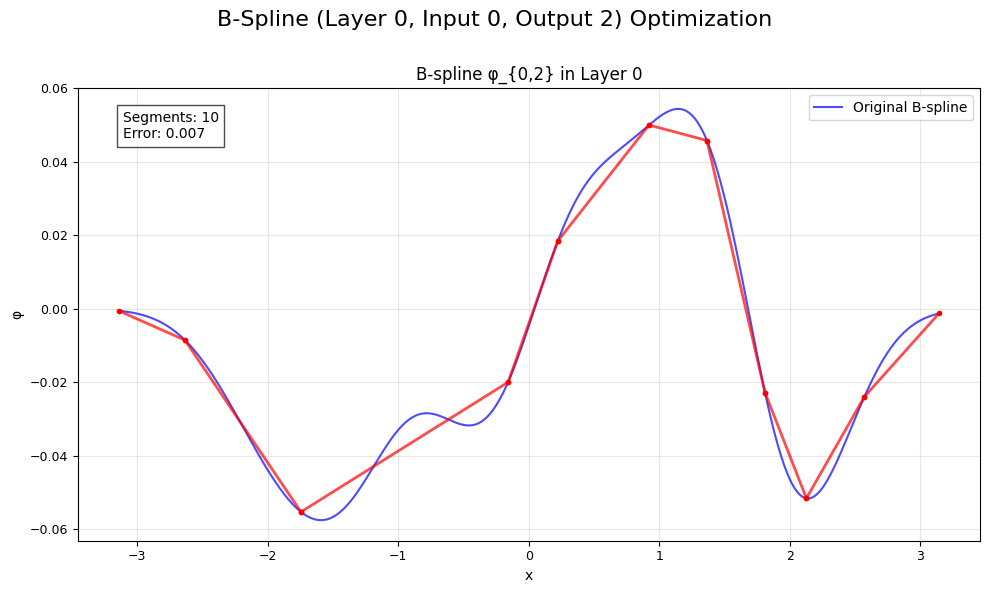

In [88]:
def visualize_optimized_bspline(kan_model, layer_idx, input_idx, output_idx, num_segments, 
                               segments_table, error_table, min_x=-5.0, max_x=5.0, figsize=(10, 6)):
    """
    Visualize the optimized B-spline approximation for a specific B-spline.
    
    Parameters:
    - kan_model: The FastKAN model
    - layer_idx: The index of the layer containing the B-spline
    - input_idx: The input index of the B-spline
    - output_idx: The output index of the B-spline
    - num_segments: Number of segments to display
    - segments_table: Dictionary mapping num_segments to the segment definitions
    - error_table: Dictionary mapping num_segments to error
    - min_x, max_x: Range of x values to consider
    - figsize: Size of the figure
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    fig, ax = plt.subplots(figsize=figsize)
    fig.suptitle(f'B-Spline (Layer {layer_idx}, Input {input_idx}, Output {output_idx}) Optimization', fontsize=16)
    
    # Get the original B-spline curve
    layer = kan_model.layers[layer_idx]
    x_tensor, y_tensor = layer.plot_curve(
        input_idx, output_idx, 
        num_pts=500
    )
    
    x_orig = x_tensor.detach().cpu().numpy()
    y_orig = y_tensor.detach().cpu().numpy()
    
    # Filter to desired range
    mask = (x_orig >= min_x) & (x_orig <= max_x)
    x_orig = x_orig[mask]
    y_orig = y_orig[mask]
    
    # Plot original curve
    ax.plot(x_orig, y_orig, 'b-', linewidth=1.5, alpha=0.7, label='Original B-spline')
    
    # Get the segments and error from the tables
    segments = segments_table[num_segments]
    error = error_table[num_segments]
    
    # Plot optimized segments
    for x1, x2, slope, intercept in segments:
        x_seg = np.linspace(x1, x2, 50)
        y_seg = slope * x_seg + intercept
        ax.plot(x_seg, y_seg, 'r-', linewidth=2, alpha=0.7)
        ax.plot([x1], [slope * x1 + intercept], 'ro', markersize=3)
        ax.plot([x2], [slope * x2 + intercept], 'ro', markersize=3)
    
    ax.text(0.05, 0.95, f'Segments: {num_segments}\nError: {error:.3f}', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.7))
    
    ax.set_title(f'B-spline φ_{{{input_idx},{output_idx}}} in Layer {layer_idx}', fontsize=12)
    ax.set_xlabel('x', fontsize=10)
    ax.set_ylabel(f'φ', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=9)
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    return fig

def optimize_bspline(kan_model, layer_idx, input_idx, output_idx, 
                    min_x=-5.0, max_x=5.0, max_segments=15):
    """
    Analyze a single B-spline by computing the error for different numbers of linear segments
    up to a specified maximum.
    
    Parameters:
    - kan_model: The FastKAN model
    - layer_idx: The index of the layer containing the B-spline
    - input_idx: The input index of the B-spline
    - output_idx: The output index of the B-spline
    - min_x, max_x: Range of x values to consider
    - max_segments: Maximum number of segments to evaluate
    
    Returns:
    - error_table: Dictionary mapping num_segments to error
    - segments_table: Dictionary mapping num_segments to the segment definitions
    """
    layer = kan_model.layers[layer_idx]
    
    # Generate the error table for this B-spline
    error_table = {}
    segments_table = {}
    
    for num_segments in range(1, max_segments + 1):
        segments, error = find_bspline_segments_given_max_segments(
            layer, input_idx, output_idx, num_segments, min_x, max_x
        )
        error_table[num_segments] = error
        segments_table[num_segments] = segments
    
    return error_table, segments_table

def run_bspline_optimization_example():
    # Create a FastKAN model
    kan_model = FastKAN([2, 6, 2])
    
    # Define the range of x values to consider
    min_x = -5.0
    max_x = 5.0
    
    # Select a B-spline to optimize
    layer_idx = 0
    input_idx = 0
    output_idx = 2
    
    # Set the maximum number of segments to evaluate
    max_segments = 10
    
    print(f"Analyzing B-spline at Layer {layer_idx}, Input {input_idx}, Output {output_idx}...")
    print(f"Computing error table up to {max_segments} segments")
    
    # Run the analysis
    error_table, segments_table = optimize_bspline(
        kan_model=kan_model,
        layer_idx=layer_idx,
        input_idx=input_idx,
        output_idx=output_idx,
        min_x=min_x,
        max_x=max_x,
        max_segments=max_segments
    )
    
    # Print the error table
    print("\nError table (segments -> error):")
    for n_seg in sorted(error_table.keys()):
        print(f"  {n_seg} segments: {error_table[n_seg]:.4f}")
    
    # Select a specific number of segments to visualize
    viz_segments = max_segments  # Or choose any value between 1 and max_segments
    
    # Visualize the results
    fig = visualize_optimized_bspline(
        kan_model=kan_model,
        layer_idx=layer_idx,
        input_idx=input_idx,
        output_idx=output_idx,
        num_segments=viz_segments,
        segments_table=segments_table,
        error_table=error_table,
        min_x=min_x,
        max_x=max_x
    )
    
    plt.show()
    
    return error_table, segments_table

# Execute the example if run directly
if __name__ == "__main__":
    error_table, segments_table = run_bspline_optimization_example()

Creating example FastKAN model...

Comparing original and weighted error tables...
Analyzing Layer 0: 2 inputs -> 3 outputs
  Processing B-spline at Layer 0, Input 0, Output 0...
    Lipschitz constant: 0.38354355096817017
  Processing B-spline at Layer 0, Input 0, Output 1...
    Lipschitz constant: 0.2685456871986389
  Processing B-spline at Layer 0, Input 0, Output 2...
    Lipschitz constant: 0.2730042636394501
  Processing B-spline at Layer 0, Input 1, Output 0...
    Lipschitz constant: 0.38749799132347107
  Processing B-spline at Layer 0, Input 1, Output 1...
    Lipschitz constant: 0.3548935353755951
  Processing B-spline at Layer 0, Input 1, Output 2...
    Lipschitz constant: 0.3688933849334717
Analyzing Layer 1: 3 inputs -> 2 outputs
  Processing B-spline at Layer 1, Input 0, Output 0...
    Lipschitz constant: 0.47359251976013184
  Processing B-spline at Layer 1, Input 0, Output 1...
    Lipschitz constant: 0.44105005264282227
  Processing B-spline at Layer 1, Input 1, Outp

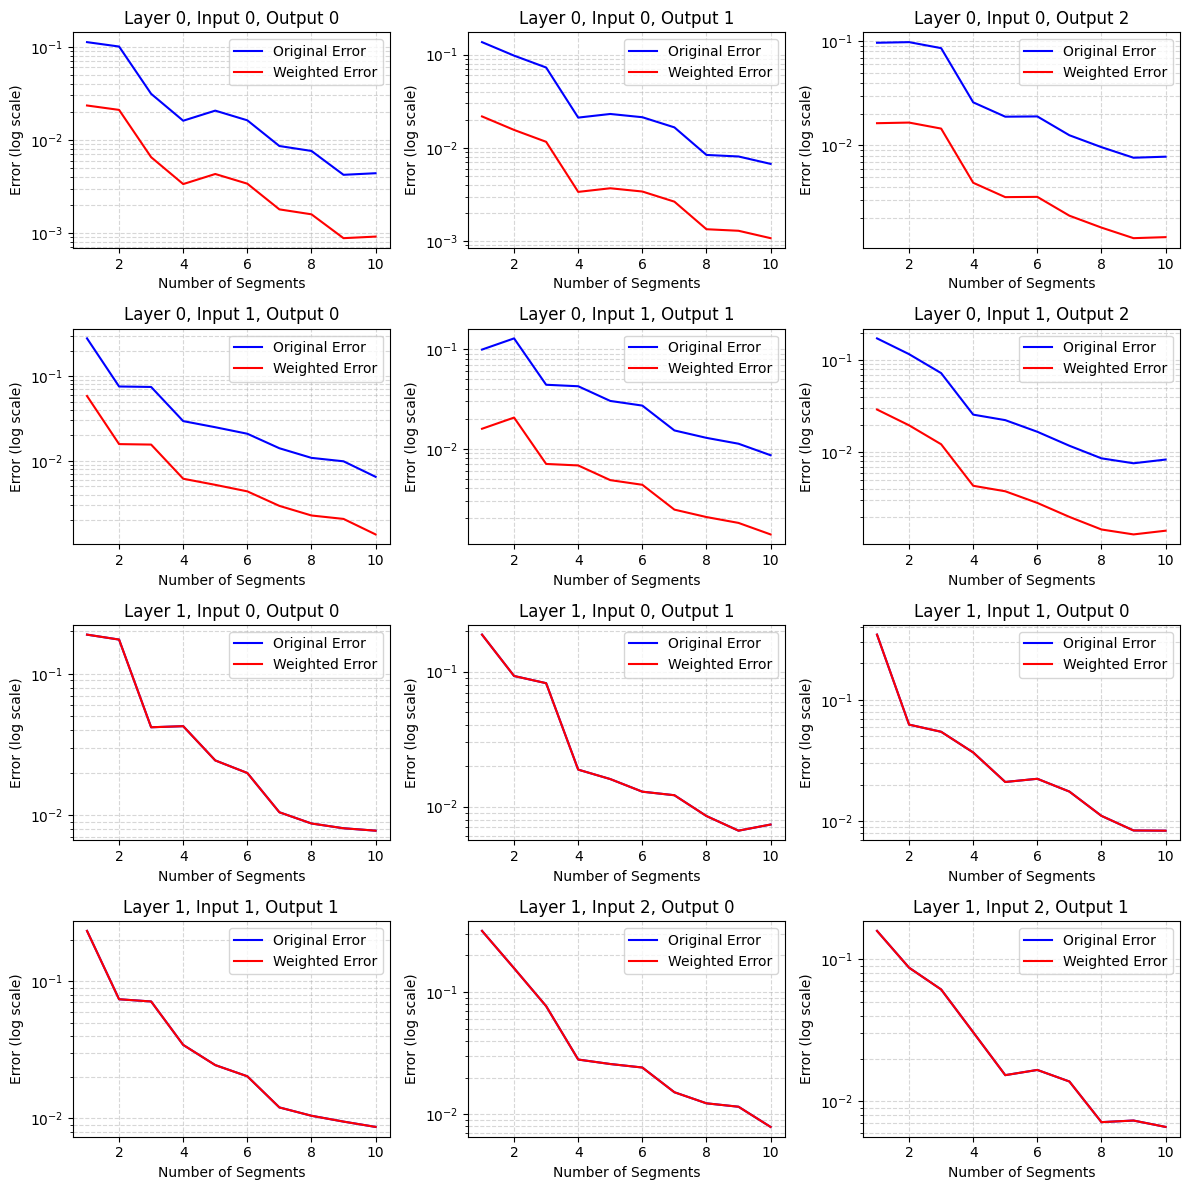

In [89]:
def compute_dp_tables_lipschitz(kan_model, min_x=-5.0, max_x=5.0, max_segments=15):
    """
    Analyze and optimize all B-splines in a FastKAN model by computing the error 
    for different numbers of linear segments and calculating Lipschitz constants.
    
    Parameters:
    - kan_model: The FastKAN model to analyze
    - min_x, max_x: Range of x values to consider for each B-spline
    - max_segments: Maximum number of segments to evaluate per B-spline
    
    Returns:
    - error_tables: Dictionary mapping (layer_idx, input_idx, output_idx) to an error table.
                   Each error table maps num_segments to error.
    - segments_tables: Dictionary mapping (layer_idx, input_idx, output_idx) to a segments table.
                     Each segments table maps num_segments to segment definitions.
    - lipschitz_constants: Dictionary mapping (layer_idx, input_idx, output_idx) to the 
                          Lipschitz constant of that B-spline.
    """
    error_tables = {}
    segments_tables = {}
    lipschitz_constants = {}
    
    # Iterate through all layers
    for layer_idx, layer in enumerate(kan_model.layers):
        input_dim = layer.input_dim
        output_dim = layer.output_dim
        
        print(f"Analyzing Layer {layer_idx}: {input_dim} inputs -> {output_dim} outputs")
        
        # Iterate through all B-splines in this layer
        for input_idx in range(input_dim):
            for output_idx in range(output_dim):
                spline_key = (layer_idx, input_idx, output_idx)
                print(f"  Processing B-spline at Layer {layer_idx}, Input {input_idx}, Output {output_idx}...")
                
                # Optimize this B-spline
                error_table, segments_table = optimize_bspline(
                    kan_model=kan_model,
                    layer_idx=layer_idx,
                    input_idx=input_idx,
                    output_idx=output_idx,
                    min_x=min_x,
                    max_x=max_x,
                    max_segments=max_segments
                )
                
                # Calculate Lipschitz constant for this B-spline
                lipschitz_constant = calculate_bspline_lipschitz_constant(
                    layer=layer,
                    input_idx=input_idx,
                    output_idx=output_idx
                )
                
                # Store the results
                error_tables[spline_key] = error_table
                segments_tables[spline_key] = segments_table
                lipschitz_constants[spline_key] = lipschitz_constant
                
                print(f"    Lipschitz constant: {lipschitz_constant}")
    
    return error_tables, segments_tables, lipschitz_constants

def calculate_bspline_lipschitz_constant(
    layer: 'FastKANLayer', 
    input_idx: int, 
    output_idx: int, 
    num_pts: int = 1000,
    min_x: float = None,
    max_x: float = None
) -> float:
    """
    Calculate the Lipschitz constant of a B-spline in a FastKAN layer.
    
    The Lipschitz constant is the maximum absolute value of the derivative 
    of the B-spline function. For B-splines, this is the maximum absolute 
    slope across all piecewise segments.
    
    Args:
        layer: FastKANLayer instance containing the B-spline
        input_idx: The input index of the B-spline
        output_idx: The output index of the B-spline
        num_pts: Number of points to sample for numerical derivative calculation
        min_x: Minimum x value to consider (defaults to layer's grid_min if None)
        max_x: Maximum x value to consider (defaults to layer's grid_max if None)
    
    Returns:
        float: The Lipschitz constant (maximum absolute derivative)
    """
    # Set default range if not provided
    if min_x is None:
        min_x = layer.rbf.grid_min
    if max_x is None:
        max_x = layer.rbf.grid_max
    
    # Sample points from the B-spline
    x_tensor, y_tensor = layer.plot_curve(
        input_idx, 
        output_idx, 
        num_pts=num_pts
    )
    
    # Convert to numpy arrays
    x_np = x_tensor.detach().cpu().numpy()
    y_np = y_tensor.detach().cpu().numpy()
    
    # Filter to desired range
    mask = (x_np >= min_x) & (x_np <= max_x)
    x_np = x_np[mask]
    y_np = y_np[mask]
    
    # Calculate numerical derivatives (slopes between adjacent points)
    dx = np.diff(x_np)
    dy = np.diff(y_np)
    
    # Avoid division by zero
    nonzero_dx = dx != 0
    slopes = np.zeros_like(dx)
    slopes[nonzero_dx] = dy[nonzero_dx] / dx[nonzero_dx]
    
    # The Lipschitz constant is the maximum absolute slope
    lipschitz_constant = np.max(np.abs(slopes))
    
    return lipschitz_constant

def get_all_downstream_splines(kan_model, layer_idx, input_idx, output_idx, visited=None):
    """
    Get all downstream splines of a given spline.
    
    Args:
        kan_model (FastKAN): The FastKAN model
        layer_idx (int): Current layer index
        input_idx (int): Input index within the layer
        output_idx (int): Output index within the layer
        visited (set): Set of visited splines to avoid cycles and double-counting
    
    Returns:
        set: Set of tuples (layer_idx, input_idx, output_idx) for all downstream splines
    """
    if visited is None:
        visited = set()
    
    if layer_idx >= len(kan_model.layers) - 1:
        # This is the last layer, no downstream splines
        return set()
    
    # The output of this spline becomes an input in the next layer
    next_input_idx = output_idx
    next_layer_idx = layer_idx + 1
    next_layer = kan_model.layers[next_layer_idx]
    
    downstream_splines = set()
    
    # For each output in the next layer
    for next_output_idx in range(next_layer.output_dim):
        next_spline = (next_layer_idx, next_input_idx, next_output_idx)
        
        if next_spline not in visited:
            visited.add(next_spline)
            downstream_splines.add(next_spline)
            
            # Recursively get all splines downstream of the next spline
            further_downstream = get_all_downstream_splines(
                kan_model, next_layer_idx, next_input_idx, next_output_idx, visited
            )
            downstream_splines.update(further_downstream)
    
    return downstream_splines

def fit_kan_lipschitz(kan_model, min_x=-5.0, max_x=5.0, max_segments=15):
    """
    Analyze all B-splines in a FastKAN model and weight their errors based on 
    downstream Lipschitz constants.
    
    Parameters:
    - kan_model: The FastKAN model to analyze
    - min_x, max_x: Range of x values to consider for each B-spline
    - max_segments: Maximum number of segments to evaluate per B-spline
    
    Returns:
    - weighted_error_tables: Dictionary mapping (layer_idx, input_idx, output_idx) 
                           to a weighted error table. Each weighted error table 
                           maps num_segments to weighted error.
    - segments_tables: Dictionary mapping (layer_idx, input_idx, output_idx) 
                     to a segments table. Each segments table maps num_segments 
                     to segment definitions.
    - lipschitz_constants: Dictionary mapping (layer_idx, input_idx, output_idx) 
                          to the Lipschitz constant of that B-spline.
    """
    # First, compute the DP tables and Lipschitz constants
    error_tables, segments_tables, lipschitz_constants = compute_dp_tables_lipschitz(
        kan_model, min_x, max_x, max_segments
    )
    
    # Initialize the weighted error tables
    weighted_error_tables = {}
    
    # Iterate through all splines in the network
    for layer_idx, layer in enumerate(kan_model.layers):
        input_dim = layer.input_dim
        output_dim = layer.output_dim
        
        print(f"Weighing Layer {layer_idx}: {input_dim} inputs -> {output_dim} outputs")
        
        for input_idx in range(input_dim):
            for output_idx in range(output_dim):
                spline_key = (layer_idx, input_idx, output_idx)
                print(f"  Processing B-spline at Layer {layer_idx}, Input {input_idx}, Output {output_idx}...")
                
                # Get all unique downstream splines
                downstream_splines = get_all_downstream_splines(
                    kan_model, layer_idx, input_idx, output_idx
                )
                
                # Compute the product of Lipschitz constants of all downstream splines
                lipschitz_product = 1.0
                for downstream_spline in downstream_splines:
                    if downstream_spline in lipschitz_constants:
                        lipschitz_product *= lipschitz_constants[downstream_spline]
                
                # Weight the error table
                weighted_table = {}
                for num_segments, error in error_tables[spline_key].items():
                    weighted_table[num_segments] = error * lipschitz_product
                
                weighted_error_tables[spline_key] = weighted_table
                
                print(f"    Unique downstream splines: {len(downstream_splines)}")
                print(f"    Lipschitz product: {lipschitz_product}")
    
    return weighted_error_tables, segments_tables, lipschitz_constants

def compare_error_tables(kan_model, min_x=-5.0, max_x=5.0, max_segments=20):
    """
    Compare original error tables with weighted error tables for all splines in a FastKAN model.
    
    Parameters:
    - kan_model: The FastKAN model to analyze
    - min_x, max_x: Range of x values to consider for each B-spline
    - max_segments: Maximum number of segments to evaluate per B-spline
    """
    # First, compute the weighted error tables
    weighted_error_tables, segments_tables, lipschitz_constants = fit_kan_lipschitz(
        kan_model, min_x, max_x, max_segments
    )
    
    # Get the original error tables from compute_dp_tables_lipschitz
    original_error_tables, _, _ = compute_dp_tables_lipschitz(
        kan_model, min_x, max_x, max_segments
    )
    
    # Create figures to display the comparison
    num_layers = len(kan_model.layers)
    for layer_idx in range(num_layers):
        layer = kan_model.layers[layer_idx]
        input_dim = layer.input_dim
        output_dim = layer.output_dim
        
        print(f"\n====== Layer {layer_idx}: {input_dim} inputs -> {output_dim} outputs ======")
        
        for input_idx in range(input_dim):
            for output_idx in range(output_dim):
                spline_key = (layer_idx, input_idx, output_idx)
                
                # Get the original and weighted error tables
                orig_table = original_error_tables[spline_key]
                weighted_table = weighted_error_tables[spline_key]
                
                # Get the Lipschitz constant
                lip_const = lipschitz_constants[spline_key]
                
                # Get the downstream splines
                downstream_splines = get_all_downstream_splines(
                    kan_model, layer_idx, input_idx, output_idx
                )
                
                # Compute the product of downstream Lipschitz constants
                lipschitz_product = 1.0
                for ds_spline in downstream_splines:
                    if ds_spline in lipschitz_constants:
                        lipschitz_product *= lipschitz_constants[ds_spline]
                
                print(f"\nB-spline at Layer {layer_idx}, Input {input_idx}, Output {output_idx}:")
                print(f"  Lipschitz constant: {lip_const:.4f}")
                print(f"  Downstream Lipschitz product: {lipschitz_product:.4f}")
                print(f"  Number of downstream splines: {len(downstream_splines)}")
                
                # Create a table to display the comparison
                print("\n  Error Table Comparison:")
                print("  -------------------------------------------------------------------------------------")
                print("  | Segments |  Original Error  |  Weighted Error  |  Weight Factor  |  Ratio (W/O)  |")
                print("  -------------------------------------------------------------------------------------")
                
                # Display selected segment counts for clarity
                selected_segments = [1, 2, 3, 5, 10, max_segments]
                for num_segments in selected_segments:
                    if num_segments in orig_table and num_segments in weighted_table:
                        orig_error = orig_table[num_segments]
                        weighted_error = weighted_table[num_segments]
                        
                        # Calculate the ratio
                        ratio = weighted_error / orig_error if orig_error != 0 else float('inf')
                        
                        print(f"  |    {num_segments:2d}    | {orig_error:14.6e} | {weighted_error:14.6e} | {lipschitz_product:14.6e} | {ratio:14.6f} |")
                
                print("  -------------------------------------------------------------------------------------")
    
    # Return all the tables for potential further analysis
    return original_error_tables, weighted_error_tables, lipschitz_constants

def visualize_error_comparison(kan_model, min_x=-5.0, max_x=5.0, max_segments=20):
    """
    Visualize the comparison between original and weighted error tables for all splines
    in the FastKAN model.
    
    Parameters:
    - kan_model: The FastKAN model to analyze
    - min_x, max_x: Range of x values to consider for each B-spline
    - max_segments: Maximum number of segments to evaluate per B-spline
    """
    # Compute the tables
    original_tables, weighted_tables, lipschitz_constants = compare_error_tables(
        kan_model, min_x, max_x, max_segments
    )
    
    # Count the total number of splines
    total_splines = sum(
        layer.input_dim * layer.output_dim 
        for layer in kan_model.layers
    )
    
    # Set up the figure with subplots (adjust the layout based on the number of splines)
    rows = int(np.ceil(np.sqrt(total_splines)))
    cols = int(np.ceil(total_splines / rows))
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3), squeeze=False)
    
    # Flatten the axes array for easy iteration
    axes_flat = axes.flatten()
    
    # Counter for subplot index
    subplot_idx = 0
    
    # For each layer and spline
    for layer_idx, layer in enumerate(kan_model.layers):
        for input_idx in range(layer.input_dim):
            for output_idx in range(layer.output_dim):
                if subplot_idx >= len(axes_flat):
                    break  # In case we have more splines than subplots
                
                ax = axes_flat[subplot_idx]
                spline_key = (layer_idx, input_idx, output_idx)
                
                # Get original and weighted errors
                orig_errors = [original_tables[spline_key].get(s, 0) for s in range(1, max_segments+1)]
                weighted_errors = [weighted_tables[spline_key].get(s, 0) for s in range(1, max_segments+1)]
                
                # Plot the data
                segments = list(range(1, max_segments+1))
                ax.plot(segments, orig_errors, 'b-', label='Original Error')
                ax.plot(segments, weighted_errors, 'r-', label='Weighted Error')
                
                # Add logarithmic scale for better visualization
                ax.set_yscale('log')
                
                # Add title and labels
                ax.set_title(f'Layer {layer_idx}, Input {input_idx}, Output {output_idx}')
                ax.set_xlabel('Number of Segments')
                ax.set_ylabel('Error (log scale)')
                ax.legend()
                ax.grid(True, which="both", ls="--", alpha=0.5)
                
                subplot_idx += 1
    
    # Remove any unused subplots
    for i in range(subplot_idx, len(axes_flat)):
        fig.delaxes(axes_flat[i])
    
    plt.tight_layout()
    
    # Return the figure for further customization or saving
    return fig

# Example usage with a small FastKAN model
def create_example_kan_model():
    """Create a small FastKAN model for testing."""
    # Define the layer sizes: input, hidden layers, output
    layers_hidden = [2, 3, 2]  # 2 inputs -> 3 hidden -> 2 hidden -> 1 output
    
    # Create the model
    model = FastKAN(
        layers_hidden=layers_hidden,
        grid_min=-2.0,
        grid_max=2.0,
        num_grids=8,
        use_base_update=True,
    )
    
    return model

def demo_error_comparison():
    """Demonstrate the error comparison on a small example model."""
    print("Creating example FastKAN model...")
    model = create_example_kan_model()
    
    print("\nComparing original and weighted error tables...")
    # Use smaller max_segments for this demo
    fig = visualize_error_comparison(model, min_x=-2.0, max_x=2.0, max_segments=10)
    
    print("\nVisualization complete. Close the plot window to continue.")
    plt.show()
    
    return model

model = demo_error_comparison()

In [94]:
def weight_dp_tables_lipschitz(kan_model, min_x=-5.0, max_x=5.0, max_segments=15):
    error_tables, segments_tables, lipschitz_constants = compute_dp_tables_lipschitz(
        kan_model, min_x, max_x, max_segments
    )
    
    # Initialize the weighted error tables
    weighted_error_tables = {}
    
    # Iterate through all splines in the network
    for layer_idx, layer in enumerate(kan_model.layers):
        input_dim = layer.input_dim
        output_dim = layer.output_dim
        
        print(f"Weighing Layer {layer_idx}: {input_dim} inputs -> {output_dim} outputs")
        
        for input_idx in range(input_dim):
            for output_idx in range(output_dim):
                spline_key = (layer_idx, input_idx, output_idx)
                print(f"  Processing B-spline at Layer {layer_idx}, Input {input_idx}, Output {output_idx}...")
                
                # Get all unique downstream splines
                downstream_splines = get_all_downstream_splines(
                    kan_model, layer_idx, input_idx, output_idx
                )
                
                # Compute the product of Lipschitz constants of all downstream splines
                lipschitz_product = 1.0
                for downstream_spline in downstream_splines:
                    if downstream_spline in lipschitz_constants:
                        lipschitz_product *= lipschitz_constants[downstream_spline]
                
                # Weight the error table
                weighted_table = {}
                for num_segments, error in error_tables[spline_key].items():
                    weighted_table[num_segments] = error * lipschitz_product
                
                weighted_error_tables[spline_key] = weighted_table
                
                print(f"    Unique downstream splines: {len(downstream_splines)}")
                print(f"    Lipschitz product: {lipschitz_product}")
    
    return weighted_error_tables, segments_tables, lipschitz_constants

def fit_kan_optimally_lipschitz(kan_model, weighted_error_tables, segments_tables, max_error, 
                             min_x=-5.0, max_x=5.0, max_segments=50):
    all_splines = list(weighted_error_tables.keys())
    num_splines = len(all_splines)
    
    print(f"Optimizing segment allocation for {num_splines} B-splines...")
    
    max_total_segments = min(num_splines * max_segments, 1000)
    
    # Initialize DP table: dp[i][j] represents the minimum error achievable when
    # allocating j total segments to the first i splines
    dp = np.full((num_splines + 1, max_total_segments + 1), float('inf'))
    dp[0, 0] = 0  # Base case: 0 error when allocating 0 segments to 0 splines
    backtrack = np.zeros((num_splines + 1, max_total_segments + 1), dtype=int)
    all_spline_errors = {}
    # look at 1 spline at a time
     
    
    # Find the minimum total segments that achieve error <= max_error
    optimal_total_segments = None
    achieved_error = float('inf')
    for j in range(max_total_segments + 1):
        if dp[num_splines, j] <= max_error:
            optimal_total_segments = j
            achieved_error = dp[num_splines, j]
            break
    
    # Reconstruct the optimal allocation
    optimal_allocation = {}
    actual_segments = {}
    remaining_segments = optimal_total_segments
    for i in range(num_splines, 0, -1):
        spline_key = all_splines[i-1]
        segs_for_spline = backtrack[i, remaining_segments]
        optimal_allocation[spline_key] = segs_for_spline
        actual_segments[spline_key] = segments_tables[spline_key].get(segs_for_spline, [])
        remaining_segments -= segs_for_spline
    
    total_segments = sum(optimal_allocation.values())
    print(f"  Achieved error: {achieved_error}")
    return optimal_allocation, actual_segments, total_segments, achieved_error, dp

def construct_simplified_kan(kan_model, optimal_allocation, actual_segments):
    """
    Construct a simplified version of the KAN using the optimal segment allocation.
    
    Parameters:
    - kan_model: The original FastKAN model
    - optimal_allocation: Dictionary mapping (layer_idx, input_idx, output_idx) to the optimal number of segments
    - actual_segments: Dictionary mapping (layer_idx, input_idx, output_idx) to the actual segment definitions
    
    Returns:
    - simplified_kan: A new model representing the simplified KAN
    """
    # This function would create a new model structure using the optimized
    # piecewise linear segments rather than the original B-splines
    
    # Implementation would depend on how you want to represent the simplified model
    # For now, we'll return a structure describing the simplified model
    
    simplified_model = {
        'architecture': [layer.output_dim for layer in kan_model.layers],
        'total_segments': sum(optimal_allocation.values()),
        'segment_allocation': optimal_allocation,
        'segment_definitions': actual_segments
    }
    
    return simplified_model

def print_dp_table(dp_table, num_splines, max_total_segments, step=5):
    """
    Print the dynamic programming table in a readable format.
    
    Parameters:
    - dp_table: The DP table from fit_kan_optimally_lipschitz
    - num_splines: Number of splines (rows in the DP table)
    - max_total_segments: Maximum total segments (columns in the DP table)
    - step: Step size for printing columns (to avoid overwhelming output)
    """
    import numpy as np
    
    print("\nDynamic Programming Table (Error values):")
    print("-" * 80)
    
    # Header row with column indices
    header = "Spline \\ Segments"
    for j in range(0, min(max_total_segments + 1, 100), step):
        header += f" | {j:5d}"
    print(header)
    print("-" * len(header))
    
    # Print rows with error values
    for i in range(num_splines + 1):
        row = f"{i:3d}"
        for j in range(0, min(max_total_segments + 1, 100), step):
            if np.isinf(dp_table[i, j]):
                row += " | inf  "
            else:
                row += f" | {dp_table[i, j]:.3f}"
        print(row)
    
    print("-" * 80)
    print("Note: 'inf' indicates that the error is infinite (impossible allocation)")
    print("Only the first 100 columns are shown (if applicable)")

def visualize_all_splines(kan_model, optimal_allocation, actual_segments):
    """
    Visualize all splines in the KAN model with their optimal allocations.
    Creates a grid of plots showing all original and simplified splines.
    
    Parameters:
    - kan_model: The original FastKAN model
    - optimal_allocation: Dictionary mapping (layer_idx, input_idx, output_idx) to the optimal number of segments
    - actual_segments: Dictionary mapping (layer_idx, input_idx, output_idx) to the actual segment definitions
    
    Returns:
    - A list of figure objects, one per layer
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import math
    
    # Group splines by layer for better organization
    splines_by_layer = {}
    for spline_key in optimal_allocation.keys():
        layer_idx, input_idx, output_idx = spline_key
        if layer_idx not in splines_by_layer:
            splines_by_layer[layer_idx] = []
        splines_by_layer[layer_idx].append((input_idx, output_idx))
    
    figures = []
    
    # Create a separate figure for each layer
    for layer_idx, splines in splines_by_layer.items():
        layer = kan_model.layers[layer_idx]
        num_splines = len(splines)
        
        # Determine grid dimensions (try to make it roughly square)
        grid_size = math.ceil(math.sqrt(num_splines))
        rows = math.ceil(num_splines / grid_size)
        cols = min(grid_size, num_splines)
        
        # Create figure and subplots
        fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
        fig.suptitle(f"Layer {layer_idx}: All Splines with Optimal Segment Allocation", fontsize=16)
        
        # Flatten axes if it's a grid
        if num_splines > 1:
            axes_flat = axes.flatten()
        else:
            axes_flat = [axes]
        
        # Plot each spline in this layer
        for i, (input_idx, output_idx) in enumerate(splines):
            if i >= len(axes_flat):
                break
                
            ax = axes_flat[i]
            spline_key = (layer_idx, input_idx, output_idx)
            
            # Get the original spline
            x_tensor, y_tensor = layer.plot_curve(input_idx, output_idx, num_pts=1000)
            x_original = x_tensor.detach().cpu().numpy()
            y_original = y_tensor.detach().cpu().numpy()
            
            # Get the simplified spline
            segments = actual_segments[spline_key]
            x_simplified = []
            y_simplified = []
            
            for x1, x2, slope, intercept in segments:
                segment_x = np.linspace(x1, x2, 50)
                segment_y = slope * segment_x + intercept
                x_simplified.extend(segment_x)
                y_simplified.extend(segment_y)
            
            # Plot
            ax.plot(x_original, y_original, 'b-', label='Original')
            ax.plot(x_simplified, y_simplified, 'r--', label=f'{optimal_allocation[spline_key]} segments')
            
            # Mark segment boundaries
            for x1, x2, _, _ in segments:
                ax.axvline(x=x1, color='g', linestyle=':', alpha=0.5)
            
            ax.set_title(f'Input {input_idx} → Output {output_idx}')
            ax.legend(loc='best', fontsize='small')
            ax.grid(True, alpha=0.3)
        
        # Hide unused subplots if any
        for j in range(num_splines, len(axes_flat)):
            axes_flat[j].set_visible(False)
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave room for the suptitle
        figures.append(fig)
    
    return figures

def visualize_optimization_results(kan_model, optimal_allocation, actual_segments, weighted_error_tables):
    """
    Visualize the results of the optimization, showing original B-splines and their simplified versions.
    
    Parameters:
    - kan_model: The original FastKAN model
    - optimal_allocation: Dictionary mapping (layer_idx, input_idx, output_idx) to the optimal number of segments
    - actual_segments: Dictionary mapping (layer_idx, input_idx, output_idx) to the actual segment definitions
    - weighted_error_tables: Dictionary mapping (layer_idx, input_idx, output_idx) to weighted error tables
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Sample a few optimized splines to visualize
    sample_size = min(5, len(optimal_allocation))
    sample_splines = list(optimal_allocation.keys())[:sample_size]
    
    fig, axes = plt.subplots(sample_size, 1, figsize=(10, 4 * sample_size))
    if sample_size == 1:
        axes = [axes]
    
    for i, spline_key in enumerate(sample_splines):
        layer_idx, input_idx, output_idx = spline_key
        layer = kan_model.layers[layer_idx]
        
        # Get the original spline
        x_tensor, y_tensor = layer.plot_curve(input_idx, output_idx, num_pts=1000)
        x_original = x_tensor.detach().cpu().numpy()
        y_original = y_tensor.detach().cpu().numpy()
        
        # Get the simplified spline
        segments = actual_segments[spline_key]
        x_simplified = []
        y_simplified = []
        
        for x1, x2, slope, intercept in segments:
            segment_x = np.linspace(x1, x2, 50)
            segment_y = slope * segment_x + intercept
            x_simplified.extend(segment_x)
            y_simplified.extend(segment_y)
        
        # Plot
        ax = axes[i]
        ax.plot(x_original, y_original, 'b-', label=f'Original B-spline')
        ax.plot(x_simplified, y_simplified, 'r--', label=f'Simplified ({optimal_allocation[spline_key]} segments)')
        
        # Mark segment boundaries
        for x1, x2, _, _ in segments:
            ax.axvline(x=x1, color='g', linestyle=':', alpha=0.5)
        
        ax.set_title(f'Layer {layer_idx}, Input {input_idx}, Output {output_idx}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

 # First, compute the weighted error tables
kan_model = FastKAN([2, 6, 2])  # Replace with your actual FastKAN model
weighted_error_tables, segments_tables, lipschitz_constants = weight_dp_tables_lipschitz(
    kan_model, min_x=-5.0, max_x=5.0, max_segments=8
)

# Then, find the optimal allocation (now returns the DP table too)
optimal_allocation, actual_segments, total_segments, achieved_error, dp_table = fit_kan_optimally_lipschitz(
    kan_model, 
    weighted_error_tables, 
    segments_tables, 
    max_error=0.1
)

# Print the DP table for analysis
print_dp_table(dp_table, len(optimal_allocation), total_segments)

# Visualize all splines with their optimal allocations
figures = visualize_all_splines(kan_model, optimal_allocation, actual_segments)

# If you want to save the figures to disk
for i, fig in enumerate(figures):
    fig.savefig(f"layer_{i}_splines.png")

Analyzing Layer 0: 2 inputs -> 6 outputs
  Processing B-spline at Layer 0, Input 0, Output 0...
    Lipschitz constant: 0.3406098186969757
  Processing B-spline at Layer 0, Input 0, Output 1...
    Lipschitz constant: 0.2936420142650604
  Processing B-spline at Layer 0, Input 0, Output 2...
    Lipschitz constant: 0.3601911664009094
  Processing B-spline at Layer 0, Input 0, Output 3...
    Lipschitz constant: 0.2507495582103729
  Processing B-spline at Layer 0, Input 0, Output 4...
    Lipschitz constant: 0.27332139015197754
  Processing B-spline at Layer 0, Input 0, Output 5...
    Lipschitz constant: 0.40487733483314514
  Processing B-spline at Layer 0, Input 1, Output 0...
    Lipschitz constant: 0.47464287281036377
  Processing B-spline at Layer 0, Input 1, Output 1...
    Lipschitz constant: 0.4113222658634186
  Processing B-spline at Layer 0, Input 1, Output 2...
    Lipschitz constant: 0.4610939621925354
  Processing B-spline at Layer 0, Input 1, Output 3...
    Lipschitz const

TypeError: unhashable type: 'numpy.ndarray'

# Verification With Sampling

![image.png](python_sampling.png)

In [ ]:
def create_bspline_dp_table_sampling(kan_model, min_x=-5.0, max_x=5.0, max_segments=15, show_first_dp=True):
    layer = kan_model.layers[0]
    input_dim = layer.input_dim
    output_dim = layer.output_dim
    n_samples = 1000
    results = {}
    
    # Flag to track if we've already displayed the first DP table
    first_dp_displayed = False
    
    # For each input-output pair in the layer
    for input_index in range(input_dim):
        for output_index in range(output_dim):
            # Key for this specific b-spline
            key = f"layer0_in{input_index}_out{output_index}"
            results[key] = {"segments": [], "errors": []}
            
            # Get the original b-spline output
            x_tensor, y_tensor = layer.plot_curve(
                input_index, output_index, 
                num_pts=n_samples
            )
            
            # Convert to numpy for faster processing
            x_np = x_tensor.detach().cpu().numpy()
            y_np = y_tensor.detach().cpu().numpy()
            
            # Filter to desired range
            mask = (x_np >= min_x) & (x_np <= max_x)
            x_np = x_np[mask]
            y_np = y_np[mask]
            
            # Create a DP table for this b-spline
            dp_table = []
            
            # Try different segment counts
            for num_segments in range(1, max_segments + 1):
                # Find the optimal segments for this count
                segments, error = find_bspline_segments_given_max_segments(
                    layer, input_index, output_index, num_segments, min_x, max_x
                )
                
                # If no valid segments were found, use infinity as the error
                if not segments:
                    dp_table.append(float('inf'))
                    results[key]["segments"].append([])
                    results[key]["errors"].append(float('inf'))
                    continue
                
                # Apply the piecewise linear approximation to the sample points
                y_approx = np.zeros_like(y_np)
                
                # Vectorized approach to find which segment each x value belongs to
                for x1, x2, slope, intercept in segments:
                    # Create a mask for points in this segment
                    segment_mask = (x_np >= x1) & (x_np <= x2)
                    # Apply the linear function to these points
                    y_approx[segment_mask] = slope * x_np[segment_mask] + intercept
                
                # Calculate maximum approximation error
                max_error = np.max(np.abs(y_np - y_approx))
                
                # Store results
                dp_table.append(max_error)
                results[key]["segments"].append(segments)
                results[key]["errors"].append(max_error)
            
            # Add the DP table to the results
            results[key]["dp_table"] = dp_table
            
            # Display the DP table for the first processed B-spline
            if show_first_dp and not first_dp_displayed:
                print(f"Dynamic Programming Table for first B-spline (input={input_index}, output={output_index}):")
                print("-" * 70)
                print("Num Segments | Max Error | Segments")
                print("-" * 70)
                
                for seg_idx in range(len(dp_table)):
                    num_segments = seg_idx + 1
                    error = dp_table[seg_idx]
                    segments_count = len(results[key]["segments"][seg_idx]) if results[key]["segments"][seg_idx] else 0
                    
                    # Format error to handle infinity
                    error_str = f"{error:.4f}" if error != float('inf') else "inf"
                    
                    # Print summary for this number of segments
                    print(f"{num_segments:12} | {error_str:9} | {segments_count}")
                
                # Print the actual segment details for some selected numbers of segments
                print("\nDetailed segment information for selected segmentations:")
                
                # Choose a few representative segment counts to display details for
                segment_counts_to_show = [1, 3, max_segments] if max_segments > 3 else range(1, max_segments+1)
                
                for seg_count in segment_counts_to_show:
                    idx = seg_count - 1
                    if idx < len(results[key]["segments"]):
                        segments = results[key]["segments"][idx]
                        error = results[key]["errors"][idx]
                        error_str = f"{error:.4f}" if error != float('inf') else "inf"
                        
                        print(f"\nFor {seg_count} segments (max error = {error_str}):")
                        if not segments:
                            print("  No valid segmentation found")
                        else:
                            print("  Segment | Start x | End x   | Slope     | Intercept")
                            print("  " + "-" * 58)
                            for i, (x1, x2, slope, intercept) in enumerate(segments):
                                print(f"  {i+1:7} | {x1:7.3f} | {x2:7.3f} | {slope:9.4f} | {intercept:9.4f}")
                
                # Mark that we've displayed the first DP table
                first_dp_displayed = True
    
    return results

def fit_layer_1_sampling(kan_model, min_x=-5.0, max_x=5.0, max_error_layer_1=0.5):
    """
    Optimally allocate segments to B-splines in layer 1 to minimize total segments while keeping error below max_error_layer_1.
    
    Args:
        kan_model: The FastKAN model
        min_x: Minimum x value for the domain
        max_x: Maximum x value for the domain
        max_error_layer_1: Maximum error allowed for layer 1
        
    Returns:
        List of tuples with (layer_idx, input_index, output_index, segments, max_error)
    """
    # Step 1: Create the DP tables for layer 1's B-splines
    dp_results = create_bspline_dp_table_sampling(kan_model, min_x, max_x, max_segments=20)  # Use up to 20 segments per spline
    
    # Step 2: Extract the layer 1 B-splines and their errors
    layer = kan_model.layers[0]
    input_dim = layer.input_dim
    output_dim = layer.output_dim
    
    # Store each B-spline's error information
    splines = []
    for input_index in range(input_dim):
        for output_index in range(output_dim):
            key = f"layer0_in{input_index}_out{output_index}"
            splines.append({
                'key': key,
                'input_index': input_index,
                'output_index': output_index,
                'errors': dp_results[key]['errors'],
                'segments': dp_results[key]['segments']
            })
    
    # Step 3: Use DP to find the optimal segment allocation
    
    # Initialize the DP table
    # dp[i][e] = minimum total segments needed to approximate the first i splines
    # with a total error of at most e
    n_splines = len(splines)
    
    # Discretize the error space for DP
    error_precision = 100  # Number of discrete error levels
    max_error_discrete = int(max_error_layer_1 * error_precision)
    
    # Initialize DP table with infinity
    dp = {}
    backtrack = {}
    
    # Base case: 0 splines, 0 error, 0 segments
    dp[(0, 0)] = 0
    
    # Print header for the DP table
    print("\n" + "="*80)
    print("DYNAMIC PROGRAMMING TABLE FOR SEGMENT ALLOCATION")
    print("="*80)
    print("Notation: dp[spline_idx, error] = total_segments")
    print("-"*80)
    
    # Initialize a tracking dictionary to collect entries for a readable table
    dp_entries = {}
    
    # Fill the DP table
    for i in range(n_splines):
        spline = splines[i]
        spline_key = f"in{spline['input_index']}_out{spline['output_index']}"
        
        print(f"\nProcessing spline {i+1}/{n_splines}: {spline_key}")
        
        # Track entries for this spline
        spline_entries = []
        
        for prev_err in range(max_error_discrete + 1):
            if (i, prev_err) not in dp:
                continue
                
            for segments_idx in range(len(spline['errors'])):
                error = spline['errors'][segments_idx]
                num_segments = len(spline['segments'][segments_idx])
                
                if error == float('inf'):
                    continue  # Skip invalid segment counts
                
                # Calculate new discretized error
                new_err_discrete = prev_err + int(error * error_precision)
                
                # Skip if we exceed the maximum error
                if new_err_discrete > max_error_discrete:
                    continue
                
                # Calculate total segments with this allocation
                total_segments = dp[(i, prev_err)] + num_segments
                
                # Update DP if this is better than existing solution
                if (i+1, new_err_discrete) not in dp or total_segments < dp[(i+1, new_err_discrete)]:
                    dp[(i+1, new_err_discrete)] = total_segments
                    backtrack[(i+1, new_err_discrete)] = (i, prev_err, segments_idx + 1)  # +1 because segments_idx is 0-based
                    
                    # Add entry to our tracking dictionary for the formatted table
                    spline_entries.append({
                        'prev_error': prev_err / error_precision,
                        'new_error': new_err_discrete / error_precision,
                        'segments_added': num_segments,
                        'total_segments': total_segments,
                        'segment_error': error
                    })
        
        # Sort and display the entries for this spline
        if spline_entries:
            spline_entries.sort(key=lambda x: x['total_segments'])
            print(f"  Selected DP entries for spline {spline_key}:")
            print("  " + "-"*70)
            print("  {:^12} | {:^12} | {:^12} | {:^12} | {:^12}".format(
                "Prev Error", "Segments", "Seg Error", "New Error", "Total Segs"))
            print("  " + "-"*70)
            
            # Show at most 10 entries for readability
            for entry in spline_entries[:10]:
                print("  {:12.4f} | {:12d} | {:12.4f} | {:12.4f} | {:12d}".format(
                    entry['prev_error'], 
                    entry['segments_added'],
                    entry['segment_error'],
                    entry['new_error'],
                    entry['total_segments']))
            
            # If there are more entries, show this
            if len(spline_entries) > 10:
                print(f"  ... and {len(spline_entries) - 10} more entries")
        else:
            print("  No valid DP entries for this spline")
    
    # Step 4: Find the optimal solution that minimizes total segments
    min_segments = float('inf')
    best_state = None
    
    print("\n" + "="*50)
    print("FINAL SOLUTION CANDIDATES")
    print("="*50)
    print("{:^12} | {:^12} | {:^12}".format("Error", "Total Segments", "State"))
    print("-"*50)
    
    # Sort and display the final states by total segments
    final_states = []
    for err in range(max_error_discrete + 1):
        if (n_splines, err) in dp:
            total_segs = dp[(n_splines, err)]
            final_states.append((err / error_precision, total_segs, (n_splines, err)))
            if total_segs < min_segments:
                min_segments = total_segs
                best_state = (n_splines, err)
    
    # Sort and print the final states
    final_states.sort(key=lambda x: x[1])  # Sort by total segments
    for error, segments, state in final_states[:15]:  # Show top 15 solutions
        is_best = "✓" if state == best_state else " "
        print("{:12.4f} | {:12d} | {:12s} {}".format(
            error, segments, f"({state[0]}, {state[1]})", is_best))
    
    if len(final_states) > 15:
        print(f"... and {len(final_states) - 15} more solutions")
    
    # Step 5: Backtrack to find the segment allocation
    if best_state is None:
        print("\nNo valid solution found!")
        return []  # No valid solution found
    
    print("\n" + "="*70)
    print(f"OPTIMAL SOLUTION: {min_segments} segments with error {best_state[1]/error_precision:.4f}")
    print("="*70)
    
    # Print the backtracking process
    print("\nBacktracking to find optimal allocation:")
    print("{:<5} | {:<12} | {:<12} | {:<12} | {:<12}".format(
        "Step", "Spline", "Prev State", "Segments", "Error"))
    print("-"*70)
    
    allocation = []
    curr_state = best_state
    step_count = 1
    
    while curr_state in backtrack:
        prev_i, prev_err, segments_count = backtrack[curr_state]
        spline_idx = prev_i
        spline = splines[spline_idx]
        
        # Get the actual segments and error
        seg_idx = segments_count - 1  # Convert back to 0-based index
        actual_error = spline['errors'][seg_idx]
        num_segments = len(spline['segments'][seg_idx])
        
        spline_key = f"in{spline['input_index']}_out{spline['output_index']}"
        
        print("{:<5} | {:<12} | {:<12} | {:<12} | {:<12.4f}".format(
            step_count, 
            spline_key, 
            f"({prev_i}, {prev_err})",
            num_segments,
            actual_error
        ))
        
        allocation.append((
            spline['input_index'],
            spline['output_index'],
            seg_idx
        ))
        
        curr_state = (prev_i, prev_err)
        step_count += 1
    
    # Reverse to get the correct order
    allocation.reverse()
    
    # Step 6: Convert allocation to the expected output format
    all_segments = []
    total_error = 0
    
    for input_index, output_index, segments_idx in allocation:
        key = f"layer0_in{input_index}_out{output_index}"
        segments = dp_results[key]['segments'][segments_idx]
        error = dp_results[key]['errors'][segments_idx]
        
        all_segments.append((
            0,  # layer_idx = 0 for layer 1
            input_index,
            output_index,
            segments,
            error
        ))
        
        total_error += error
    
    print(f"\nOptimized layer 1 with {min_segments} total segments and total error {total_error:.4f}")
    return all_segments

def plot_optimized_kan(
    kan_model,
    optimized_segments,
    figsize=(15, 10),
    min_x=-5.0,
    max_x=5.0,
    num_pts=500,
    show_knot_points=True,
    show_error=True,
    color_original='blue',
    color_segments='red',
    color_knots='red',
    alpha_original=0.7,
    alpha_segments=0.8,
    save_path=None
):
    """
    optimized_segments: List of tuples (layer_idx, input_index, output_index, segments, max_error)
    """
    import math
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Count total B-splines to plot
    total_curves = len(optimized_segments)
    if total_curves == 0:
        return plt.figure(figsize=(6, 4))  # Return empty figure if no segments
    
    # Calculate grid layout
    cols = math.ceil(math.sqrt(total_curves))
    rows = math.ceil(total_curves / cols)
    
    # Create figure and axes
    fig, axes = plt.subplots(rows, cols, figsize=figsize, squeeze=False)
    fig.suptitle('Optimized FastKAN Segment Allocations', fontsize=16)
    axes = axes.flatten()
    
    # Total segment count for statistics
    total_segment_count = 0
    total_error = 0.0
    
    # Plot each B-spline
    for idx, (layer_idx, input_index, output_index, segments, max_error) in enumerate(optimized_segments):
        if idx >= len(axes):
            break  # Safety check
            
        ax = axes[idx]
        layer = kan_model.layers[layer_idx]
        
        # Get the original B-spline curve
        x_tensor, y_tensor = layer.plot_curve(
            input_index, output_index, 
            num_pts=num_pts
        )
        
        # Convert to numpy arrays
        x_orig = x_tensor.detach().cpu().numpy()
        y_orig = y_tensor.detach().cpu().numpy()
        
        # Filter to desired range
        mask = (x_orig >= min_x) & (x_orig <= max_x)
        x_orig = x_orig[mask]
        y_orig = y_orig[mask]
        
        # Plot original curve
        ax.plot(x_orig, y_orig, '-', color=color_original, linewidth=1.5, 
                alpha=alpha_original, label='Original B-spline')
        
        # Count segments and gather knot points for this B-spline
        segment_count = len(segments)
        total_segment_count += segment_count
        knot_points_x = []
        knot_points_y = []
        
        # Plot each linear segment
        for x1, x2, slope, intercept in segments:
            # Generate points along this segment
            x_seg = np.linspace(x1, x2, 50)
            y_seg = slope * x_seg + intercept
            
            # Plot the segment
            ax.plot(x_seg, y_seg, '-', color=color_segments, linewidth=2, alpha=alpha_segments)
            
            # Add knot points
            knot_points_x.extend([x1, x2])
            knot_points_y.extend([slope * x1 + intercept, slope * x2 + intercept])
        
        # Plot knot points if requested
        if show_knot_points and knot_points_x:
            # Remove duplicates (where segments connect)
            unique_points = {}
            for x, y in zip(knot_points_x, knot_points_y):
                # Round to avoid floating-point issues
                key = round(x, 6)
                unique_points[key] = y
                
            unique_x = list(unique_points.keys())
            unique_y = list(unique_points.values())
            
            ax.plot(unique_x, unique_y, 'o', color=color_knots, markersize=4, alpha=0.9)
        
        # Display error and segment count
        if show_error:
            ax.text(0.05, 0.95, f'Segments: {segment_count}', transform=ax.transAxes, 
                    fontsize=9, bbox=dict(facecolor='white', alpha=0.7), 
                    verticalalignment='top')
            ax.text(0.05, 0.85, f'Max error: {max_error:.3f}', transform=ax.transAxes, 
                    fontsize=9, bbox=dict(facecolor='white', alpha=0.7), 
                    verticalalignment='top')
        
        # Add to average error calculation
        total_error += max_error
        
        # Set title and labels
        ax.set_title(f'Layer {layer_idx}, φ_{{{input_index},{output_index}}}', fontsize=10)
        ax.set_xlabel('x', fontsize=8)
        ax.set_ylabel(f'φ', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=7)
        ax.grid(True, alpha=0.3)
    
    # Turn off unused subplots
    for i in range(total_curves, len(axes)):
        axes[i].axis('off')
    
    # Add summary statistics to the figure
    fig.text(0.5, 0.01, f'Total segments: {total_segment_count}, Total error: {total_error:.3f}', 
             ha='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig

# Example usage:
#1. Create a KAN model
kan_model = FastKAN([2, 6, 2])

#2. Find optimized segment allocations
optimized_segments = fit_layer_1_sampling(kan_model, min_x=-5.0, max_x=5.0, max_error_layer_1=0.1)

#3. Plot the optimized allocation
fig = plot_optimized_kan(kan_model, optimized_segments)
plt.show()

def fit_kan_sampling():
   all_segments = fit_layer_1_sampling() #list of tuples with (layer_idx, input_index, output_index, segments, max_error)
   1. for each plus node in KAN just add up all the errors entering it
   2. get the 500 points with highest error from spline 1 and add it to 500 points with highest error from spline 2
   3. pass these points into the next BSpline 
   4. get the DP table for this BSpline
   5. Do this for all BSplines in the layer
   6. Fit all of those correctly according to error budget
   7. Move to the next layer and do the same

Why do we need to store the piecewise linearization for each number of pieces then? Unless we're doing a full on DP approach like lipschitz
Shouldn't we be keeping track of error from previous layers?